In [1]:
import numpy as np
import yaml
import shutil
import uuid
from tensorflow.keras import backend as K
from nn_tools import read_count
import tensorflow as tf
from data_bank import data_selector
import model_builders as mb
import os
from os.path import join
import matplotlib.pyplot as plt
import sys
from adversarial_attacks.spsa import spsa, spsa_T1
from adversarial_attacks.df_attacks import attack_network
from tensorflow.keras.applications.resnet50 import preprocess_input as res_prep
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_prep
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [2]:
def create_adversarial_pattern(input_image, input_label, pretrained_model):

    loss_object = tf.keras.losses.binary_crossentropy
    with tf.GradientTape() as tape:
        image = np.expand_dims(input_image, axis = 0)
        image = tf.convert_to_tensor(image)
        tape.watch(image)
        prediction = pretrained_model(image)
        loss = loss_object(input_label, prediction)
    gradient =  tape.gradient(loss,image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def put_in_range(img):
    
    out = np.zeros([1,224,224,1])
    
    for i in range(224):
        for j in range(224):
            if img[0,i,j]>1:
                out[0,i,j,0]=1
            elif img[0,i,j]<0:
                out[0,i,j,0] = 0
            else:
                out[0,i,j,0] = img[0,i,j,0]
    return out

In [3]:
#Setup model

'''
need to load model
need to load training data
perform adversarial attack
'''

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

configfile = 'config_adv.yml'
with open(configfile) as ymlfile:
    cgf = yaml.load(ymlfile, Loader =yaml.SafeLoader)

# Set up computational resource 
use_gpu = cgf['COMPUTER_SETUP']['use_gpu']
print("""\nCOMPUTER SETUP
Use gpu: {}""".format(use_gpu))
if use_gpu:
    compute_node = cgf['COMPUTER_SETUP']['compute_node']
    os.environ["CUDA_VISIBLE_DEVICES"]= "%d" % (compute_node)
    print('Compute node: {}'.format(compute_node))
else: 
    os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

# Turn on soft memory allocation
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.log_device_placement = False
sess = tf.compat.v1.Session(config=tf_config)
#K.v1.set_session(sess)

data_loader = data_selector(cgf['DATASET']['name'], cgf['DATASET']['arguments'])

data, labels, _ = data_loader.load_data() 

data = data[:3000,:,:]
labels = labels[:3000]

'''
data = np.load(cgf["DATASET"]["arguments"]["images"])
labels = np.load(cgf["DATASET"]["arguments"]["labels"])
'''

# Get input and output shape
input_shape = data.shape[1:]
output_shape = labels.shape[1];
print('input_shape', input_shape)
# Set the default precision 
model_precision = cgf['MODEL_METADATA']['precision']
K.set_floatx(model_precision)

model_id = cgf['MODEL_METADATA']['model_number_arguments']['model_id']
model_path = join('model', str(model_id))
filepath = cgf['MODEL_METADATA']['save_best_model']['arguments']['filepath']
attack = cgf['ATTACK']['name']

original_data = cgf['DATASET']['arguments']['original_images']
adv_data = cgf['DATASET']['arguments']["adv_images"]
adv_labels = cgf['DATASET']['arguments']['adv_labels']

weights_path = join(model_path, filepath)

optimizer = cgf['TRAIN']['optim']['type']
loss_type = cgf['TRAIN']['loss']['type']
metric_list = list(cgf['TRAIN']['metrics'].values())

if loss_type == 'SparseCategoricalCrossentropy':
    loss_type = SparseCategoricalCrossentropy(from_logits=False)
    metric_list = [SparseCategoricalAccuracy()]
    output_shape = 2
    labels = np.reshape(labels, (-1))

model_name = cgf['MODEL']['name']
model_arguments = cgf['MODEL']['arguments']
#model = mb.model_selector(model_name, input_shape, output_shape, model_arguments)

model = tf.keras.models.load_model(weights_path)

# Preprocessing
if model_name =='resnet':
    preprocessing = res_prep
    data = 225*data
    data = data - 122
    labels = np.reshape(labels,(-1))
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
elif model_name == 'vgg16':
    preprocessing = vgg_prep
    data = 225*data
    data = data - 122
    labels = np.reshape(labels,(-1))
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
else:
    preprocessing = None 

model.compile(optimizer=optimizer,
              loss=loss_type,
              metrics = metric_list)

model.trainable = False


COMPUTER SETUP
Use gpu: True
Compute node: 2
input_shape (224, 224, 1)


In [4]:
# Evaluate the model on training data (can also do on test)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on data")
if model_name =='resnet':
    eval_data = tf.cast(data, dtype=tf.float32)
    eval_labels = tf.cast(labels, dtype=tf.float32)
    results = model.evaluate(eval_data, eval_labels, batch_size=50)
elif model_name =='vgg16':
    eval_data = tf.cast(data, dtype=tf.float32)
    eval_labels = tf.cast(labels, dtype=tf.float32)
    results = model.evaluate(eval_data, eval_labels, batch_size=50)
else:
    results = model.evaluate(tf.convert_to_tensor(data), tf.convert_to_tensor(labels), batch_size=50)

print("Loss :{}, Accuracy: {}%.".format(results[0], results[1]))

Evaluate on data
60/60 [==============================] - 169s 3s/step - loss: 0.6137 - sparse_categorical_accuracy: 0.9490
Loss :0.6136834809769905, Accuracy: 0.949%.


In [5]:
data_loader = data_selector(cgf['DATASET']['name'], cgf['DATASET']['train_arguments'])

data_train, labels_train, _ = data_loader.load_data()

# Preprocessing
if model_name =='resnet':
    preprocessing = res_prep
    data_train = 225*data_train
    data_train = data_train-122
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
elif model_name == 'vgg16':
    preprocessing = vgg_prep
    data_train = 225*data_train
    data_train = data_train - 122
    #data = tf.cast(data, dtype=tf.float32)
    #labels = tf.cast(data, dtype=tf.float32)
else:
    preprocessing = None 

# Evaluate the model on training data (can also do on test)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on data")
results = model.evaluate(tf.convert_to_tensor(data_train), tf.convert_to_tensor(labels_train), batch_size=50)
print("Loss :{}, Accuracy: {}%.".format(results[0], results[1]))

Evaluate on data
200/200 [==============================] - 571s 3s/step - loss: 1.2330 - sparse_categorical_accuracy: 0.9093
Loss :1.2330046153673901, Accuracy: 0.9093%.


Image number 0.
Image number 1.
Image number 2.
Image number 3.
Image number 4.
Image number 5.
Image number 6.
Image number 7.
Image number 8.
Image number 9.
Image number 10.
Image number 11.
Image number 12.
Image number 13.
Image number 14.
Image number 15.
Image number 16.
Image number 17.


<Figure size 432x288 with 0 Axes>

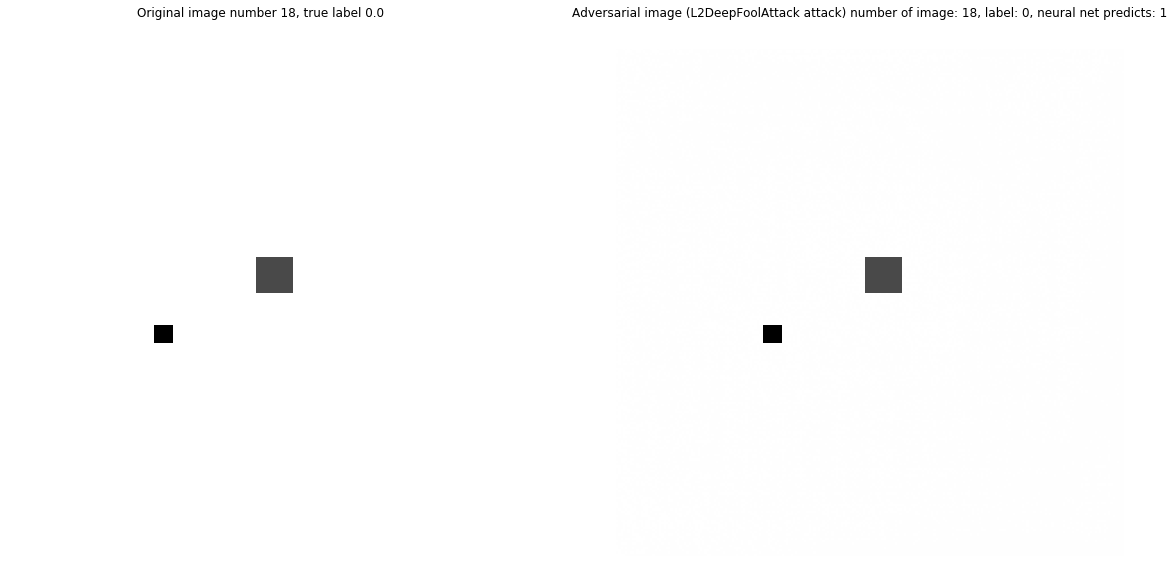

Image number 18.
Image number 20.
Image number 22.
Image number 23.
Image number 24.
Image number 25.
Image number 26.
Image number 27.
Image number 28.
Image number 29.
Image number 30.
Image number 31.
Image number 32.
Image number 33.
Image number 34.
Image number 35.
Image number 36.
Image number 37.
Image number 38.
Image number 39.
Image number 40.
Image number 41.
Image number 42.
Image number 43.
Image number 44.
Image number 46.
Image number 47.
Image number 49.
Image number 50.
Image number 51.
Image number 53.
Image number 54.
Image number 55.
Image number 56.
Image number 57.
Image number 58.
Image number 59.
Image number 62.
Image number 63.
Image number 64.
Image number 65.
Image number 66.
Image number 67.
Image number 68.
Image number 69.
Image number 70.
Image number 71.
Image number 72.
Image number 73.
Image number 74.
Image number 75.
Image number 77.
Image number 78.


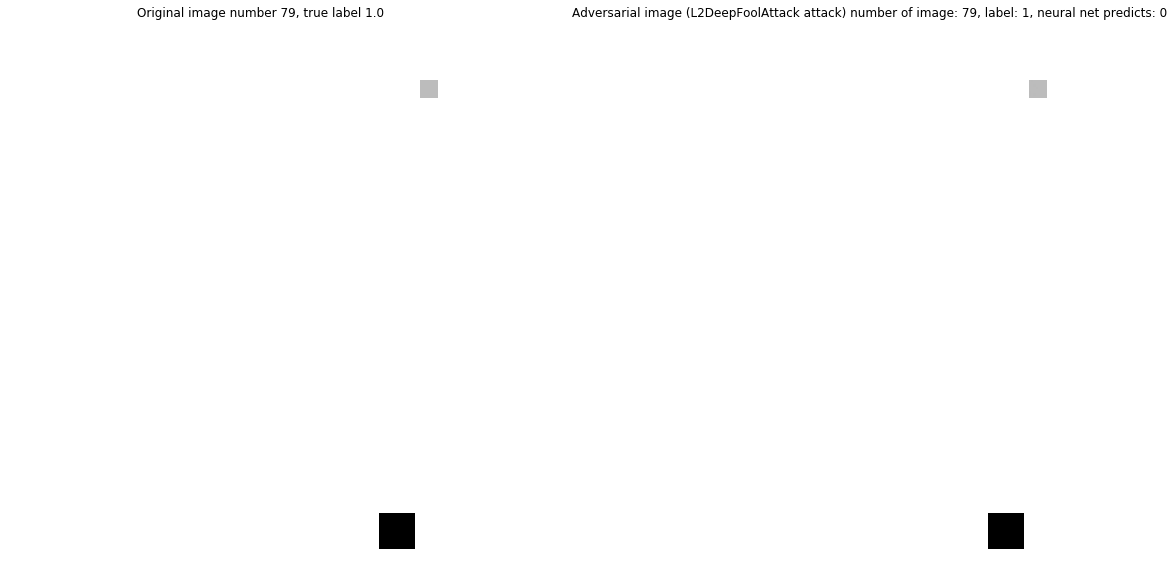

Image number 79.
Image number 81.
Image number 82.
Image number 83.
Image number 84.
Image number 86.
Image number 88.
Image number 89.
Image number 90.
Image number 91.
Image number 92.
Image number 93.
Image number 94.
Image number 95.
Image number 96.
Image number 97.
Image number 98.
Image number 100.
Image number 101.
Image number 102.
Image number 104.
Image number 105.
Image number 106.
Image number 107.
Image number 108.
Image number 109.
Image number 110.
Image number 111.
Image number 112.
Image number 113.
Image number 114.
Image number 115.
Image number 116.
Image number 117.
Image number 118.
Image number 119.
Image number 120.
Image number 121.
Image number 122.
Image number 123.
Image number 124.
Image number 125.
Image number 126.
Image number 127.
Image number 128.
Image number 129.
Image number 130.
Image number 131.
Image number 132.
Image number 133.
Image number 134.
Image number 135.
Image number 136.
Image number 137.
Image number 138.
Image number 139.
Image num

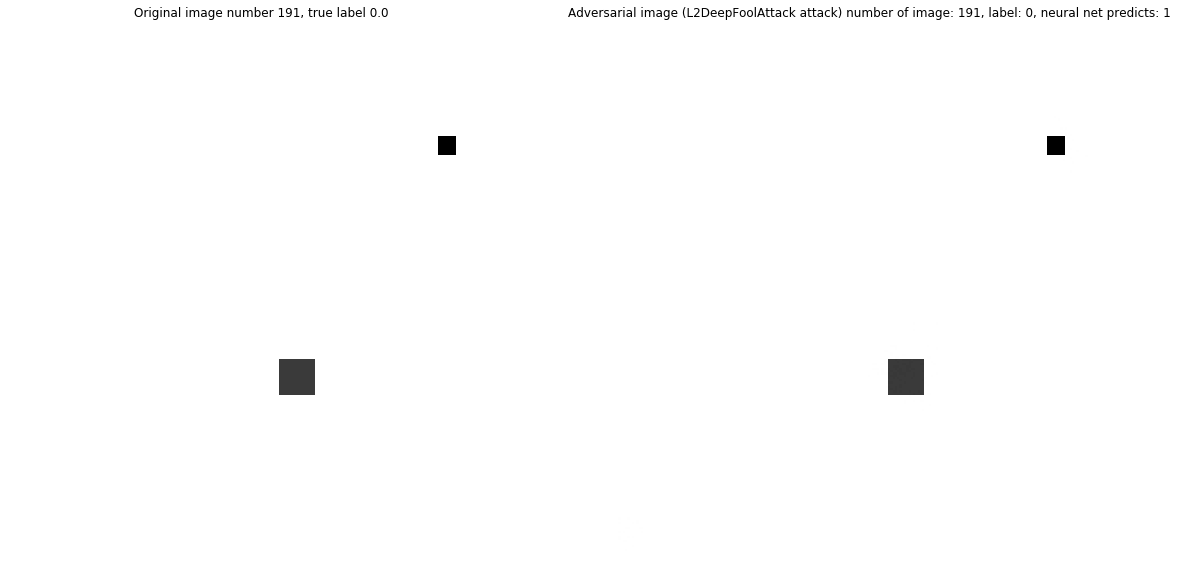

Image number 191.
Image number 192.
Image number 193.
Image number 194.
Image number 195.
Image number 196.
Image number 197.
Image number 198.
Image number 199.
Image number 200.
Image number 201.
Image number 202.
Image number 203.
Image number 204.
Image number 205.
Image number 206.
Image number 207.


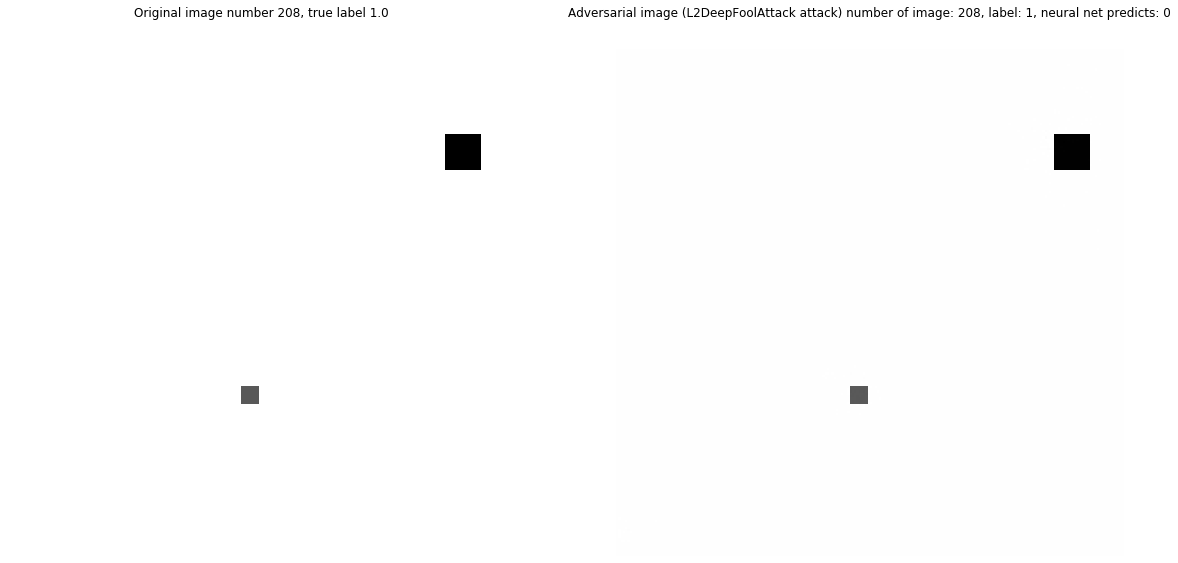

Image number 208.
Image number 210.
Image number 211.
Image number 212.
Image number 213.
Image number 214.
Image number 215.
Image number 216.
Image number 217.
Image number 218.
Image number 219.
Image number 220.
Image number 221.
Image number 222.
Image number 223.
Image number 224.
Image number 225.
Image number 226.
Image number 227.
Image number 228.
Image number 229.
Image number 230.
Image number 231.
Image number 232.
Image number 233.
Image number 234.
Image number 235.
Image number 236.
Image number 237.
Image number 238.
Image number 239.
Image number 240.
Image number 241.
Image number 242.
Image number 243.
Image number 244.
Image number 245.
Image number 246.
Image number 247.
Image number 248.
Image number 249.
Image number 250.
Image number 251.
Image number 252.
Image number 253.
Image number 254.
Image number 255.
Image number 256.
Image number 257.
Image number 258.
Image number 259.
Image number 260.
Image number 261.
Image number 262.
Image number 263.
Image numb

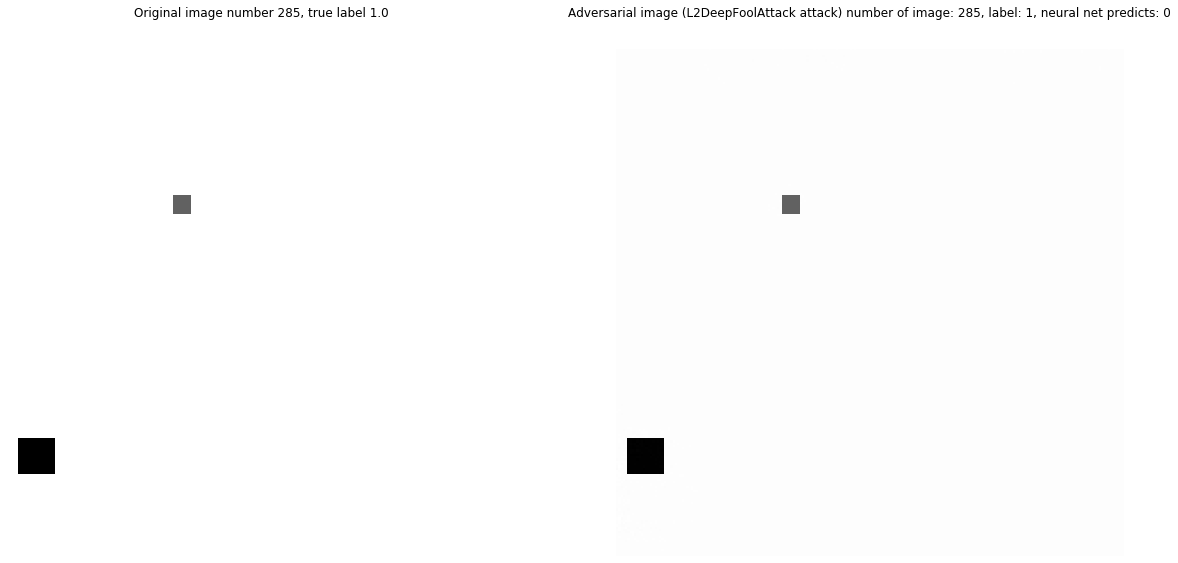

Image number 285.
Image number 287.
Image number 288.


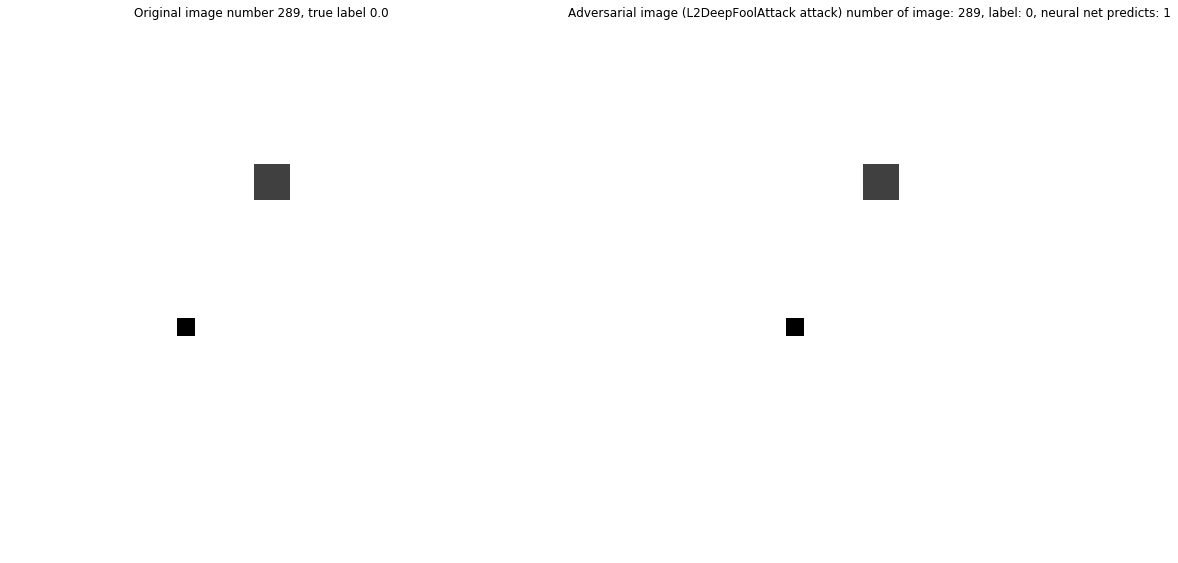

Image number 289.
Image number 290.
Image number 291.
Image number 292.
Image number 293.
Image number 294.
Image number 295.
Image number 296.
Image number 297.
Image number 298.
Image number 299.
Image number 300.
Image number 301.


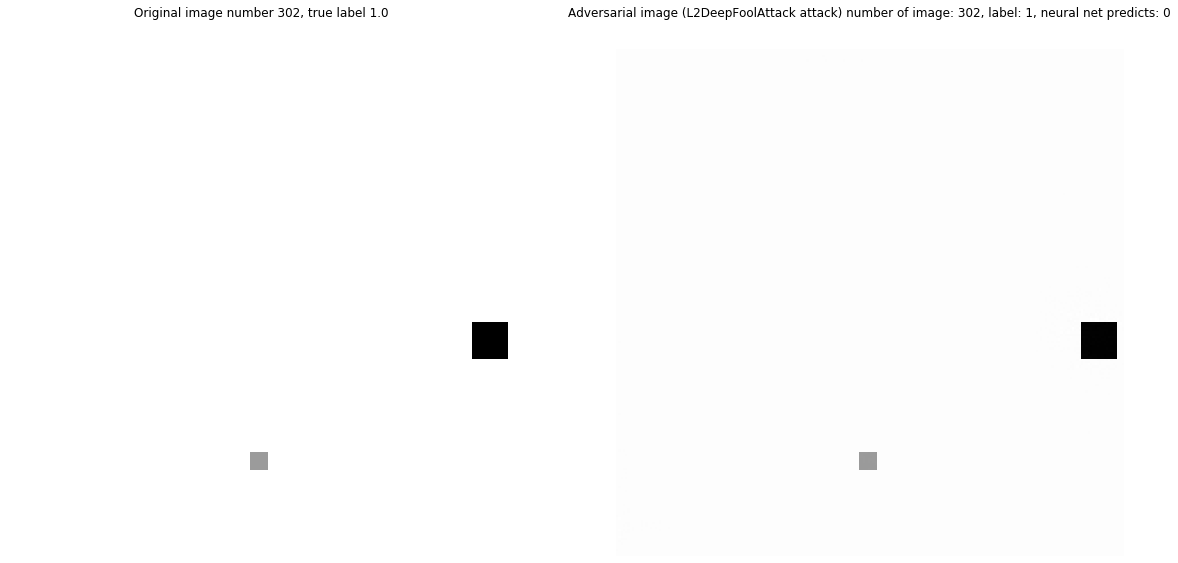

Image number 302.
Image number 303.
Image number 304.
Image number 305.
Image number 306.
Image number 307.
Image number 308.
Image number 309.


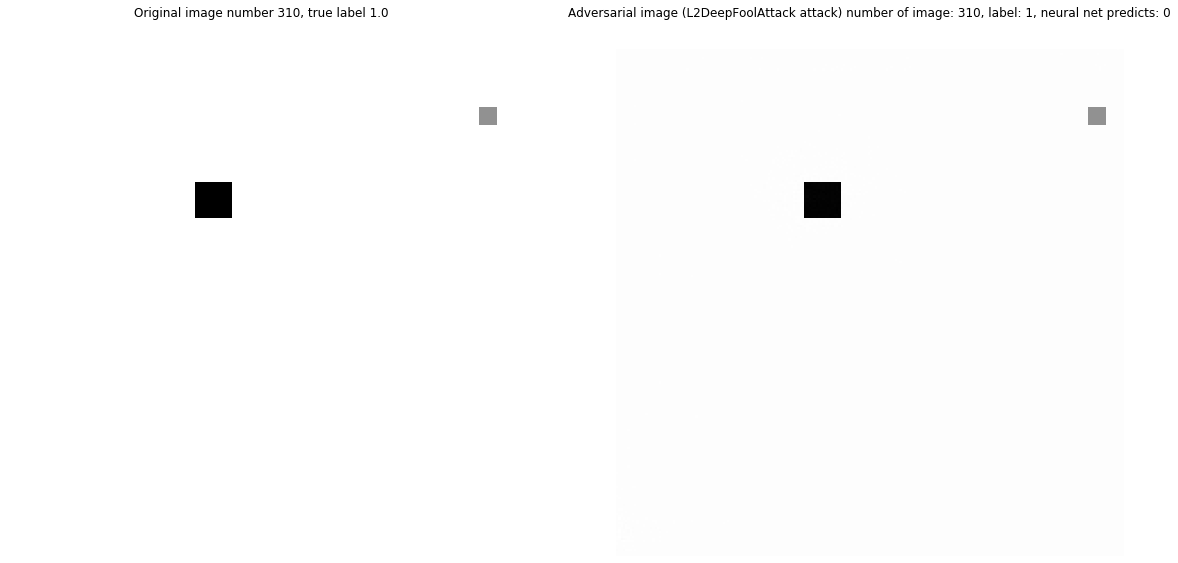

Image number 310.
Image number 311.
Image number 312.
Image number 313.


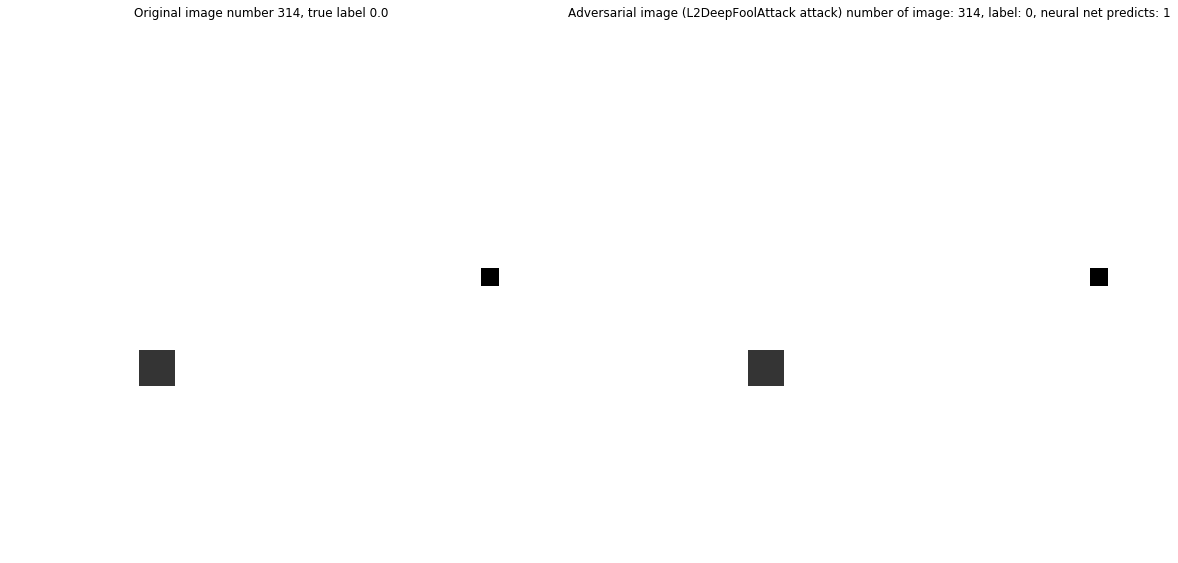

Image number 314.
Image number 315.
Image number 316.
Image number 317.
Image number 319.
Image number 321.
Image number 322.
Image number 323.
Image number 324.
Image number 325.
Image number 326.
Image number 327.
Image number 328.
Image number 329.
Image number 330.
Image number 331.
Image number 333.
Image number 334.
Image number 335.
Image number 336.
Image number 337.
Image number 338.
Image number 339.
Image number 340.
Image number 341.
Image number 342.
Image number 343.


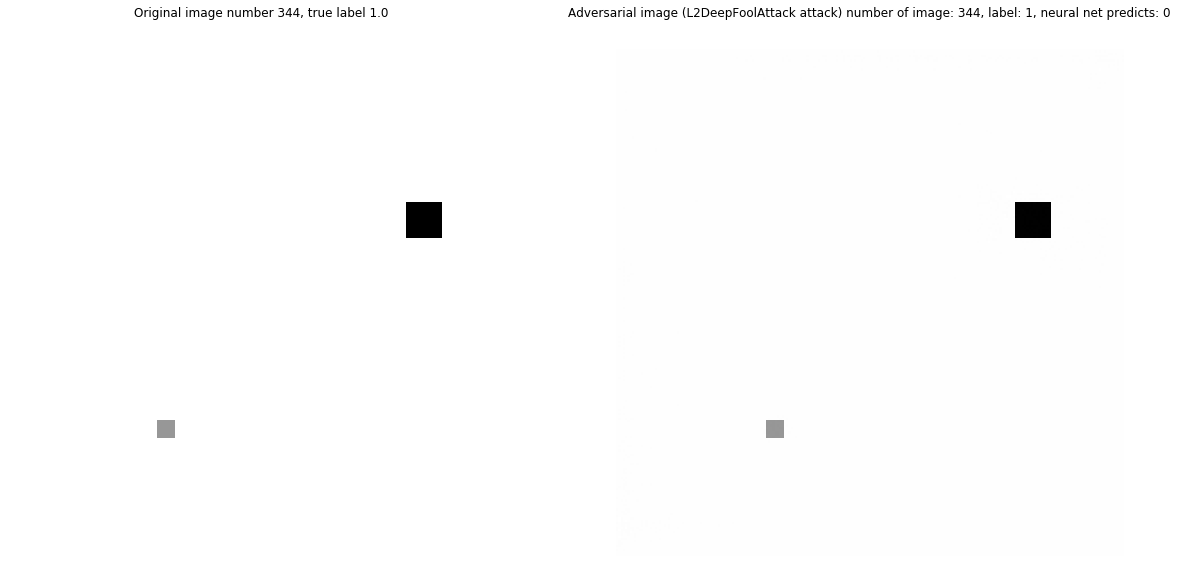

Image number 344.
Image number 345.
Image number 346.
Image number 347.
Image number 348.
Image number 349.
Image number 350.
Image number 351.
Image number 352.


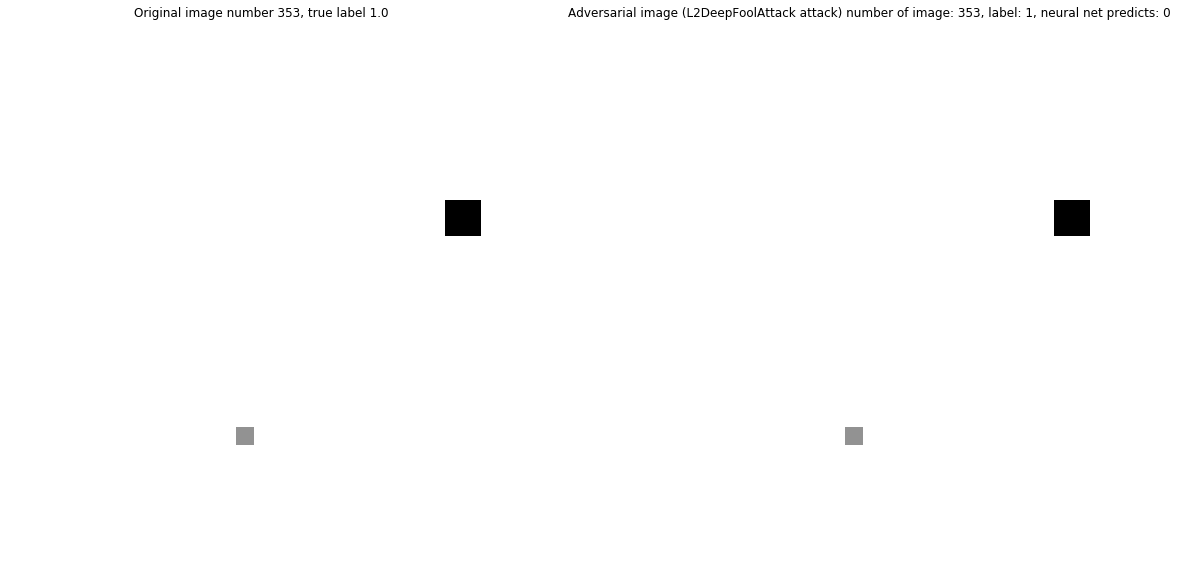

Image number 353.
Image number 354.
Image number 355.
Image number 356.
Image number 357.
Image number 358.
Image number 359.
Image number 360.
Image number 361.
Image number 362.
Image number 363.
Image number 364.
Image number 365.
Image number 366.
Image number 367.
Image number 368.
Image number 369.
Image number 370.
Image number 372.
Image number 373.
Image number 374.
Image number 375.
Image number 376.
Image number 377.
Image number 378.
Image number 379.
Image number 380.
Image number 381.
Image number 382.
Image number 383.
Image number 384.
Image number 385.
Image number 387.
Image number 388.
Image number 389.
Image number 390.
Image number 391.
Image number 392.
Image number 393.


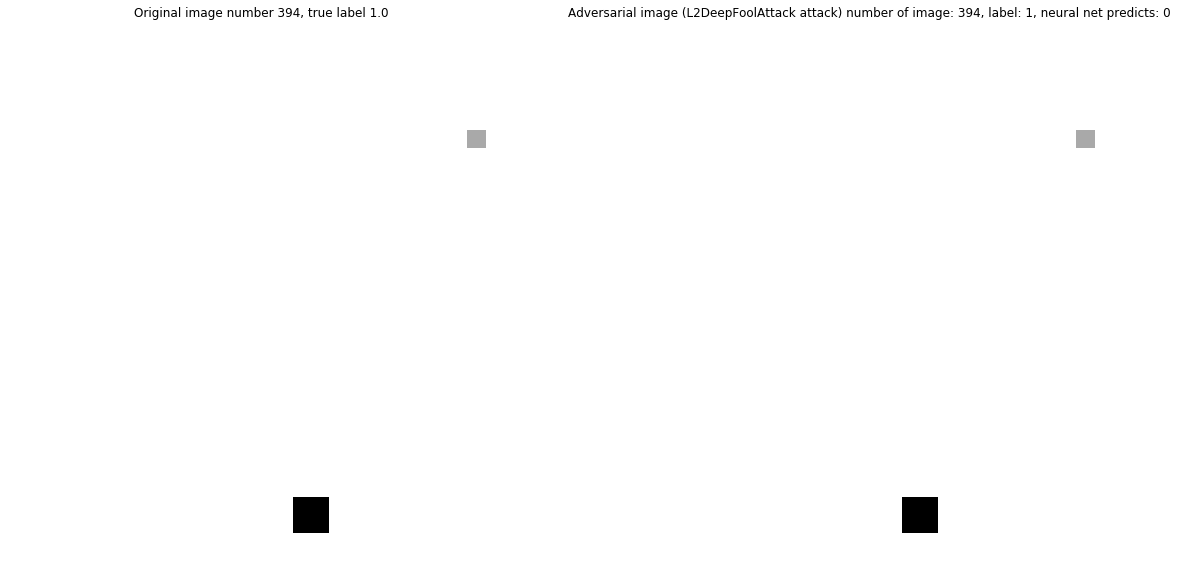

Image number 394.
Image number 396.


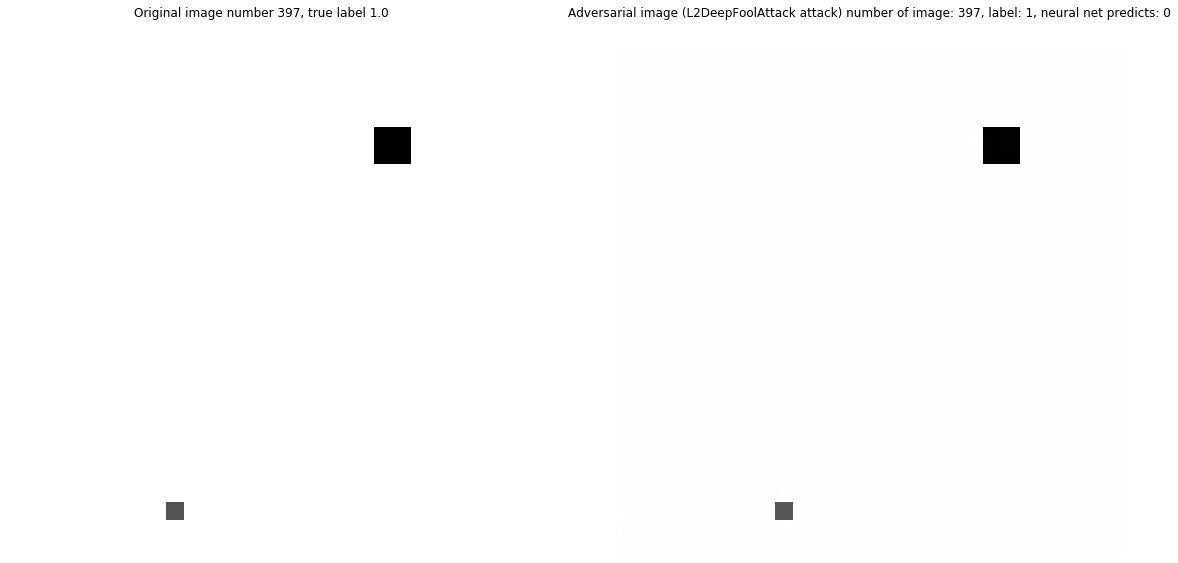

Image number 397.
Image number 398.
Image number 399.
Image number 400.


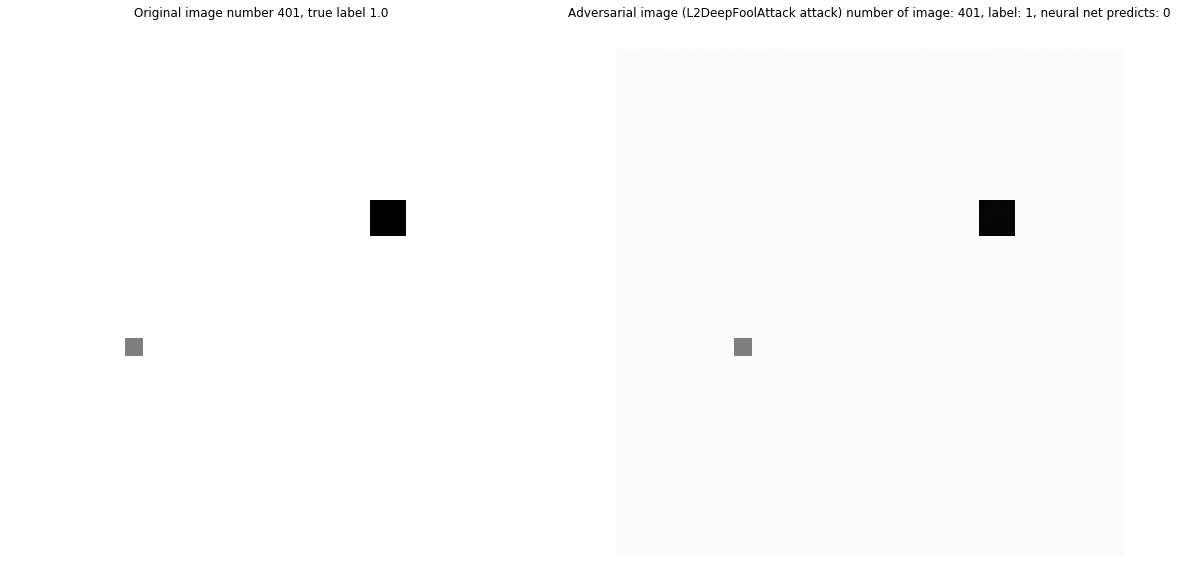

Image number 401.
Image number 402.
Image number 403.
Image number 404.
Image number 405.
Image number 406.
Image number 407.
Image number 408.
Image number 409.
Image number 410.
Image number 411.
Image number 413.
Image number 414.
Image number 415.
Image number 416.
Image number 417.
Image number 418.
Image number 419.
Image number 422.
Image number 423.
Image number 424.
Image number 425.
Image number 426.
Image number 427.
Image number 428.
Image number 429.
Image number 430.
Image number 431.
Image number 432.
Image number 433.
Image number 434.
Image number 435.
Image number 436.
Image number 437.
Image number 438.
Image number 439.
Image number 440.
Image number 441.
Image number 442.
Image number 443.
Image number 444.
Image number 445.
Image number 446.
Image number 447.
Image number 448.
Image number 449.
Image number 450.
Image number 451.


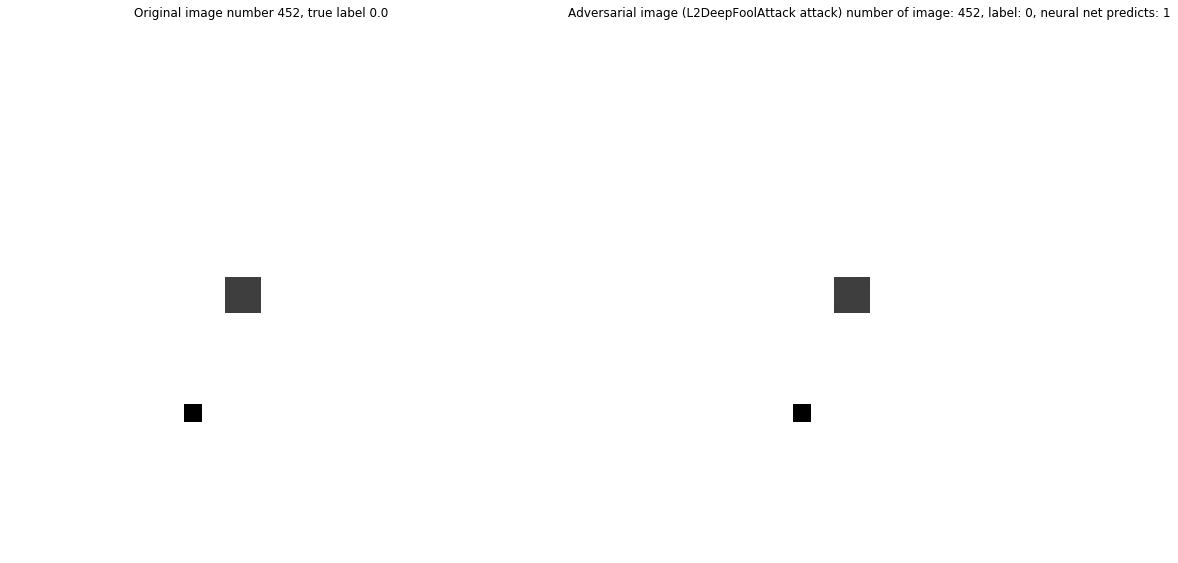

Image number 452.
Image number 453.
Image number 454.
Image number 455.
Image number 456.
Image number 457.
Image number 458.
Image number 459.
Image number 460.
Image number 461.
Image number 462.
Image number 463.
Image number 464.
Image number 465.
Image number 466.
Image number 467.
Image number 468.
Image number 469.
Image number 470.
Image number 471.
Image number 472.


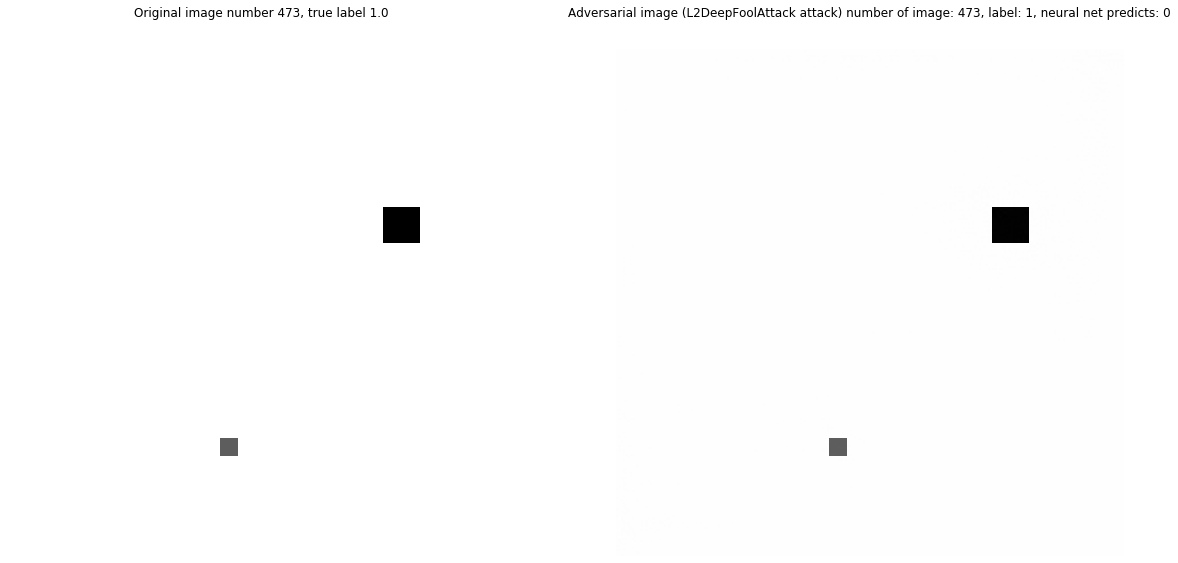

Image number 473.
Image number 474.
Image number 475.
Image number 476.
Image number 477.
Image number 478.
Image number 479.
Image number 480.
Image number 481.
Image number 482.
Image number 483.
Image number 484.
Image number 485.
Image number 486.
Image number 487.
Image number 488.
Image number 489.
Image number 490.
Image number 491.
Image number 492.
Image number 493.
Image number 494.
Image number 495.
Image number 497.
Image number 498.


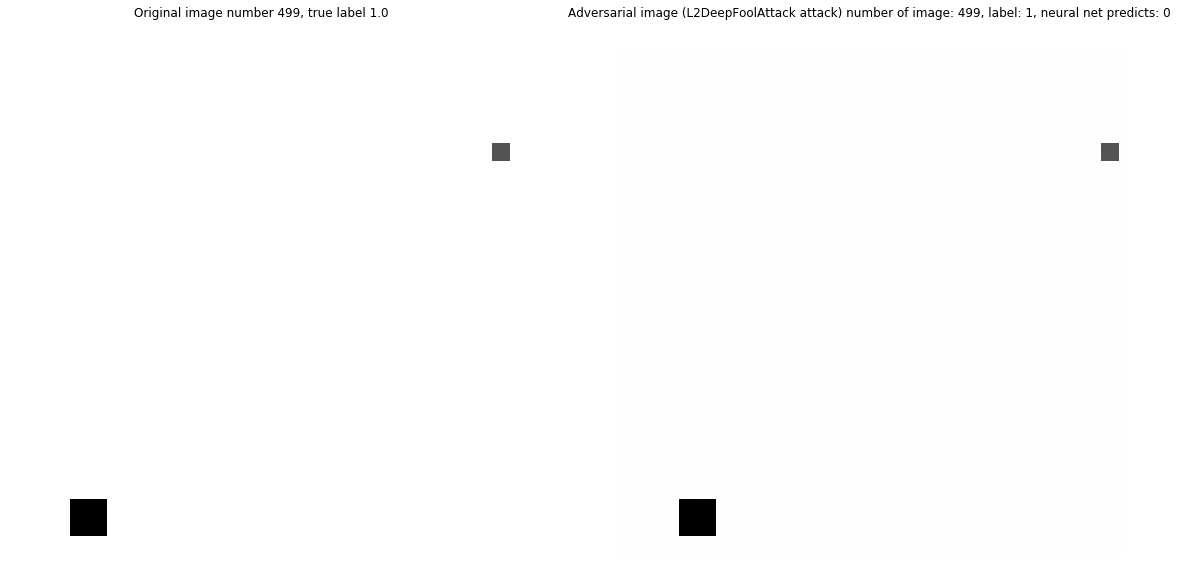

Image number 499.
Image number 500.
Image number 501.
Image number 502.
Image number 503.
Image number 505.
Image number 506.
Image number 507.
Image number 508.
Image number 509.
Image number 510.
Image number 511.
Image number 512.
Image number 513.
Image number 514.
Image number 515.
Image number 516.
Image number 517.
Image number 518.
Image number 519.
Image number 520.
Image number 521.
Image number 522.
Image number 523.
Image number 524.
Image number 525.
Image number 526.
Image number 527.
Image number 528.
Image number 529.
Image number 530.
Image number 531.
Image number 532.
Image number 533.
Image number 534.
Image number 535.
Image number 536.
Image number 537.
Image number 538.
Image number 539.
Image number 540.
Image number 541.
Image number 542.
Image number 544.
Image number 545.
Image number 546.
Image number 547.
Image number 548.
Image number 549.
Image number 550.
Image number 552.
Image number 553.
Image number 554.
Image number 555.
Image number 556.
Image numb

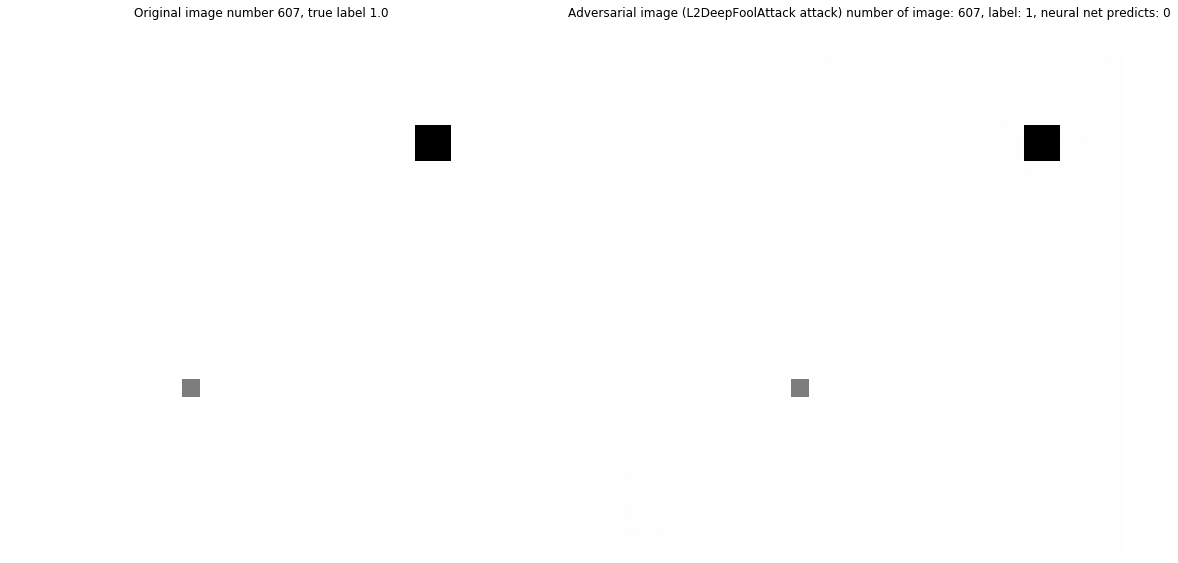

Image number 607.
Image number 608.
Image number 609.


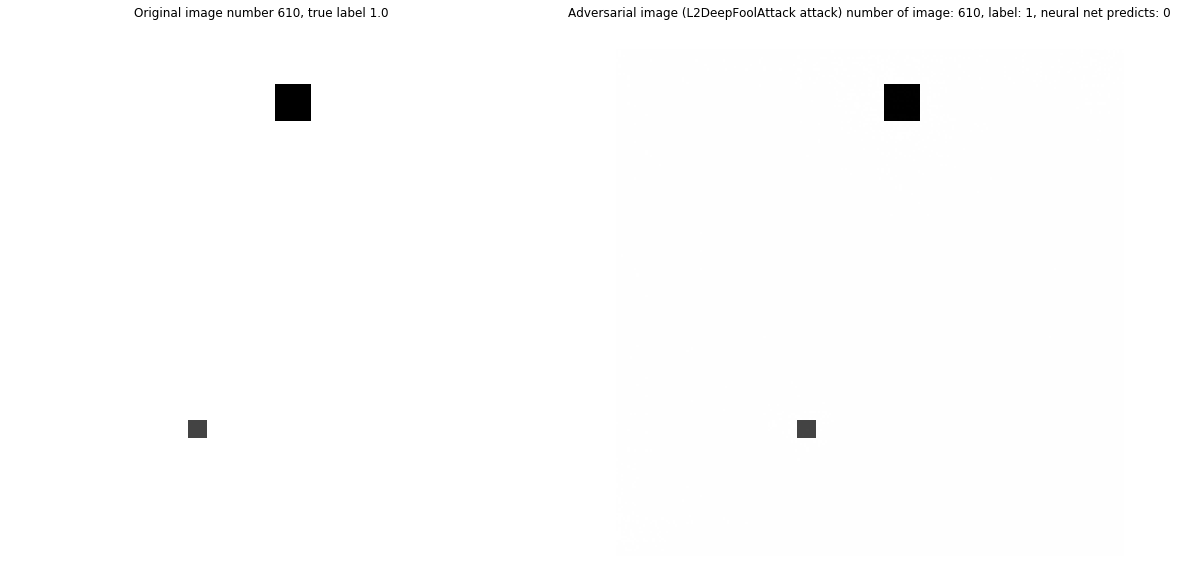

Image number 610.
Image number 611.
Image number 612.
Image number 613.
Image number 614.
Image number 615.
Image number 616.
Image number 617.
Image number 618.
Image number 619.
Image number 620.
Image number 622.
Image number 623.
Image number 624.
Image number 625.
Image number 626.
Image number 627.
Image number 628.
Image number 630.
Image number 631.
Image number 632.
Image number 633.
Image number 635.
Image number 636.


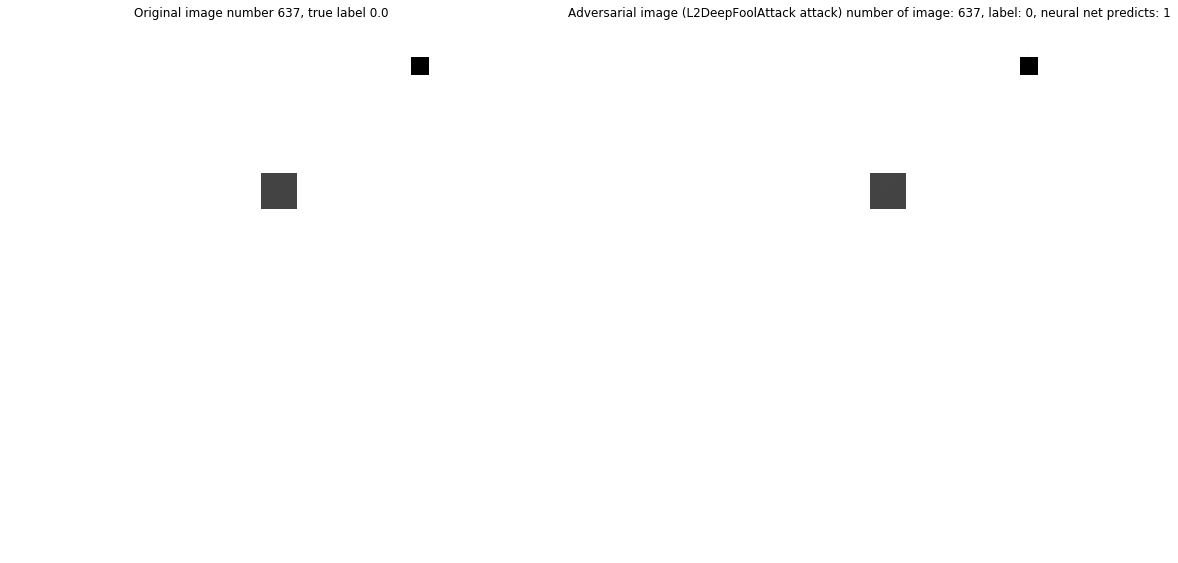

Image number 637.
Image number 638.
Image number 639.
Image number 640.
Image number 641.
Image number 642.
Image number 643.
Image number 644.
Image number 645.
Image number 646.
Image number 647.
Image number 648.
Image number 649.
Image number 650.
Image number 651.
Image number 652.
Image number 653.
Image number 654.
Image number 655.
Image number 656.
Image number 657.
Image number 658.
Image number 659.
Image number 660.
Image number 661.
Image number 662.
Image number 663.
Image number 664.


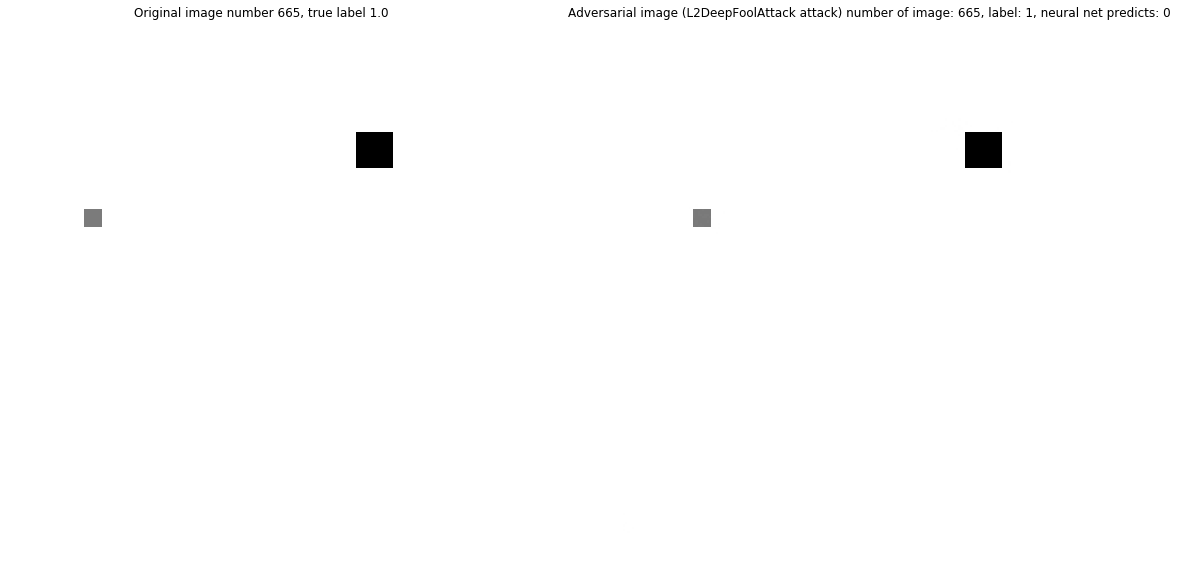

Image number 665.
Image number 666.
Image number 667.
Image number 668.
Image number 669.
Image number 670.
Image number 671.
Image number 672.
Image number 673.
Image number 674.
Image number 675.
Image number 676.
Image number 678.
Image number 679.
Image number 680.
Image number 681.
Image number 682.
Image number 683.
Image number 684.
Image number 685.
Image number 686.
Image number 687.


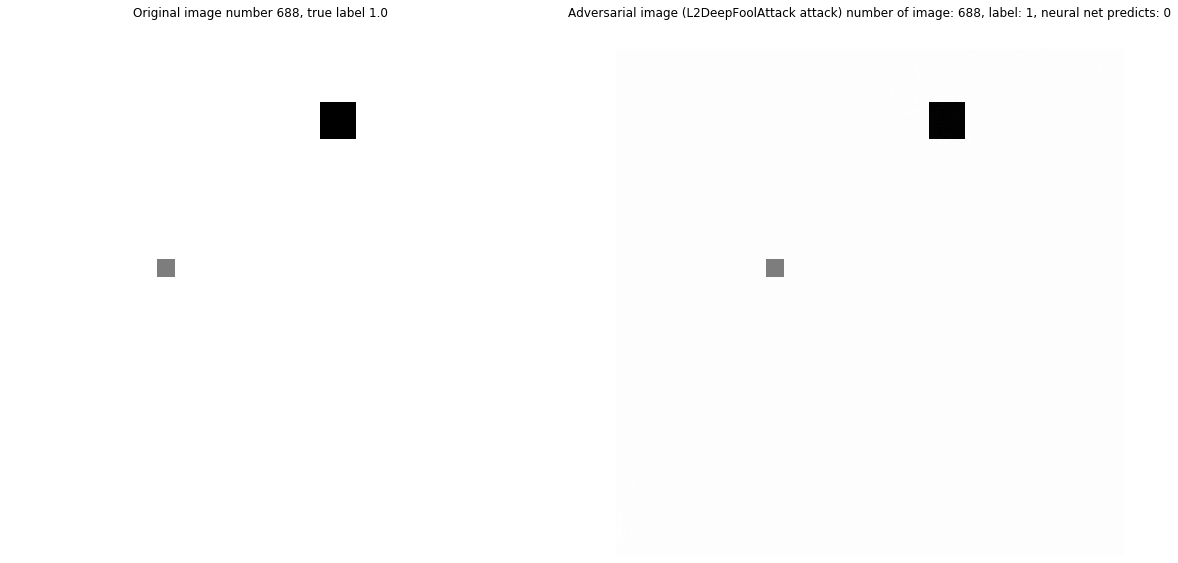

Image number 688.
Image number 689.
Image number 690.
Image number 691.
Image number 692.
Image number 693.
Image number 694.
Image number 695.
Image number 696.
Image number 697.
Image number 698.
Image number 699.
Image number 700.
Image number 702.
Image number 703.
Image number 704.
Image number 705.
Image number 708.
Image number 709.
Image number 710.
Image number 711.


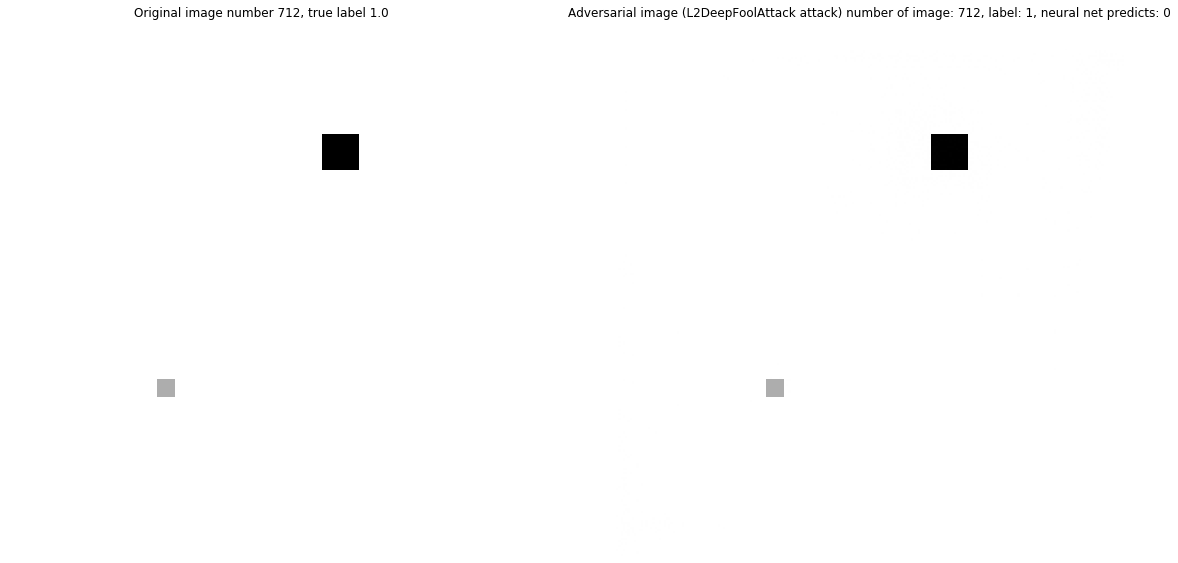

Image number 712.
Image number 713.
Image number 714.
Image number 715.
Image number 716.
Image number 717.
Image number 718.
Image number 719.
Image number 720.
Image number 721.
Image number 722.
Image number 723.
Image number 724.
Image number 725.
Image number 726.
Image number 727.
Image number 728.
Image number 729.
Image number 730.
Image number 731.
Image number 732.
Image number 733.
Image number 734.
Image number 735.
Image number 736.
Image number 737.
Image number 738.
Image number 739.
Image number 740.
Image number 741.
Image number 742.
Image number 743.
Image number 744.


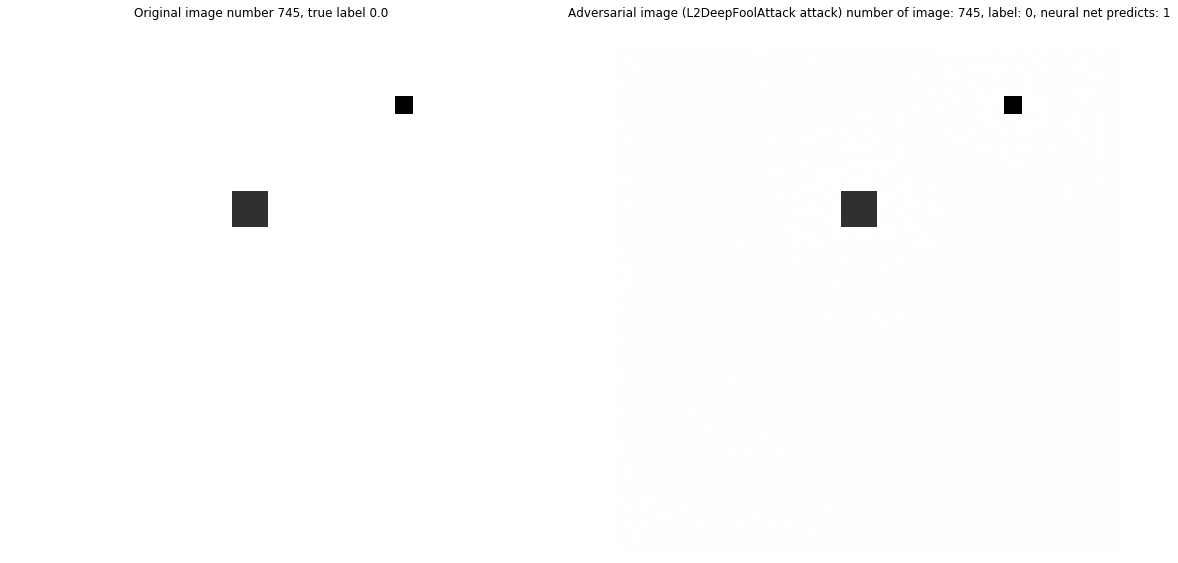

Image number 745.


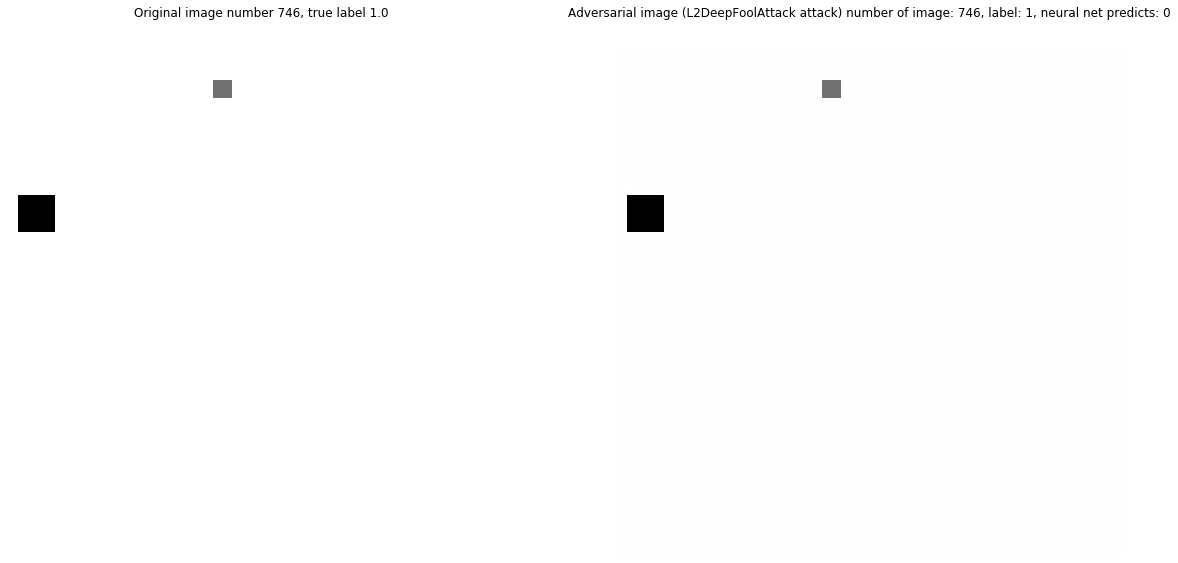

Image number 746.
Image number 747.
Image number 748.
Image number 750.
Image number 751.
Image number 752.
Image number 753.
Image number 754.
Image number 755.
Image number 756.
Image number 757.
Image number 758.
Image number 759.
Image number 760.
Image number 761.
Image number 762.
Image number 763.
Image number 764.
Image number 766.
Image number 767.
Image number 768.
Image number 769.
Image number 770.
Image number 771.
Image number 772.
Image number 773.
Image number 774.
Image number 775.
Image number 776.
Image number 777.
Image number 778.
Image number 779.
Image number 780.
Image number 781.
Image number 782.
Image number 783.
Image number 784.
Image number 785.
Image number 786.
Image number 787.
Image number 788.
Image number 789.
Image number 790.
Image number 791.
Image number 792.
Image number 793.
Image number 794.
Image number 795.
Image number 796.
Image number 797.
Image number 798.
Image number 799.
Image number 801.
Image number 803.
Image number 804.
Image numb

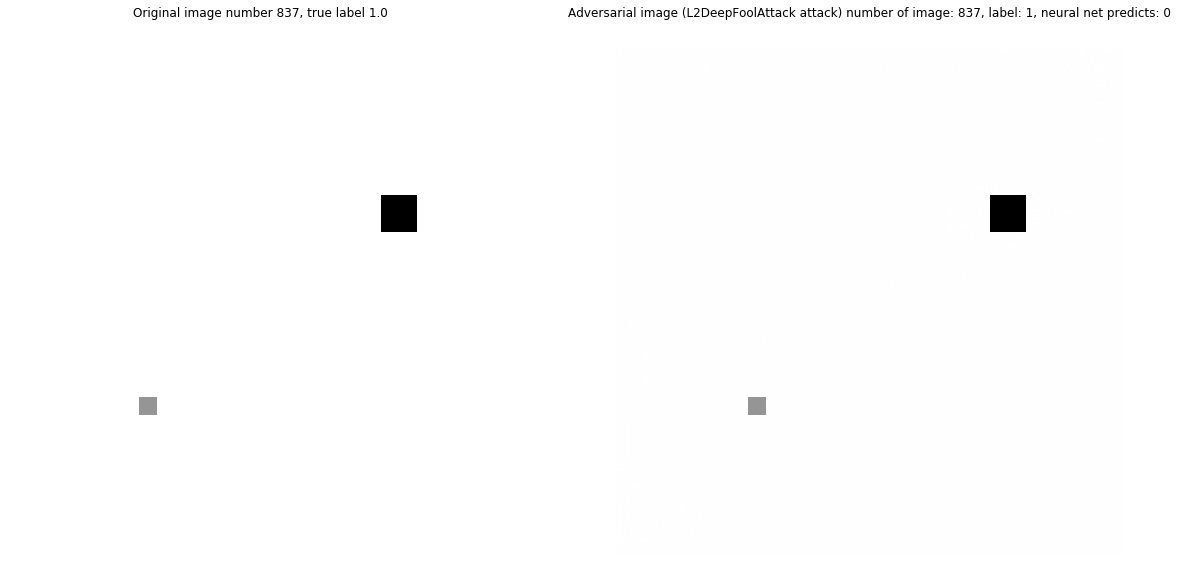

Image number 837.
Image number 838.
Image number 839.
Image number 840.
Image number 841.
Image number 842.
Image number 843.
Image number 845.
Image number 846.
Image number 847.
Image number 848.
Image number 849.
Image number 850.
Image number 851.
Image number 852.
Image number 853.
Image number 854.
Image number 855.
Image number 856.


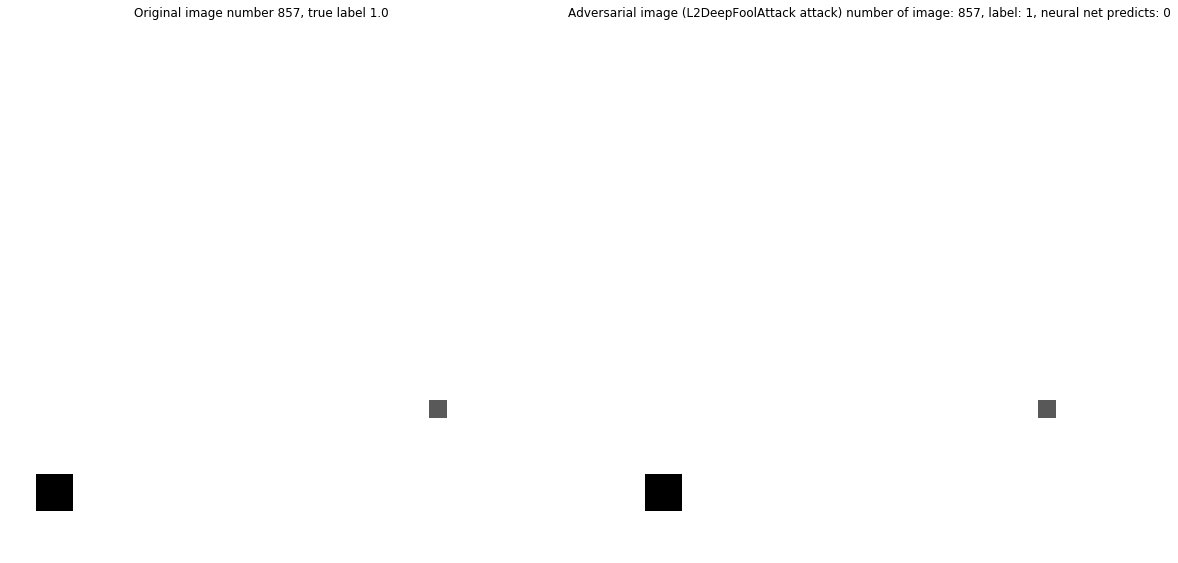

Image number 857.
Image number 858.
Image number 859.
Image number 860.
Image number 861.
Image number 862.
Image number 863.
Image number 864.
Image number 865.
Image number 866.
Image number 868.
Image number 869.
Image number 870.
Image number 872.
Image number 873.
Image number 874.
Image number 875.
Image number 876.
Image number 877.
Image number 878.
Image number 879.


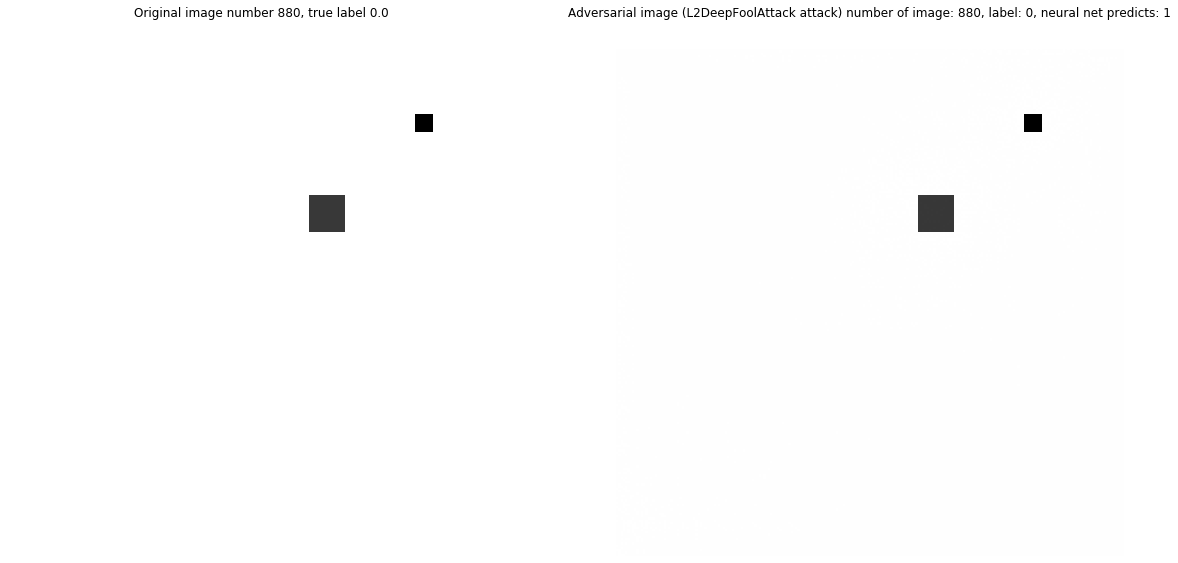

Image number 880.
Image number 881.
Image number 882.


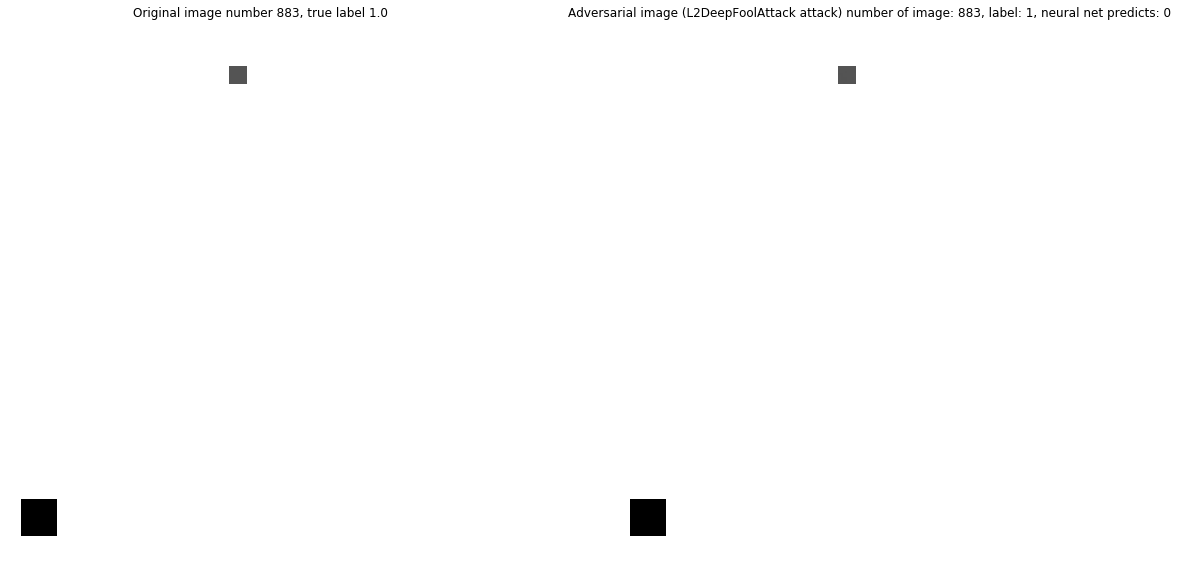

Image number 883.
Image number 884.
Image number 885.
Image number 886.
Image number 887.
Image number 888.
Image number 889.
Image number 890.
Image number 891.
Image number 892.
Image number 893.
Image number 894.
Image number 895.
Image number 896.
Image number 897.
Image number 898.
Image number 899.
Image number 900.
Image number 901.
Image number 902.
Image number 903.
Image number 904.
Image number 905.
Image number 906.
Image number 907.
Image number 908.
Image number 909.
Image number 910.
Image number 911.
Image number 912.
Image number 913.
Image number 914.
Image number 915.
Image number 916.
Image number 917.
Image number 918.
Image number 919.
Image number 920.
Image number 921.
Image number 922.


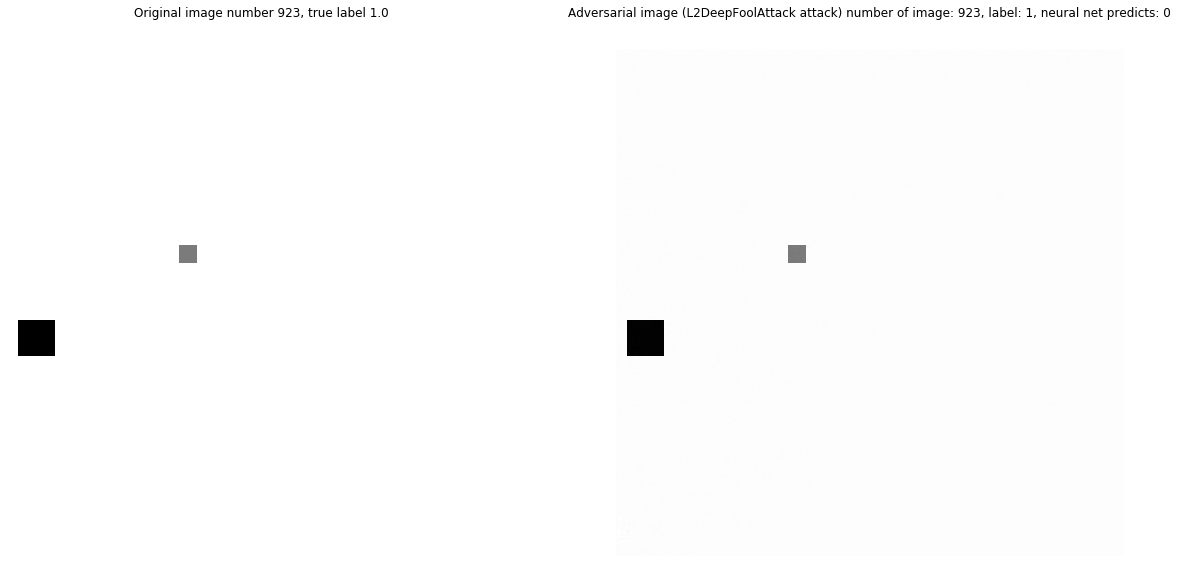

Image number 923.
Image number 924.
Image number 925.
Image number 926.
Image number 927.
Image number 928.
Image number 930.
Image number 931.
Image number 932.
Image number 933.
Image number 934.
Image number 935.
Image number 936.
Image number 937.


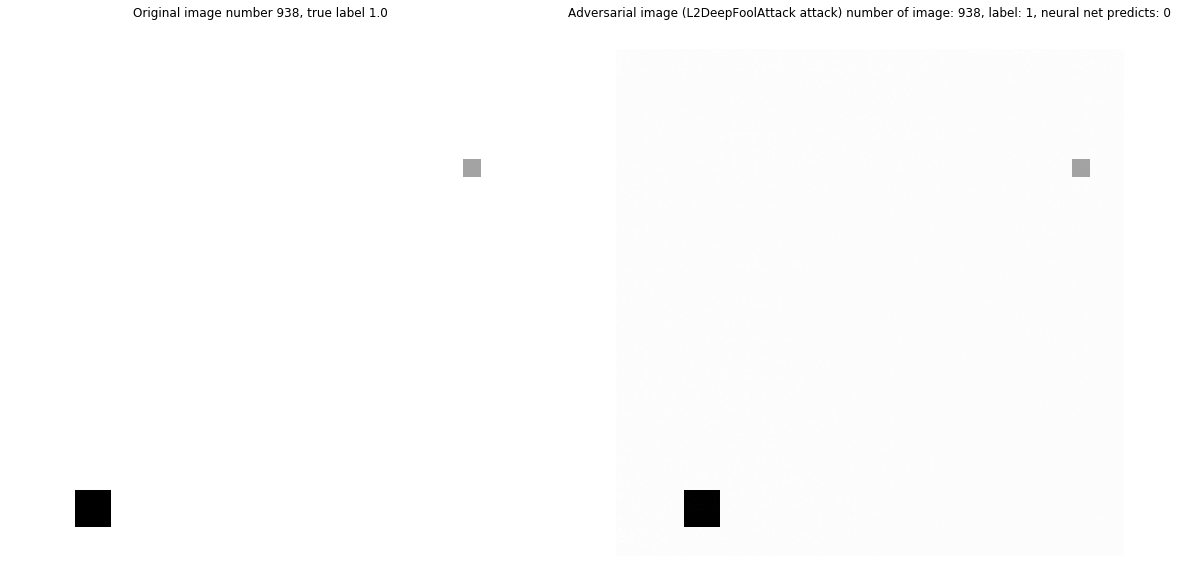

Image number 938.


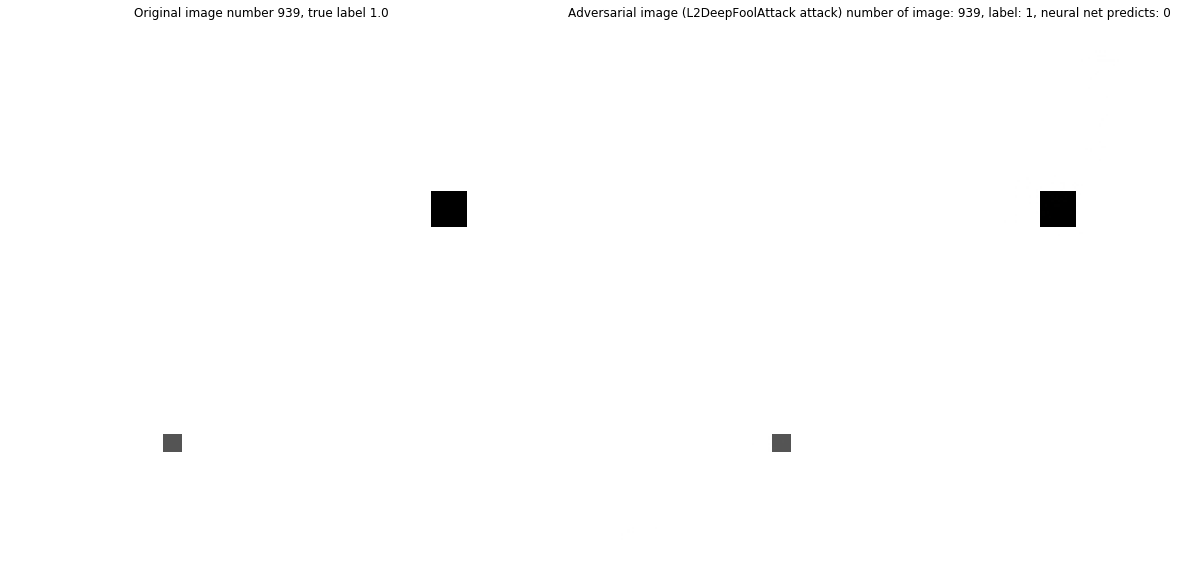

Image number 939.
Image number 940.
Image number 941.
Image number 942.
Image number 943.
Image number 944.
Image number 945.
Image number 946.
Image number 947.
Image number 948.
Image number 949.
Image number 950.
Image number 951.
Image number 953.
Image number 954.
Image number 955.
Image number 956.
Image number 957.
Image number 958.
Image number 959.


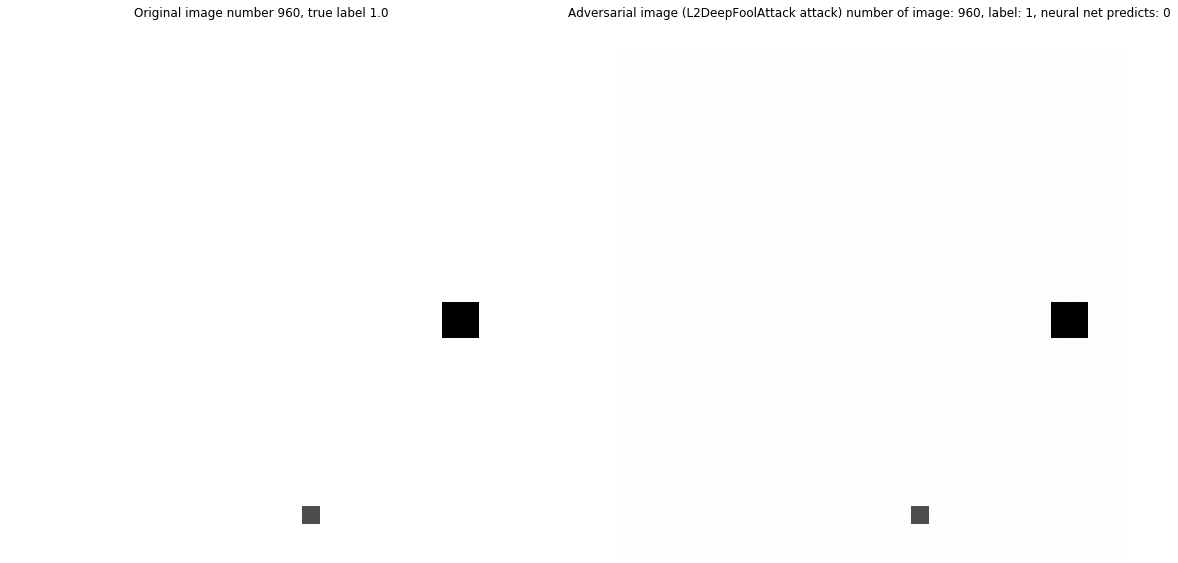

Image number 960.
Image number 961.
Image number 962.
Image number 963.
Image number 964.
Image number 965.
Image number 966.
Image number 967.
Image number 968.
Image number 969.
Image number 970.
Image number 971.
Image number 972.
Image number 973.
Image number 974.
Image number 975.
Image number 976.
Image number 977.
Image number 978.
Image number 979.
Image number 981.


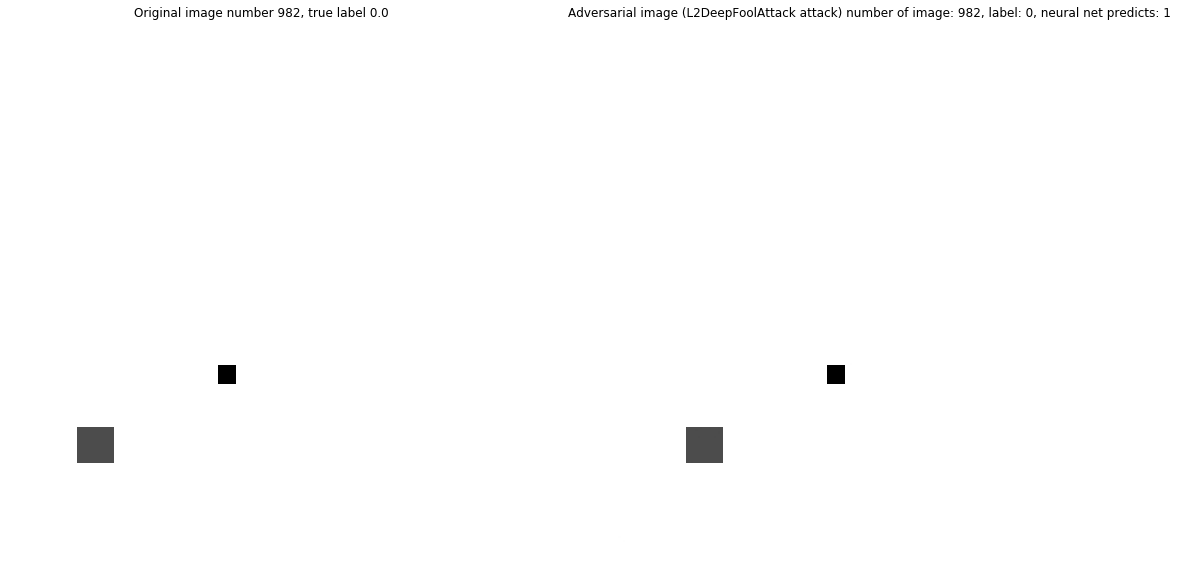

Image number 982.
Image number 983.
Image number 984.
Image number 985.
Image number 986.
Image number 987.
Image number 988.
Image number 989.
Image number 990.
Image number 991.
Image number 992.
Image number 993.
Image number 995.
Image number 996.
Image number 997.
Image number 998.
Image number 999.
Image number 1000.
Image number 1001.
Image number 1002.
Image number 1003.
Image number 1004.
Image number 1005.
Image number 1006.
Image number 1007.
Image number 1008.
Image number 1009.
Image number 1010.
Image number 1011.
Image number 1012.
Image number 1013.
Image number 1014.
Image number 1015.
Image number 1016.
Image number 1017.
Image number 1018.
Image number 1019.
Image number 1020.
Image number 1021.
Image number 1022.


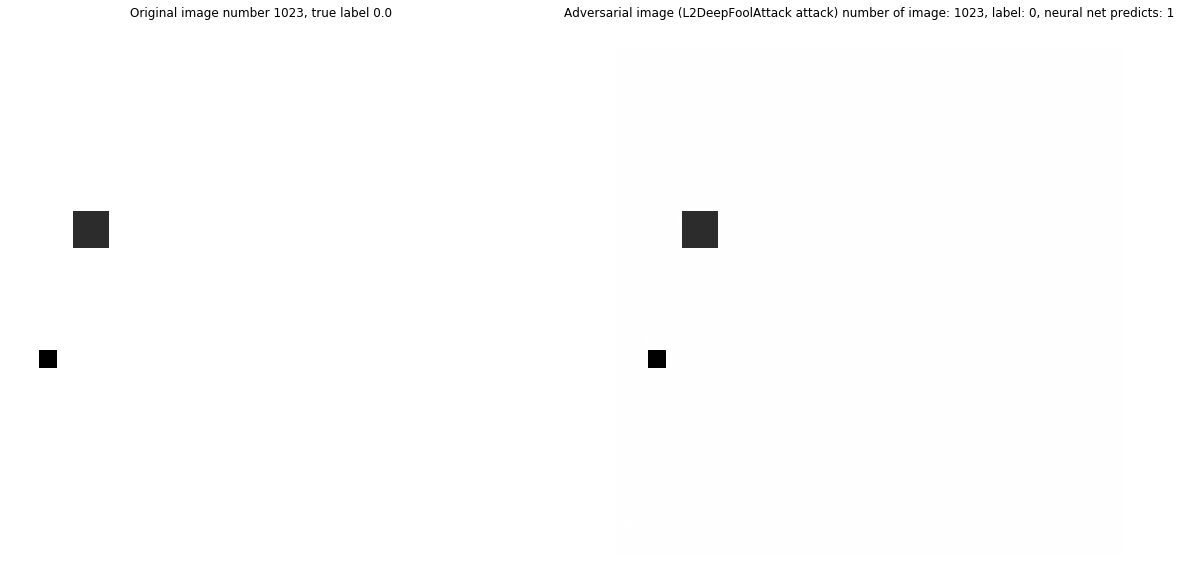

Image number 1023.
Image number 1024.
Image number 1025.
Image number 1026.
Image number 1027.
Image number 1028.
Image number 1029.
Image number 1030.
Image number 1031.
Image number 1032.
Image number 1033.
Image number 1034.
Image number 1035.
Image number 1036.
Image number 1037.
Image number 1038.
Image number 1039.
Image number 1040.
Image number 1041.
Image number 1042.
Image number 1043.
Image number 1044.
Image number 1045.
Image number 1046.
Image number 1047.
Image number 1048.
Image number 1049.
Image number 1050.
Image number 1051.
Image number 1052.
Image number 1053.
Image number 1054.
Image number 1055.
Image number 1056.
Image number 1057.
Image number 1059.
Image number 1060.
Image number 1061.
Image number 1062.
Image number 1063.


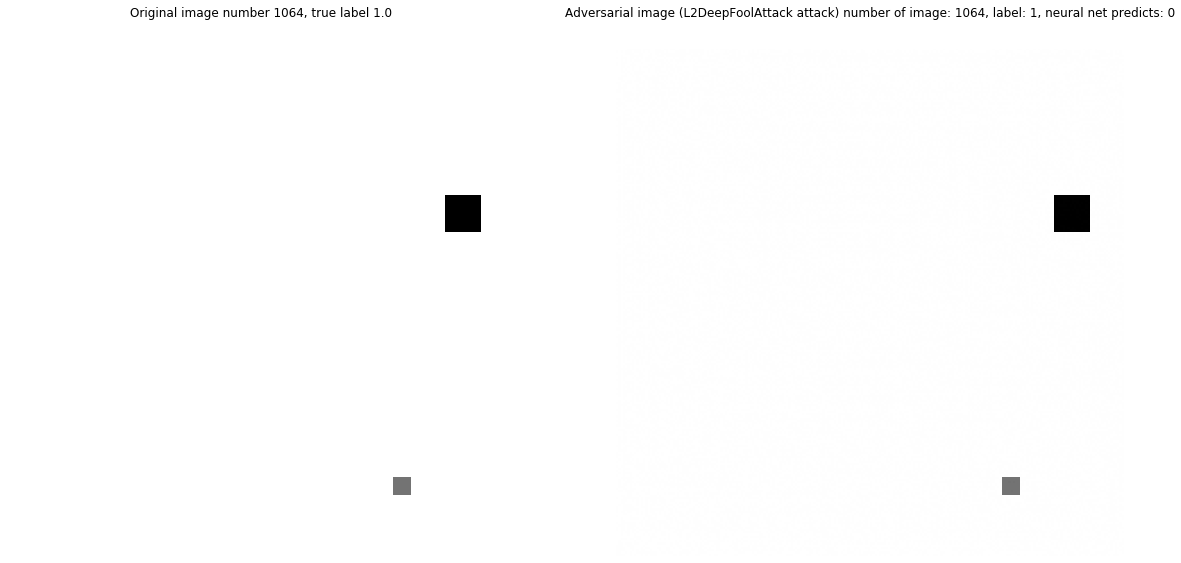

Image number 1064.
Image number 1065.
Image number 1066.
Image number 1067.
Image number 1068.
Image number 1069.
Image number 1070.
Image number 1071.
Image number 1072.
Image number 1073.
Image number 1074.
Image number 1075.
Image number 1076.
Image number 1077.
Image number 1078.
Image number 1079.
Image number 1080.
Image number 1081.
Image number 1082.
Image number 1083.
Image number 1084.
Image number 1085.
Image number 1086.
Image number 1088.
Image number 1089.


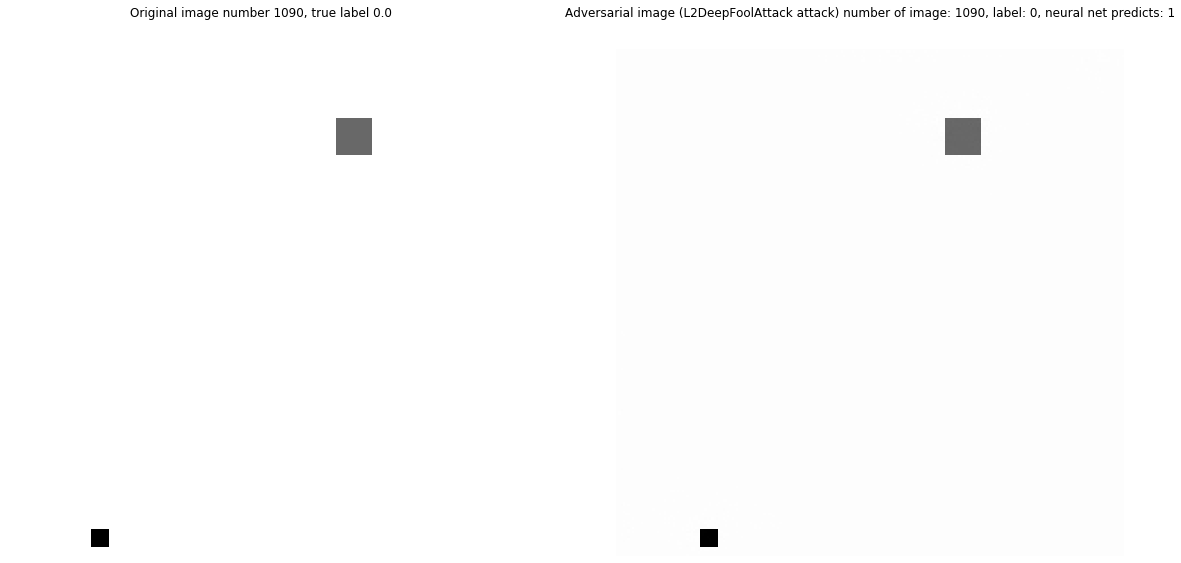

Image number 1090.
Image number 1091.
Image number 1093.
Image number 1094.
Image number 1095.
Image number 1096.
Image number 1097.
Image number 1098.
Image number 1099.
Image number 1100.
Image number 1101.
Image number 1102.
Image number 1103.
Image number 1104.
Image number 1105.
Image number 1106.
Image number 1107.
Image number 1108.
Image number 1109.
Image number 1110.
Image number 1111.
Image number 1112.
Image number 1113.
Image number 1114.
Image number 1115.
Image number 1117.
Image number 1118.
Image number 1119.
Image number 1120.
Image number 1121.
Image number 1122.
Image number 1123.
Image number 1124.
Image number 1125.


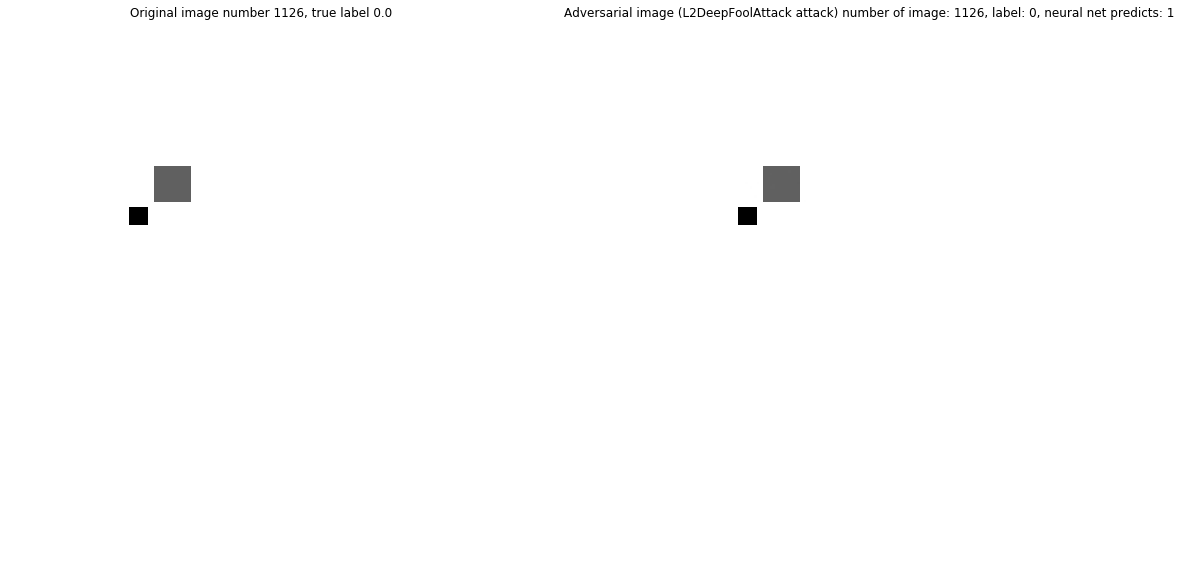

Image number 1126.
Image number 1128.
Image number 1129.
Image number 1130.
Image number 1131.
Image number 1132.
Image number 1133.
Image number 1134.
Image number 1135.
Image number 1136.
Image number 1137.
Image number 1138.
Image number 1139.
Image number 1140.
Image number 1141.
Image number 1143.
Image number 1144.
Image number 1145.
Image number 1146.
Image number 1147.
Image number 1148.
Image number 1149.
Image number 1150.
Image number 1151.
Image number 1152.
Image number 1153.
Image number 1154.
Image number 1155.


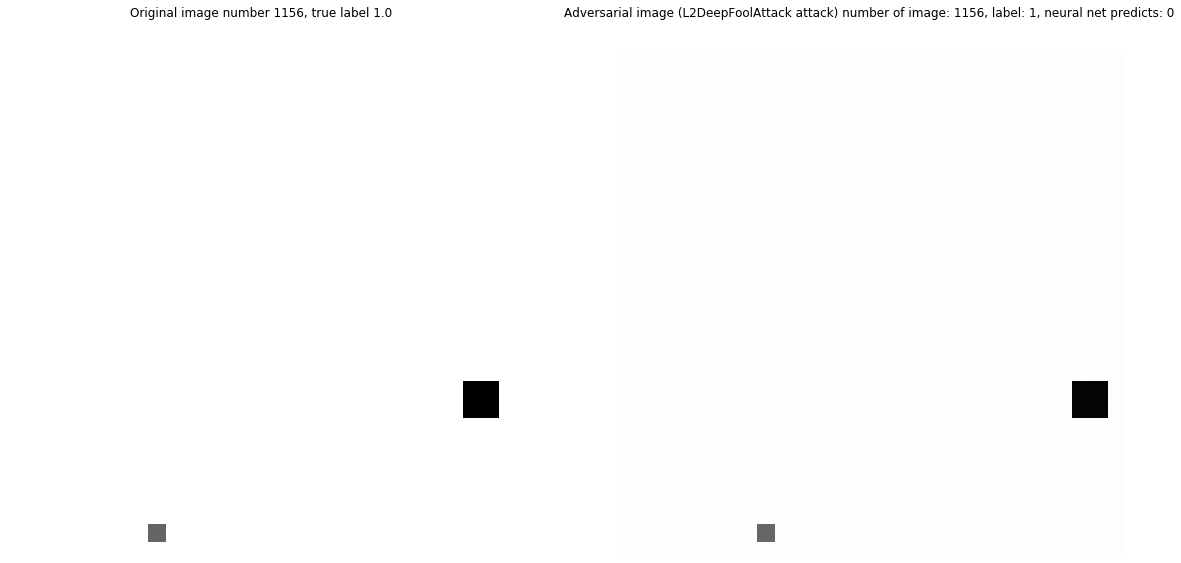

Image number 1156.
Image number 1157.
Image number 1158.
Image number 1159.
Image number 1160.
Image number 1161.
Image number 1162.
Image number 1163.
Image number 1164.
Image number 1166.
Image number 1167.


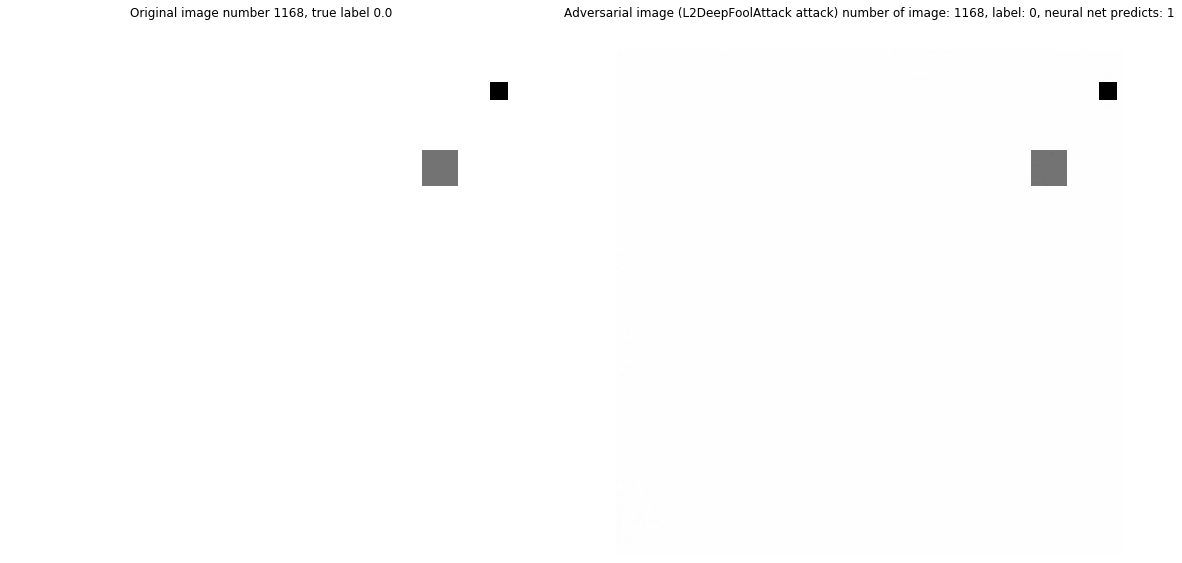

Image number 1168.
Image number 1169.
Image number 1170.
Image number 1171.
Image number 1172.
Image number 1173.
Image number 1174.
Image number 1175.
Image number 1176.
Image number 1177.
Image number 1178.
Image number 1179.
Image number 1180.
Image number 1181.


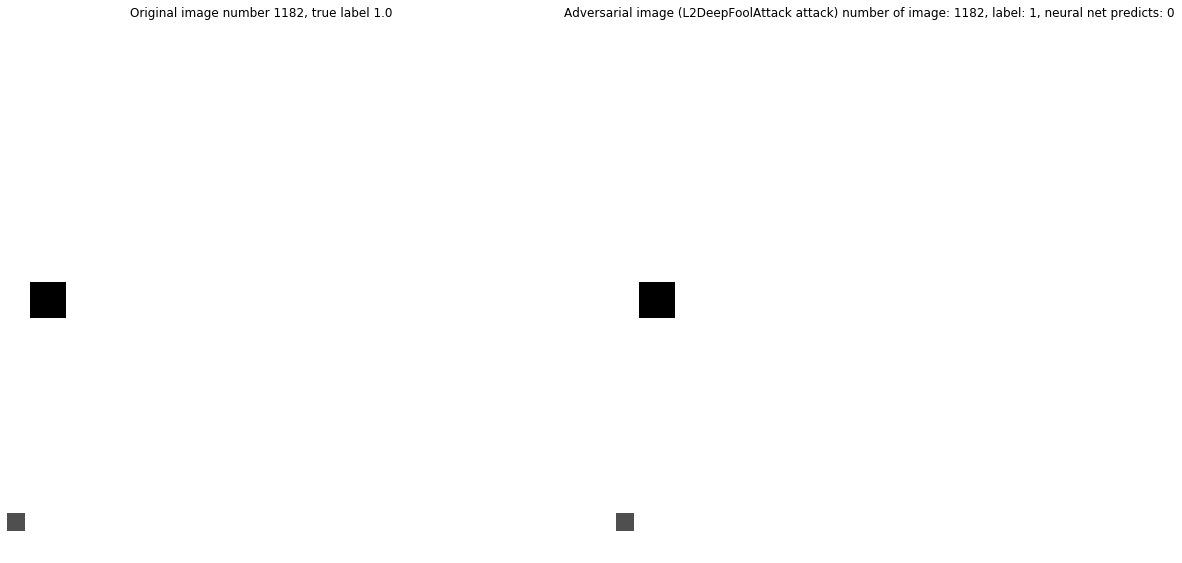

Image number 1182.
Image number 1183.
Image number 1184.
Image number 1185.
Image number 1186.
Image number 1187.
Image number 1188.
Image number 1189.
Image number 1190.
Image number 1191.
Image number 1192.
Image number 1193.
Image number 1194.
Image number 1195.
Image number 1196.
Image number 1197.
Image number 1198.
Image number 1199.
Image number 1200.
Image number 1201.
Image number 1202.
Image number 1203.
Image number 1204.
Image number 1205.
Image number 1206.
Image number 1207.
Image number 1208.
Image number 1209.
Image number 1211.
Image number 1213.
Image number 1214.
Image number 1215.
Image number 1216.
Image number 1217.
Image number 1218.
Image number 1219.
Image number 1220.
Image number 1221.


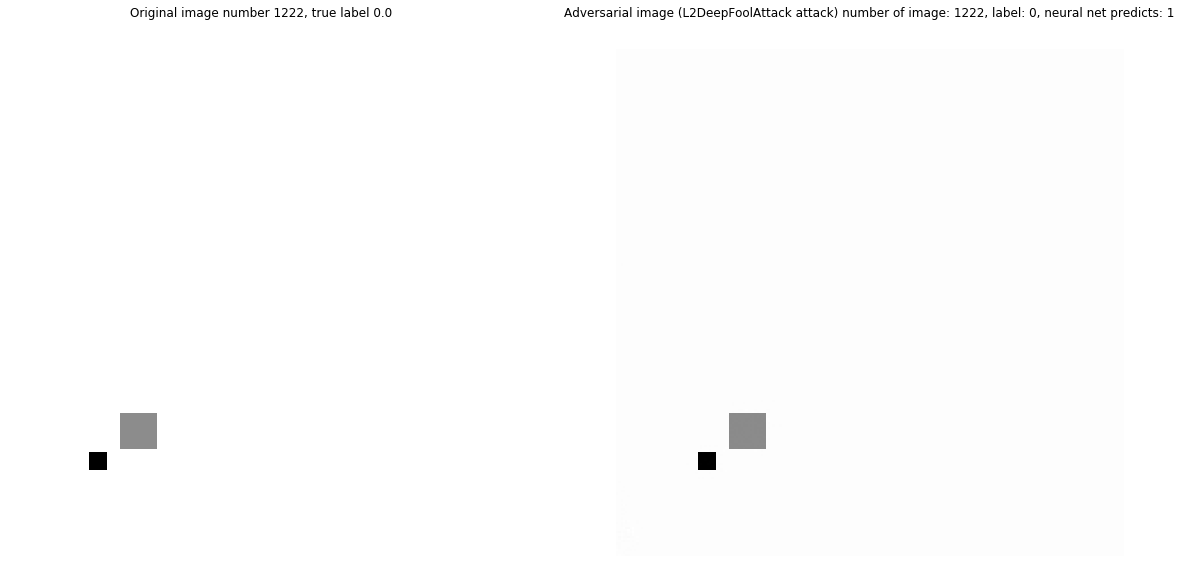

Image number 1222.
Image number 1223.
Image number 1224.
Image number 1225.
Image number 1226.
Image number 1227.
Image number 1228.
Image number 1229.
Image number 1231.
Image number 1232.
Image number 1233.
Image number 1234.
Image number 1235.
Image number 1236.
Image number 1237.
Image number 1238.
Image number 1239.
Image number 1240.
Image number 1241.
Image number 1242.
Image number 1243.
Image number 1244.
Image number 1245.
Image number 1246.
Image number 1247.
Image number 1248.
Image number 1250.
Image number 1251.
Image number 1252.
Image number 1253.
Image number 1254.
Image number 1255.
Image number 1256.
Image number 1257.
Image number 1258.
Image number 1259.
Image number 1260.
Image number 1261.
Image number 1262.
Image number 1264.
Image number 1265.
Image number 1266.
Image number 1267.
Image number 1268.
Image number 1269.
Image number 1270.
Image number 1271.
Image number 1272.
Image number 1273.
Image number 1275.
Image number 1276.
Image number 1278.
Image number

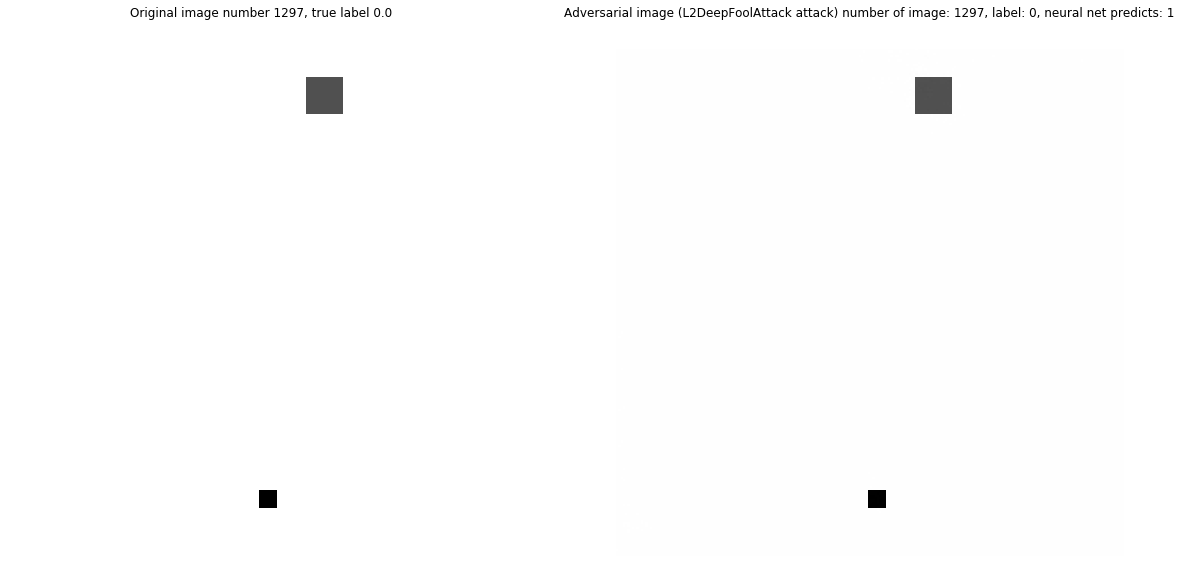

Image number 1297.
Image number 1298.
Image number 1300.
Image number 1301.
Image number 1302.
Image number 1303.
Image number 1304.
Image number 1305.
Image number 1306.
Image number 1307.
Image number 1308.
Image number 1309.
Image number 1310.
Image number 1311.
Image number 1313.
Image number 1314.
Image number 1315.
Image number 1316.
Image number 1317.
Image number 1318.
Image number 1320.
Image number 1321.
Image number 1322.
Image number 1323.
Image number 1324.
Image number 1325.
Image number 1326.
Image number 1327.
Image number 1328.
Image number 1329.
Image number 1330.
Image number 1331.
Image number 1332.
Image number 1333.
Image number 1334.
Image number 1335.
Image number 1336.
Image number 1337.
Image number 1338.
Image number 1339.
Image number 1340.
Image number 1341.
Image number 1342.
Image number 1344.
Image number 1345.
Image number 1346.
Image number 1347.
Image number 1348.
Image number 1349.
Image number 1350.
Image number 1351.
Image number 1352.
Image number

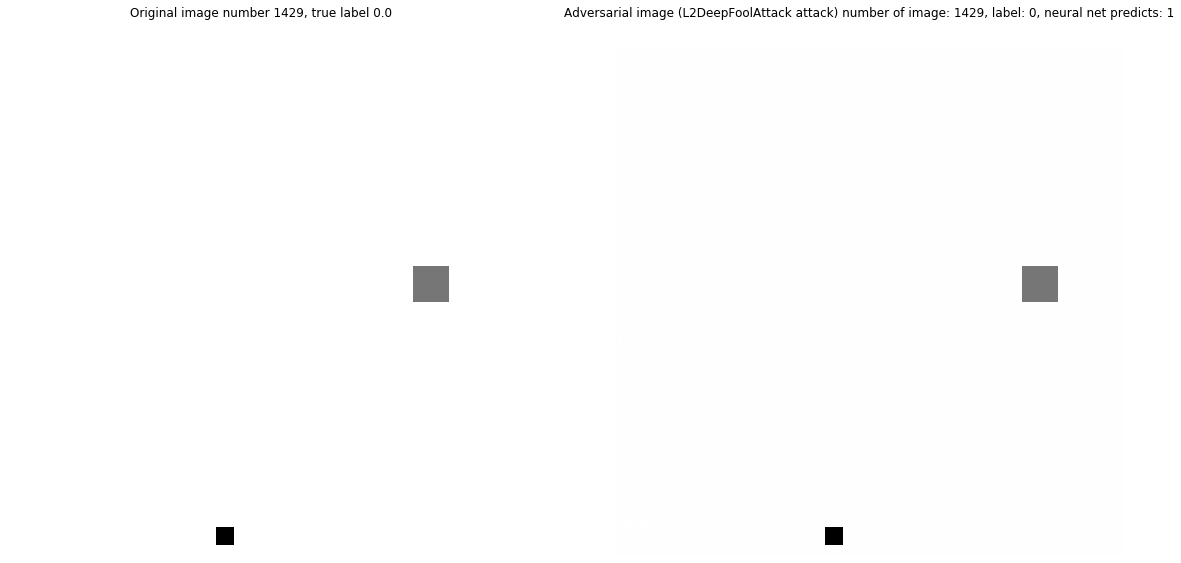

Image number 1430.
Image number 1431.
Image number 1432.
Image number 1433.
Image number 1434.
Image number 1435.
Image number 1436.


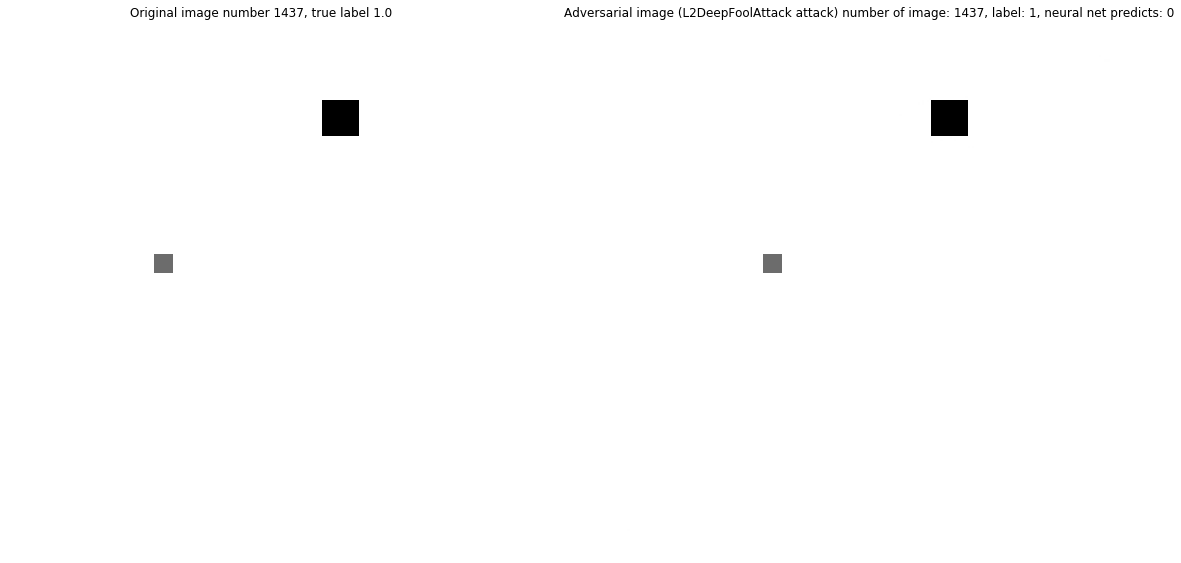

Image number 1437.
Image number 1438.
Image number 1439.
Image number 1440.
Image number 1441.
Image number 1442.
Image number 1443.
Image number 1444.
Image number 1445.
Image number 1446.
Image number 1447.
Image number 1448.
Image number 1449.
Image number 1450.
Image number 1451.
Image number 1452.
Image number 1453.
Image number 1454.
Image number 1455.
Image number 1456.
Image number 1457.
Image number 1458.
Image number 1459.
Image number 1460.
Image number 1461.
Image number 1462.


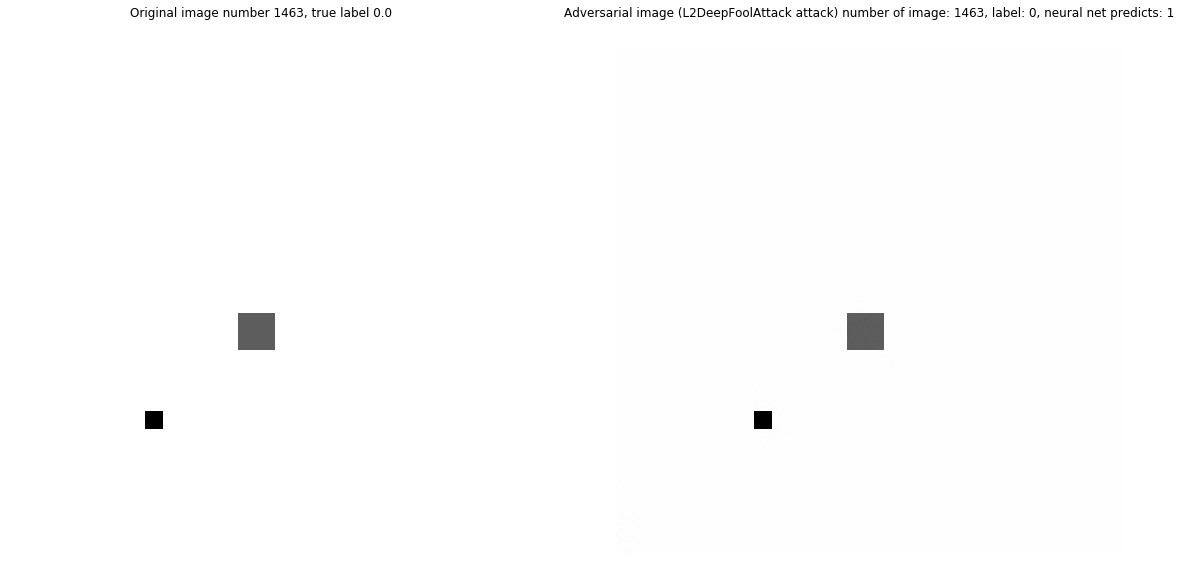

Image number 1463.
Image number 1464.
Image number 1465.
Image number 1466.
Image number 1467.
Image number 1468.
Image number 1469.
Image number 1470.
Image number 1471.
Image number 1472.
Image number 1474.
Image number 1475.
Image number 1476.
Image number 1477.
Image number 1479.
Image number 1480.
Image number 1482.
Image number 1483.
Image number 1484.
Image number 1485.
Image number 1486.
Image number 1487.
Image number 1488.
Image number 1489.
Image number 1490.
Image number 1491.
Image number 1492.
Image number 1493.
Image number 1494.
Image number 1496.


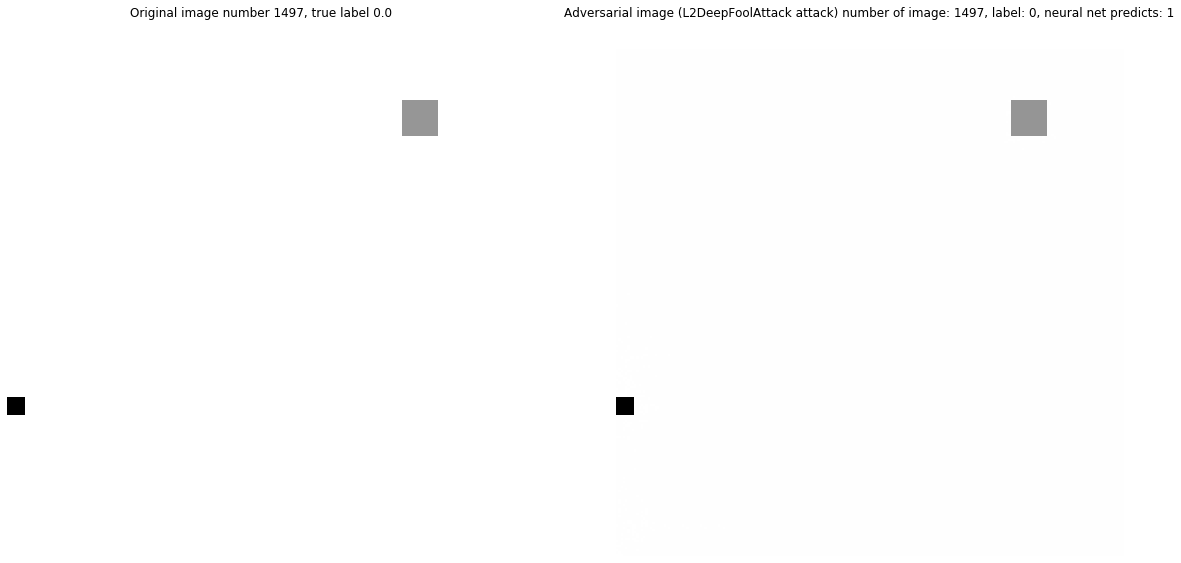

Image number 1497.
Image number 1498.
Image number 1499.
Image number 1500.


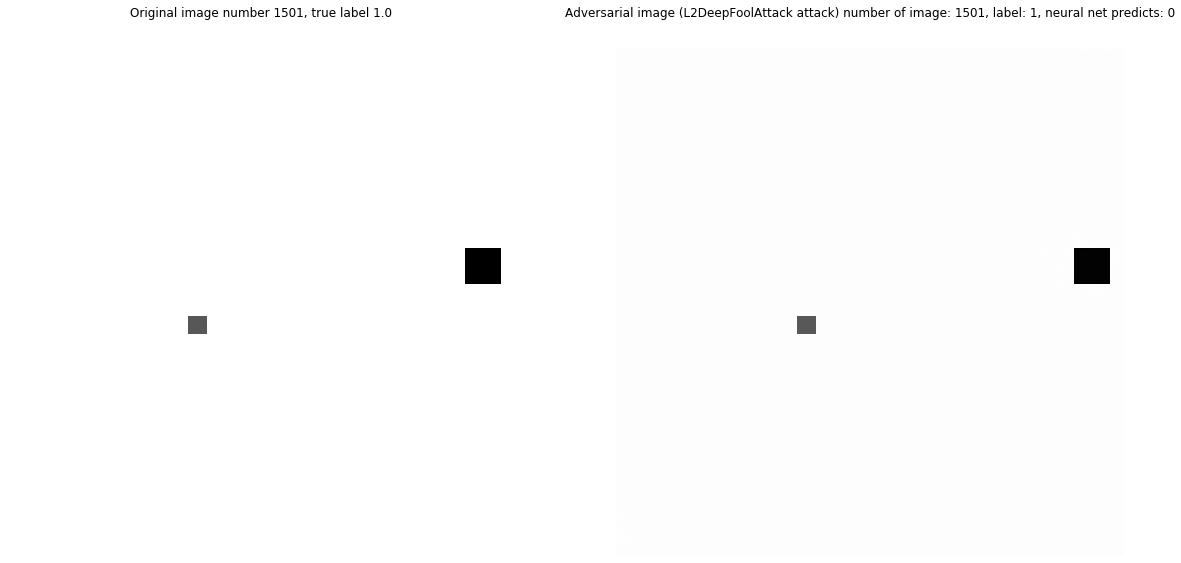

Image number 1501.
Image number 1502.
Image number 1503.
Image number 1504.
Image number 1505.
Image number 1506.
Image number 1507.
Image number 1508.


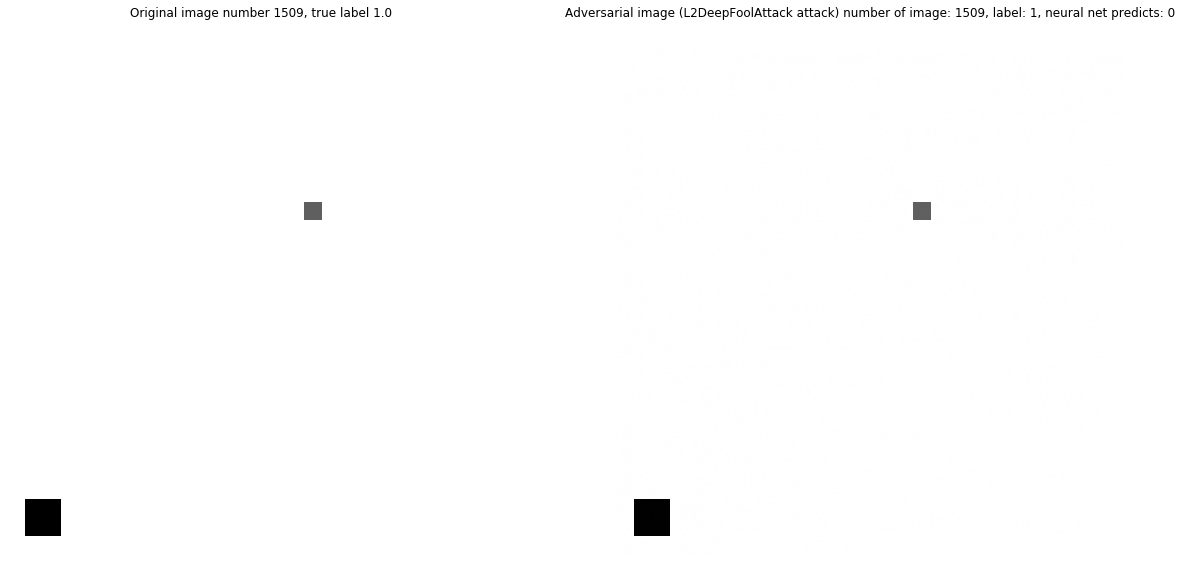

Image number 1509.
Image number 1510.
Image number 1511.
Image number 1512.
Image number 1513.
Image number 1514.
Image number 1515.


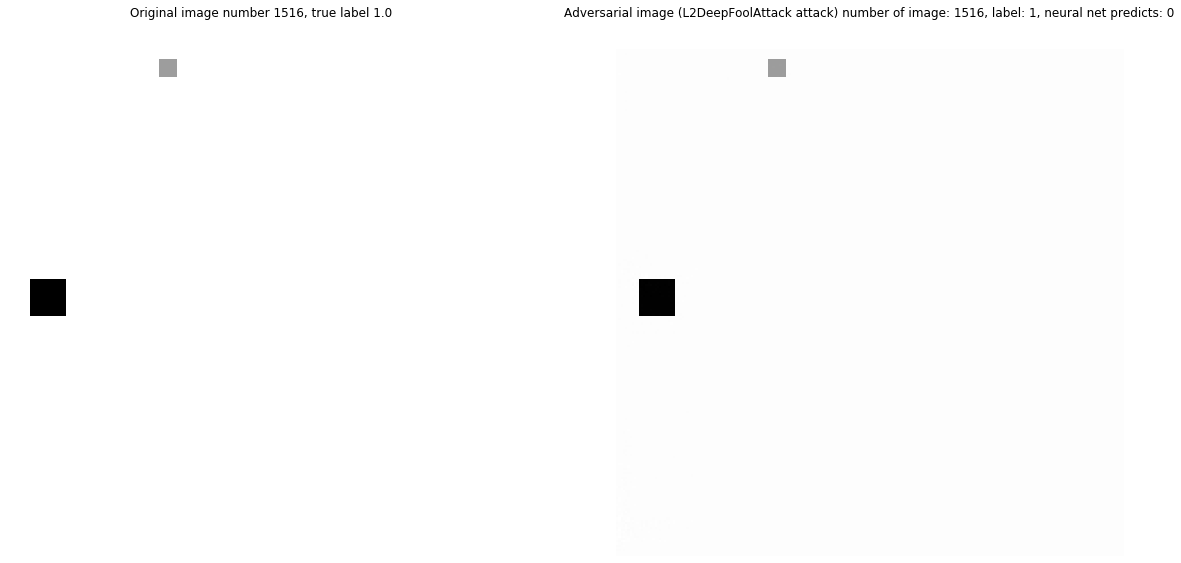

Image number 1516.
Image number 1517.
Image number 1518.


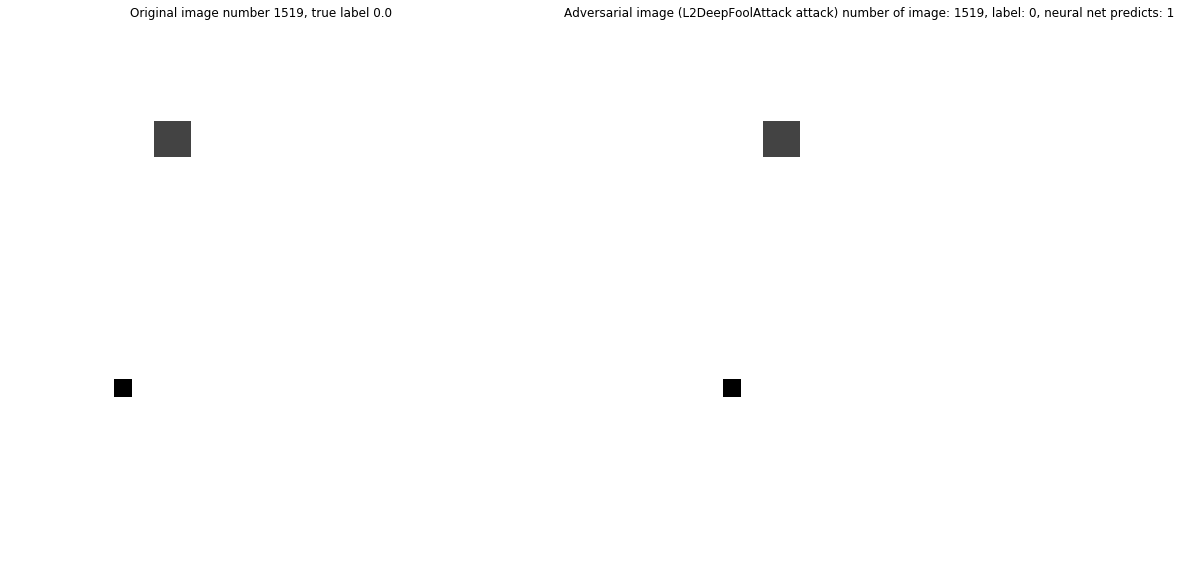

Image number 1520.
Image number 1522.
Image number 1523.


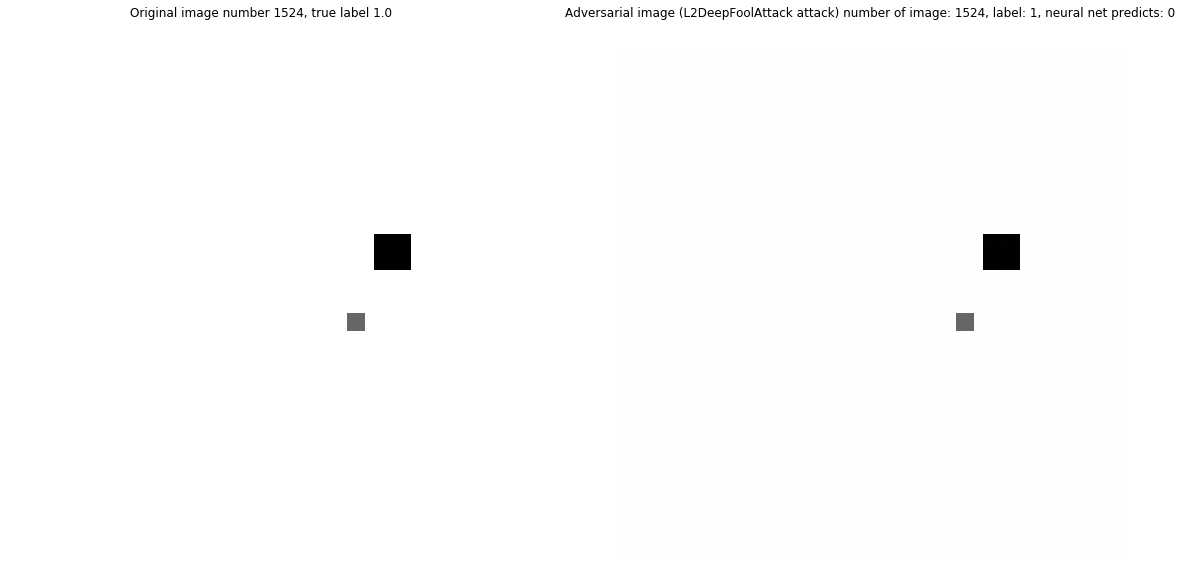

Image number 1524.
Image number 1526.


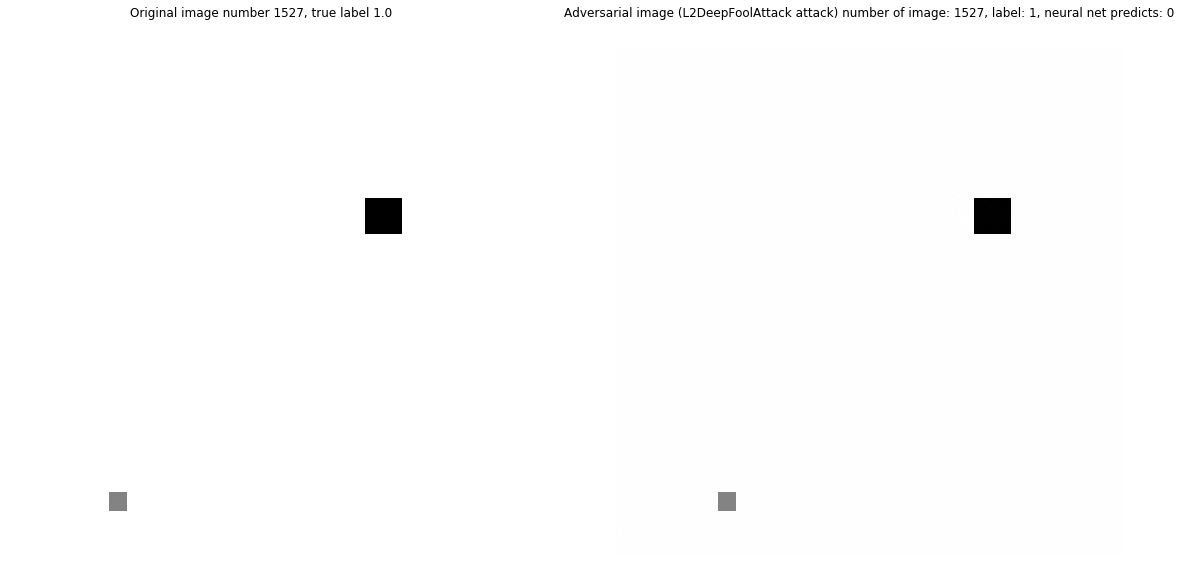

Image number 1527.
Image number 1529.
Image number 1530.
Image number 1531.
Image number 1532.
Image number 1533.
Image number 1534.
Image number 1535.
Image number 1537.
Image number 1538.
Image number 1540.
Image number 1541.
Image number 1542.
Image number 1543.
Image number 1544.
Image number 1545.
Image number 1546.
Image number 1547.
Image number 1548.
Image number 1549.
Image number 1550.
Image number 1551.
Image number 1552.
Image number 1553.
Image number 1554.
Image number 1555.
Image number 1556.
Image number 1557.
Image number 1558.
Image number 1559.
Image number 1560.
Image number 1562.
Image number 1563.
Image number 1564.
Image number 1565.
Image number 1566.
Image number 1567.
Image number 1568.
Image number 1569.
Image number 1570.
Image number 1571.
Image number 1572.
Image number 1574.
Image number 1575.


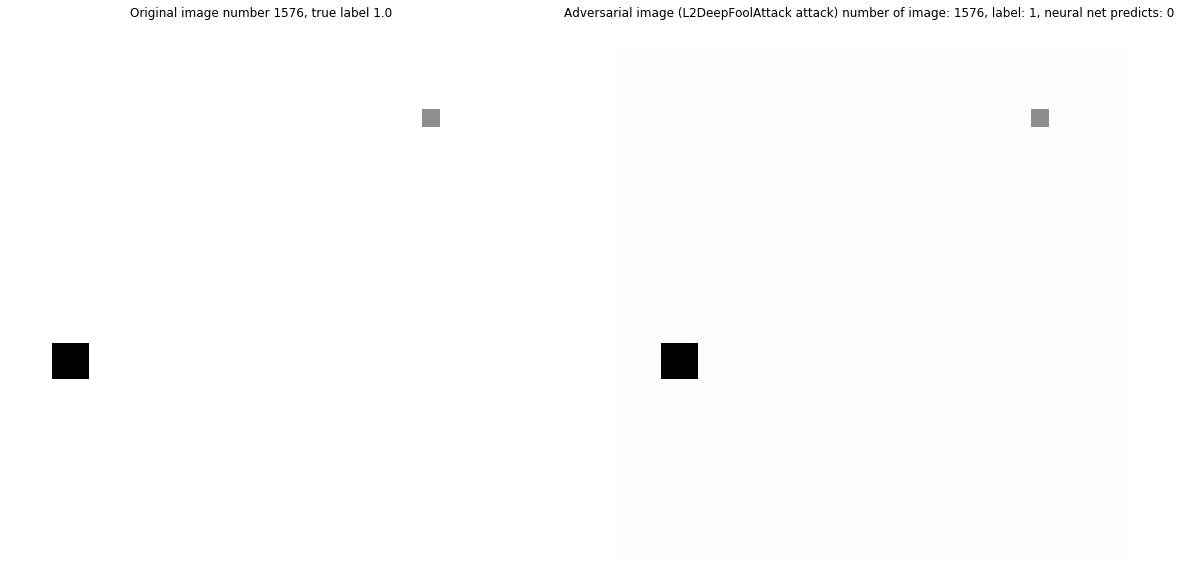

Image number 1576.
Image number 1577.
Image number 1578.
Image number 1579.
Image number 1580.


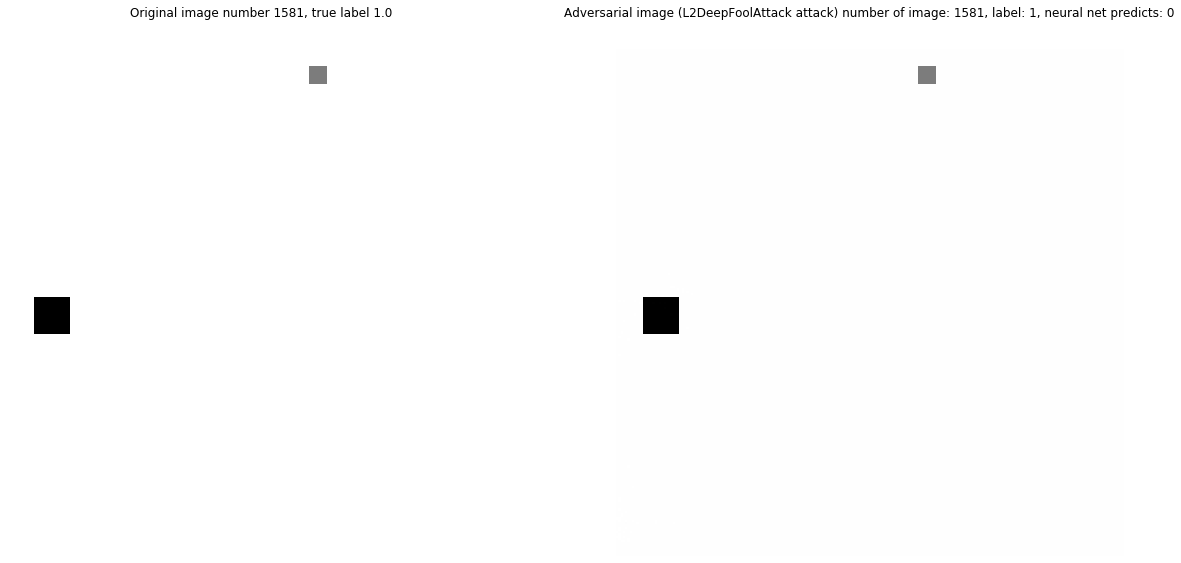

Image number 1581.
Image number 1582.
Image number 1583.
Image number 1584.
Image number 1585.
Image number 1586.
Image number 1587.


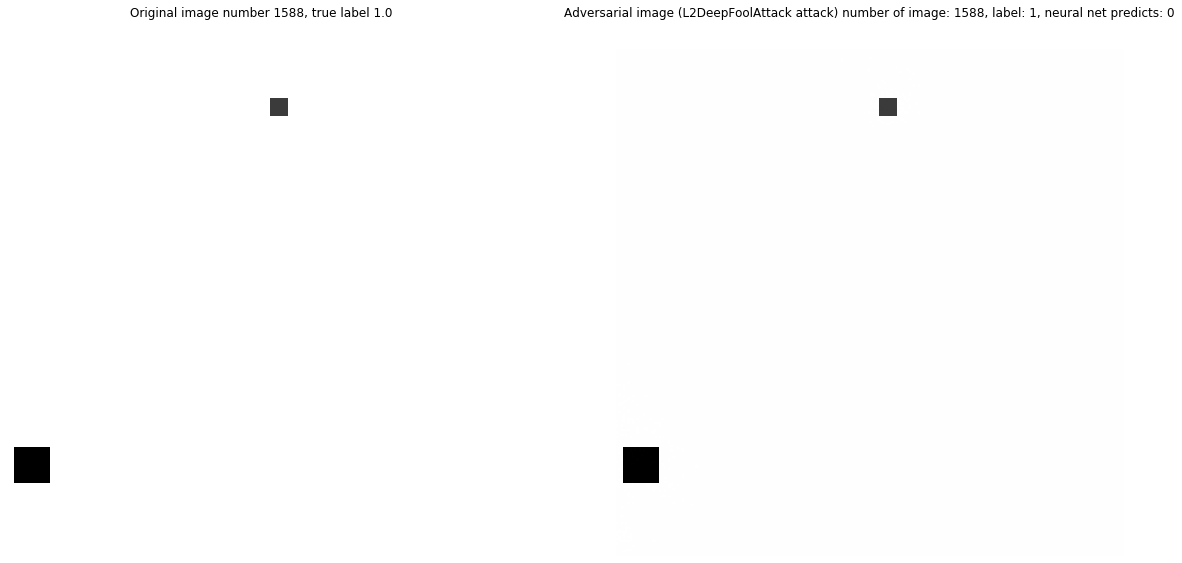

Image number 1589.
Image number 1590.
Image number 1591.
Image number 1592.
Image number 1593.
Image number 1594.
Image number 1595.
Image number 1596.
Image number 1597.
Image number 1598.
Image number 1600.
Image number 1601.
Image number 1602.
Image number 1603.
Image number 1604.
Image number 1605.
Image number 1606.
Image number 1607.
Image number 1608.
Image number 1609.
Image number 1610.
Image number 1611.
Image number 1612.
Image number 1613.
Image number 1614.
Image number 1615.
Image number 1617.
Image number 1618.
Image number 1619.
Image number 1620.
Image number 1621.
Image number 1622.
Image number 1623.
Image number 1625.
Image number 1626.
Image number 1627.
Image number 1628.
Image number 1629.
Image number 1630.
Image number 1631.
Image number 1632.
Image number 1633.
Image number 1634.
Image number 1635.
Image number 1636.
Image number 1637.
Image number 1638.
Image number 1639.
Image number 1640.
Image number 1641.
Image number 1642.
Image number 1643.
Image number

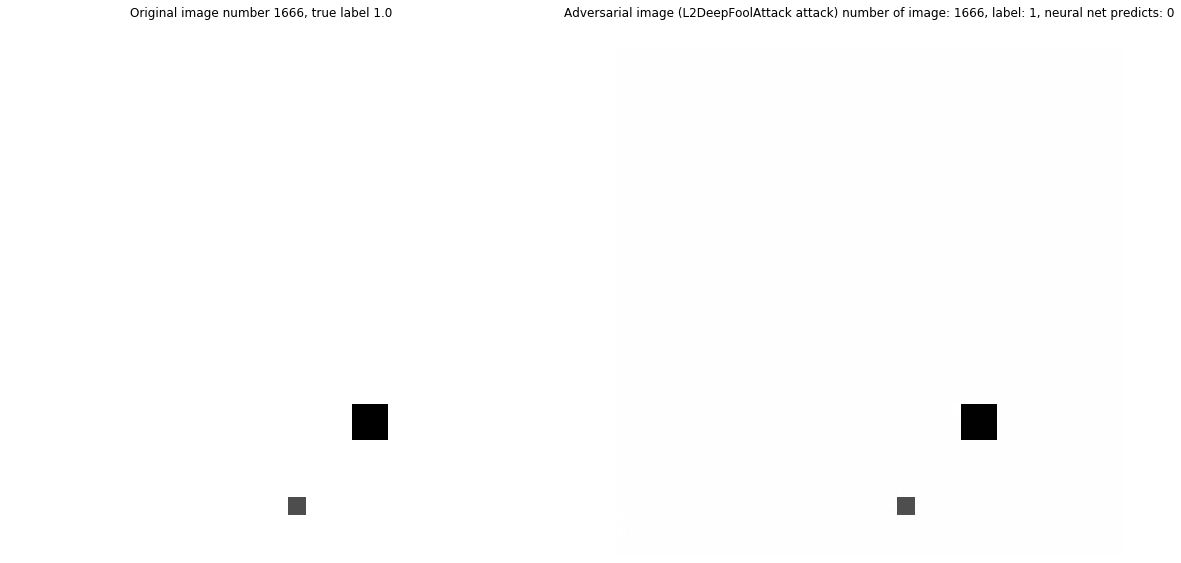

Image number 1666.
Image number 1667.
Image number 1668.
Image number 1669.
Image number 1670.
Image number 1671.
Image number 1672.
Image number 1673.
Image number 1674.


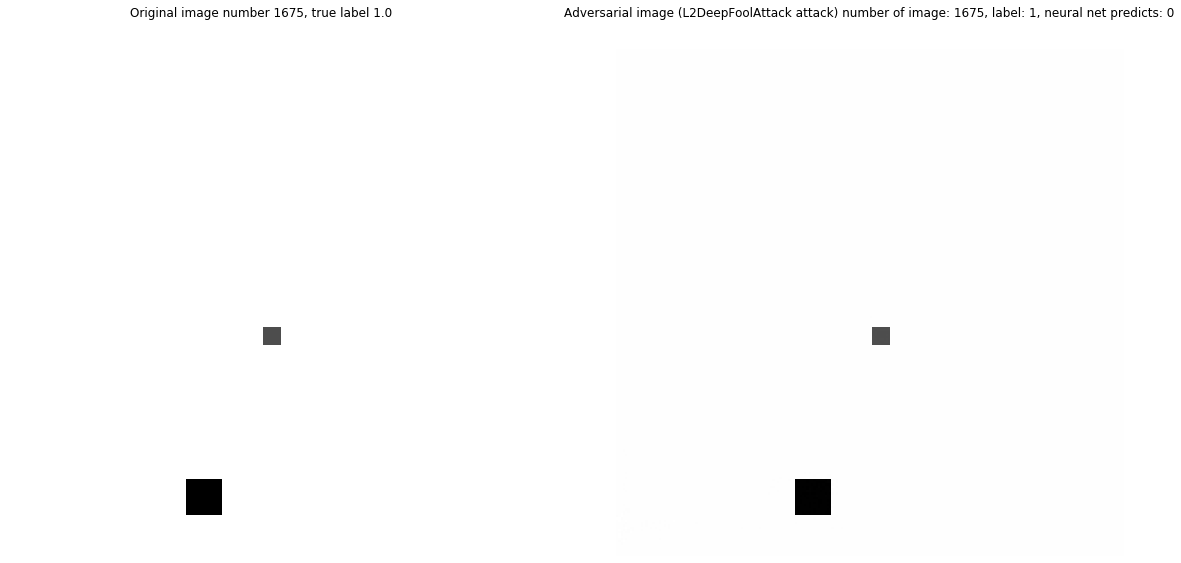

Image number 1675.
Image number 1676.
Image number 1677.
Image number 1678.
Image number 1679.
Image number 1680.
Image number 1681.
Image number 1683.
Image number 1684.
Image number 1685.
Image number 1686.
Image number 1687.
Image number 1688.
Image number 1689.
Image number 1690.
Image number 1691.
Image number 1692.
Image number 1694.
Image number 1695.
Image number 1696.
Image number 1697.
Image number 1698.
Image number 1699.
Image number 1700.
Image number 1701.
Image number 1702.
Image number 1703.


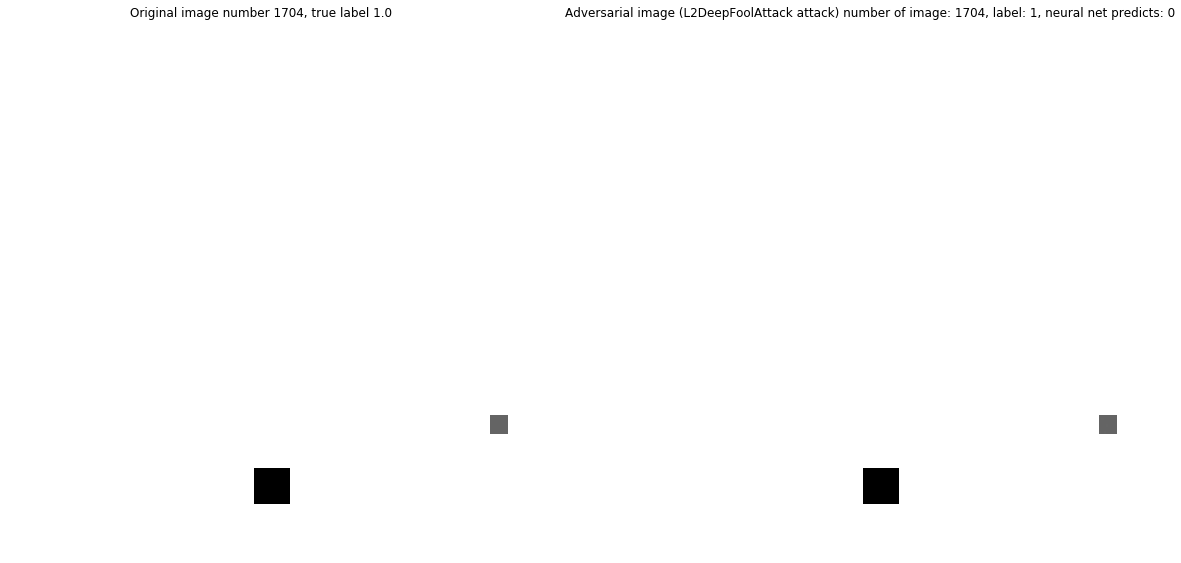

Image number 1704.
Image number 1705.
Image number 1706.
Image number 1707.
Image number 1708.
Image number 1709.
Image number 1710.
Image number 1711.
Image number 1712.
Image number 1713.
Image number 1714.
Image number 1715.
Image number 1716.
Image number 1717.
Image number 1718.
Image number 1719.
Image number 1720.
Image number 1721.
Image number 1723.
Image number 1724.
Image number 1725.
Image number 1726.
Image number 1727.
Image number 1728.
Image number 1729.
Image number 1730.
Image number 1731.
Image number 1732.
Image number 1733.
Image number 1734.
Image number 1735.
Image number 1736.
Image number 1737.
Image number 1738.
Image number 1739.
Image number 1740.
Image number 1741.
Image number 1742.
Image number 1743.
Image number 1744.
Image number 1747.
Image number 1749.
Image number 1750.
Image number 1751.
Image number 1752.
Image number 1753.
Image number 1754.
Image number 1755.
Image number 1756.
Image number 1757.
Image number 1759.
Image number 1760.
Image number

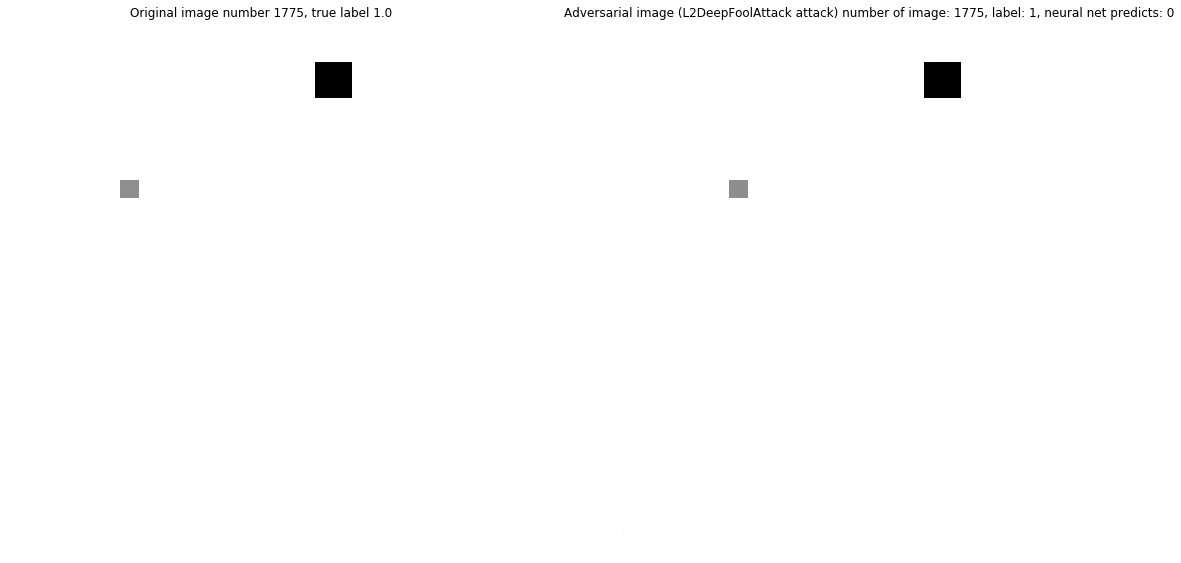

Image number 1775.
Image number 1776.
Image number 1778.
Image number 1779.
Image number 1780.
Image number 1781.
Image number 1782.
Image number 1783.
Image number 1784.
Image number 1785.
Image number 1786.
Image number 1787.
Image number 1788.
Image number 1789.
Image number 1790.
Image number 1791.
Image number 1792.
Image number 1793.
Image number 1794.
Image number 1795.
Image number 1796.
Image number 1797.
Image number 1798.
Image number 1799.
Image number 1800.
Image number 1801.
Image number 1803.
Image number 1804.
Image number 1805.
Image number 1806.
Image number 1807.
Image number 1808.
Image number 1809.
Image number 1810.
Image number 1811.
Image number 1812.
Image number 1813.
Image number 1814.
Image number 1815.
Image number 1816.
Image number 1818.
Image number 1819.
Image number 1820.
Image number 1821.
Image number 1822.
Image number 1823.
Image number 1824.
Image number 1825.
Image number 1826.
Image number 1827.
Image number 1828.
Image number 1829.
Image number

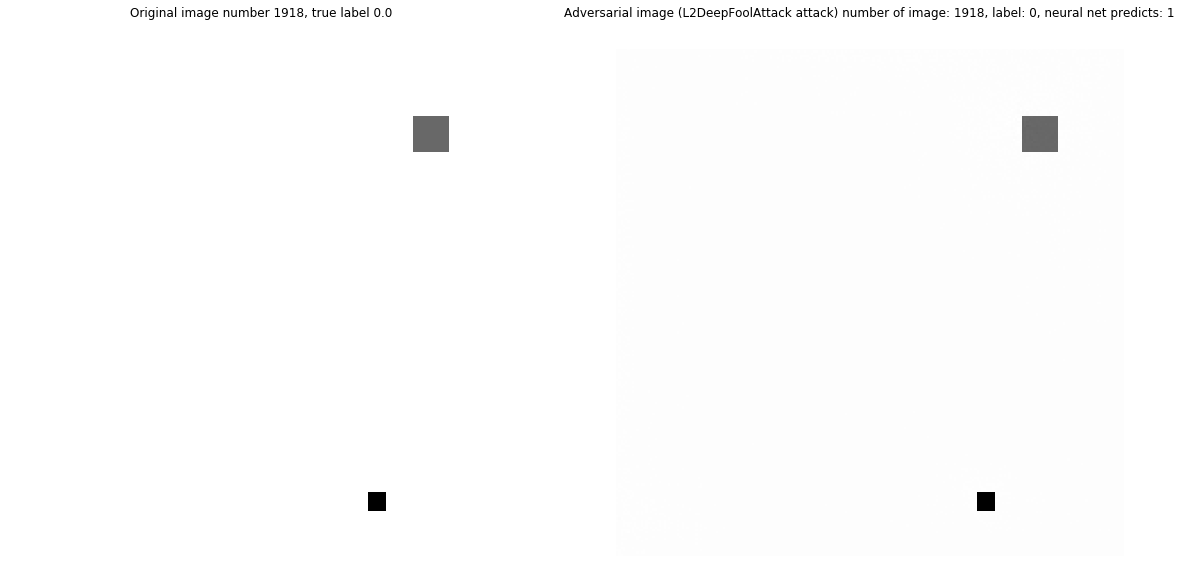

Image number 1918.
Image number 1919.
Image number 1920.
Image number 1921.
Image number 1922.
Image number 1923.
Image number 1924.
Image number 1925.
Image number 1926.
Image number 1927.
Image number 1928.
Image number 1929.
Image number 1930.
Image number 1931.
Image number 1932.
Image number 1933.
Image number 1934.
Image number 1935.
Image number 1936.
Image number 1937.
Image number 1938.
Image number 1939.
Image number 1940.
Image number 1941.
Image number 1942.
Image number 1943.
Image number 1944.
Image number 1945.
Image number 1946.
Image number 1947.
Image number 1948.
Image number 1949.
Image number 1950.
Image number 1951.
Image number 1952.
Image number 1953.
Image number 1954.
Image number 1955.
Image number 1956.
Image number 1957.
Image number 1958.
Image number 1959.
Image number 1960.
Image number 1961.
Image number 1962.
Image number 1963.
Image number 1965.
Image number 1966.
Image number 1967.
Image number 1968.
Image number 1969.
Image number 1970.
Image number

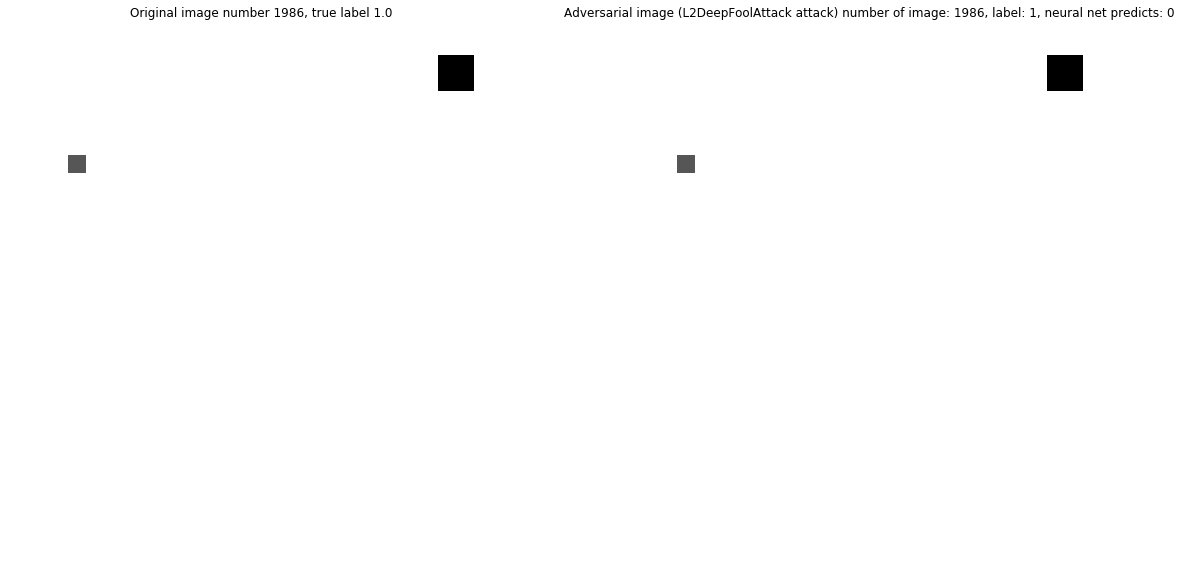

Image number 1986.
Image number 1987.
Image number 1989.
Image number 1990.
Image number 1991.
Image number 1992.
Image number 1993.
Image number 1994.
Image number 1995.
Image number 1996.
Image number 1997.
Image number 1998.
Image number 1999.
Image number 2000.
Image number 2001.


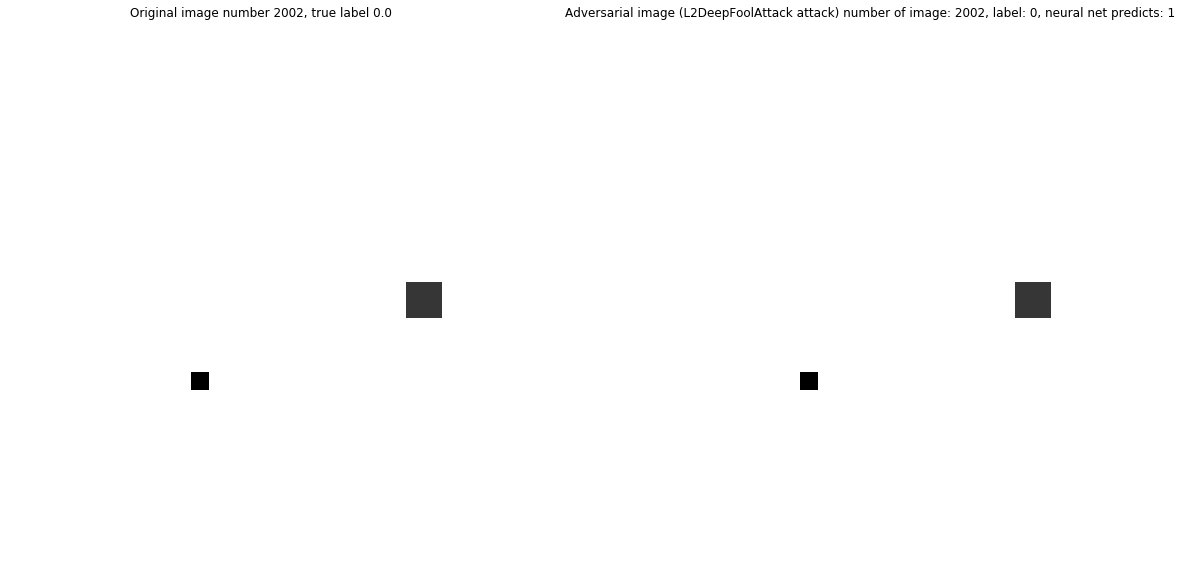

Image number 2002.
Image number 2004.
Image number 2005.
Image number 2006.
Image number 2007.
Image number 2008.
Image number 2009.
Image number 2010.
Image number 2011.
Image number 2012.
Image number 2013.
Image number 2015.
Image number 2016.


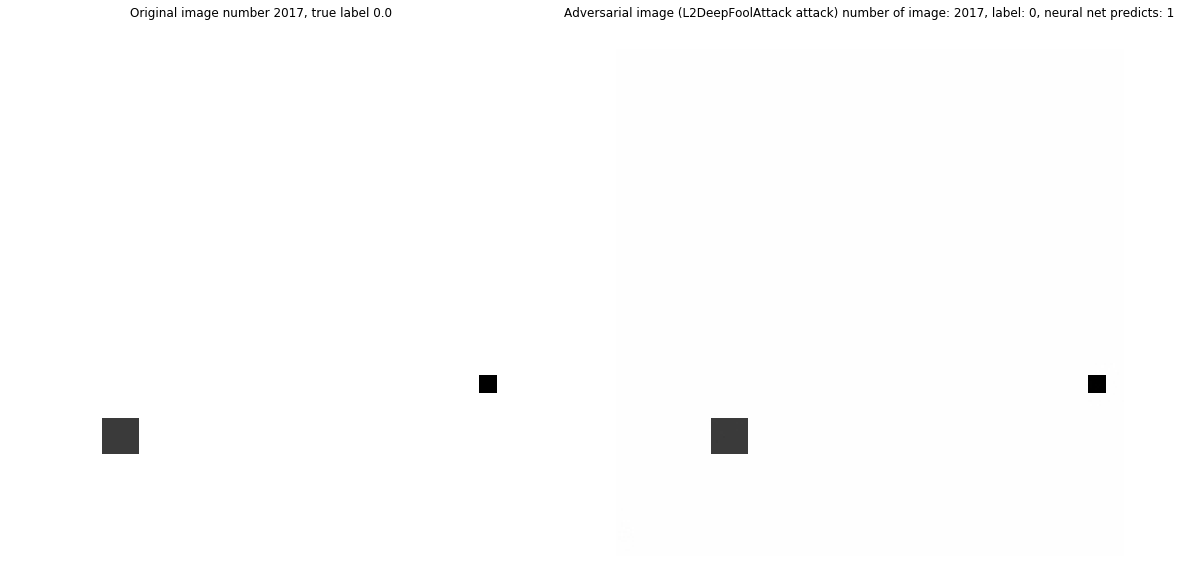

Image number 2017.
Image number 2018.
Image number 2019.
Image number 2020.
Image number 2021.
Image number 2022.
Image number 2023.
Image number 2024.
Image number 2025.
Image number 2026.
Image number 2027.
Image number 2028.
Image number 2030.
Image number 2031.
Image number 2032.
Image number 2033.
Image number 2034.
Image number 2035.
Image number 2036.
Image number 2037.
Image number 2038.
Image number 2039.
Image number 2040.
Image number 2041.
Image number 2042.
Image number 2043.
Image number 2044.
Image number 2045.
Image number 2046.
Image number 2047.
Image number 2048.
Image number 2049.
Image number 2050.
Image number 2051.
Image number 2052.
Image number 2053.


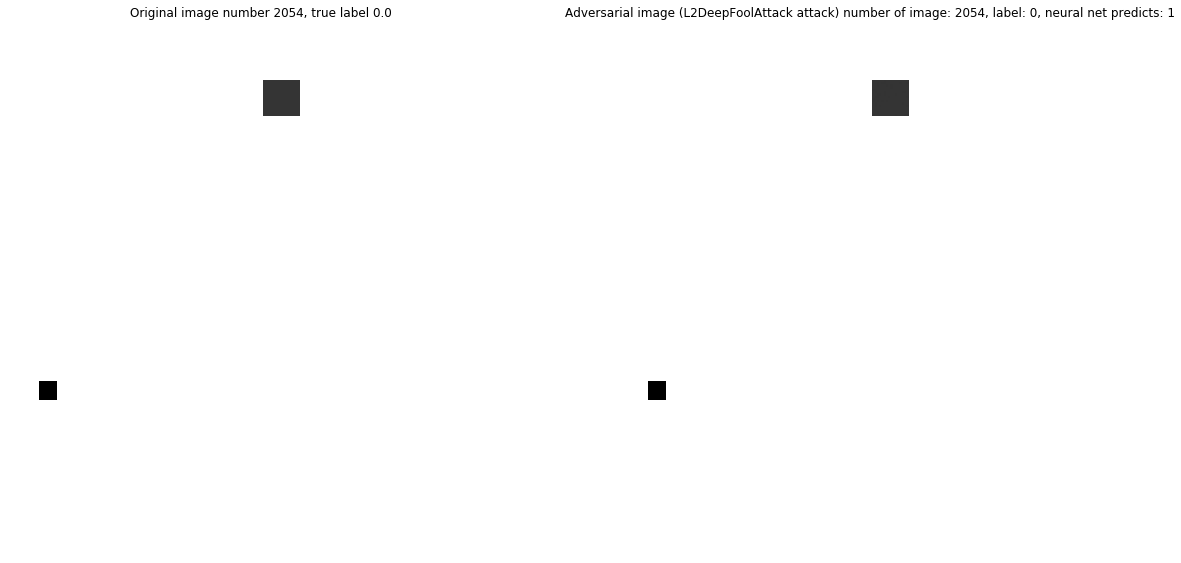

Image number 2054.
Image number 2055.
Image number 2056.
Image number 2057.
Image number 2058.
Image number 2059.
Image number 2060.
Image number 2061.
Image number 2062.
Image number 2063.
Image number 2064.
Image number 2065.
Image number 2066.
Image number 2067.
Image number 2068.
Image number 2069.
Image number 2070.
Image number 2071.
Image number 2072.
Image number 2074.
Image number 2075.
Image number 2076.
Image number 2077.
Image number 2078.
Image number 2079.
Image number 2080.
Image number 2081.
Image number 2082.
Image number 2083.
Image number 2084.
Image number 2085.


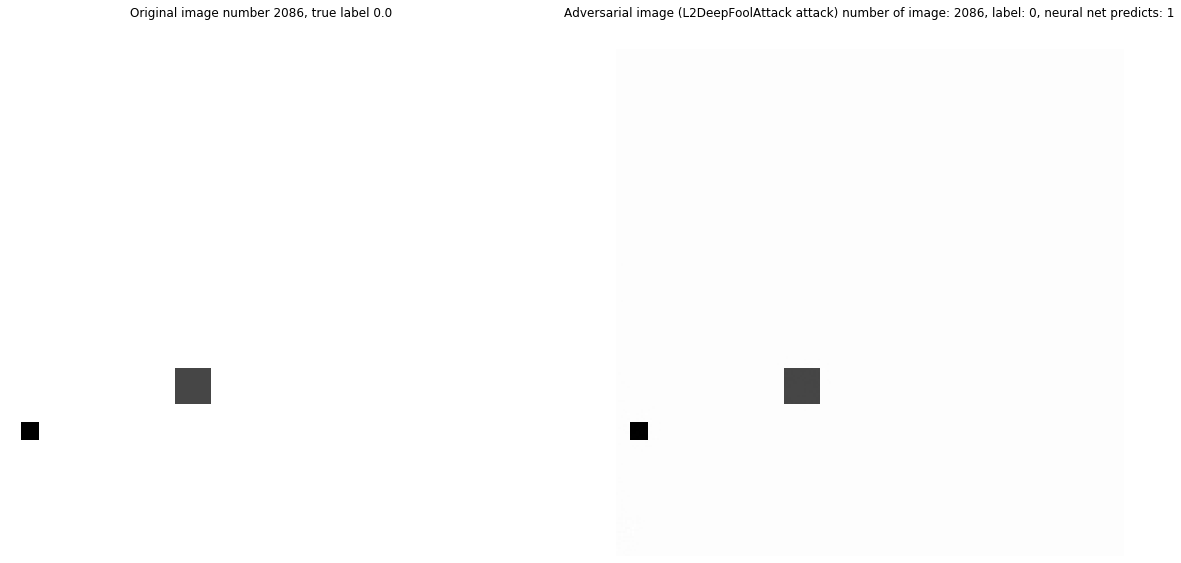

Image number 2087.
Image number 2088.
Image number 2089.
Image number 2090.
Image number 2091.
Image number 2092.


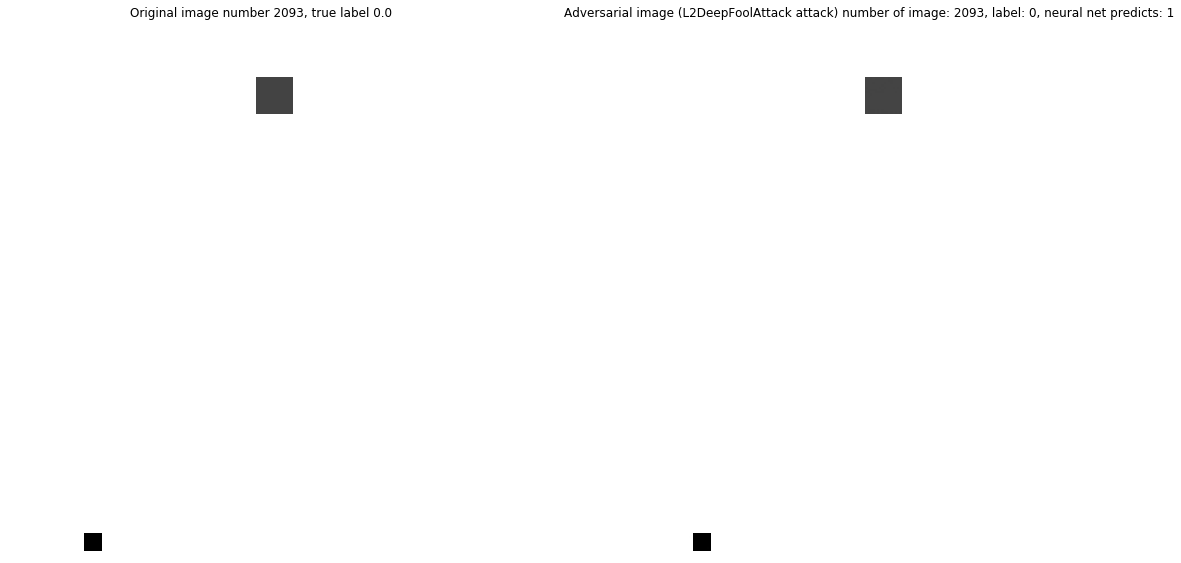

Image number 2095.
Image number 2096.
Image number 2097.
Image number 2098.
Image number 2099.
Image number 2100.
Image number 2102.
Image number 2103.
Image number 2104.
Image number 2106.
Image number 2107.
Image number 2108.
Image number 2110.
Image number 2111.
Image number 2112.
Image number 2113.
Image number 2114.
Image number 2115.
Image number 2116.
Image number 2118.
Image number 2119.
Image number 2120.
Image number 2121.
Image number 2122.
Image number 2123.
Image number 2124.
Image number 2125.
Image number 2126.
Image number 2127.
Image number 2128.
Image number 2129.
Image number 2130.
Image number 2131.
Image number 2132.
Image number 2133.
Image number 2134.
Image number 2135.
Image number 2136.
Image number 2137.
Image number 2138.
Image number 2139.


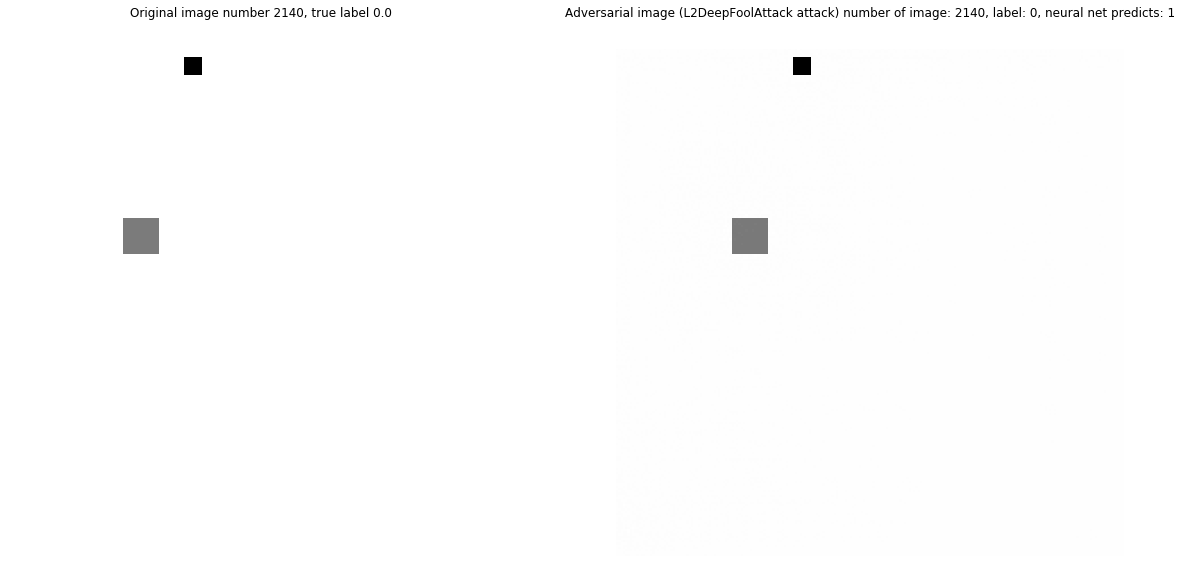

Image number 2140.
Image number 2141.
Image number 2142.
Image number 2144.
Image number 2145.
Image number 2146.
Image number 2147.
Image number 2148.
Image number 2149.
Image number 2150.
Image number 2151.
Image number 2152.
Image number 2153.
Image number 2154.
Image number 2155.
Image number 2156.
Image number 2157.
Image number 2158.
Image number 2159.
Image number 2160.
Image number 2161.
Image number 2162.
Image number 2164.
Image number 2165.
Image number 2166.
Image number 2167.
Image number 2168.
Image number 2169.
Image number 2170.


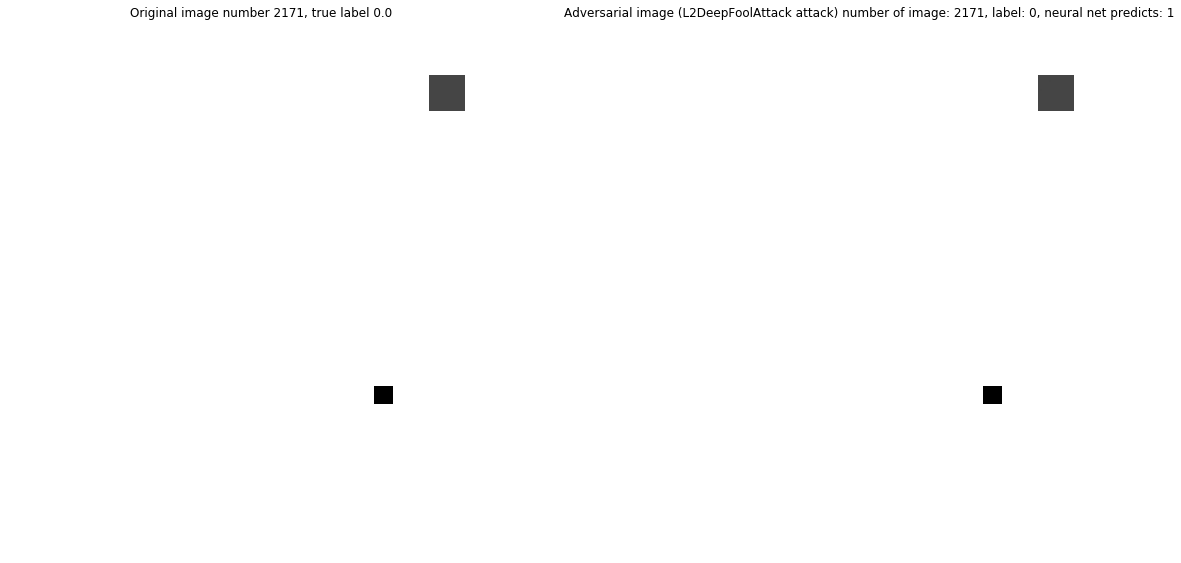

Image number 2171.
Image number 2172.
Image number 2173.
Image number 2174.
Image number 2176.
Image number 2177.
Image number 2178.
Image number 2179.
Image number 2180.
Image number 2181.
Image number 2182.
Image number 2183.
Image number 2184.
Image number 2185.
Image number 2186.
Image number 2187.
Image number 2188.
Image number 2189.
Image number 2190.
Image number 2191.
Image number 2193.


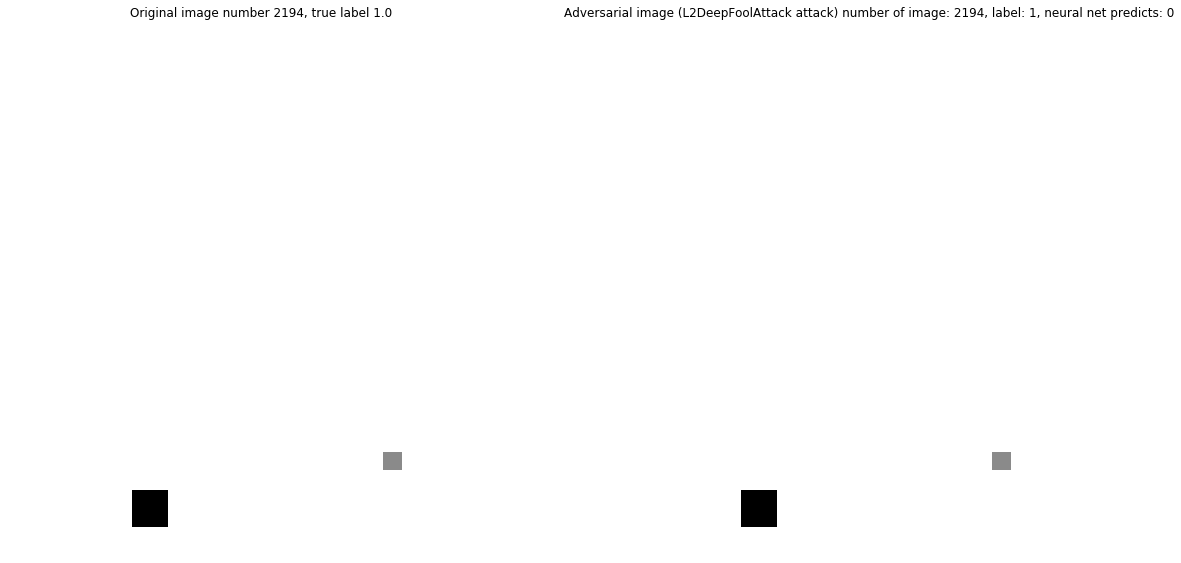

Image number 2194.
Image number 2195.
Image number 2196.
Image number 2197.
Image number 2198.
Image number 2199.
Image number 2200.
Image number 2201.
Image number 2202.
Image number 2203.
Image number 2204.
Image number 2205.
Image number 2206.
Image number 2207.
Image number 2208.
Image number 2209.
Image number 2210.
Image number 2211.
Image number 2212.
Image number 2213.
Image number 2214.
Image number 2215.
Image number 2216.


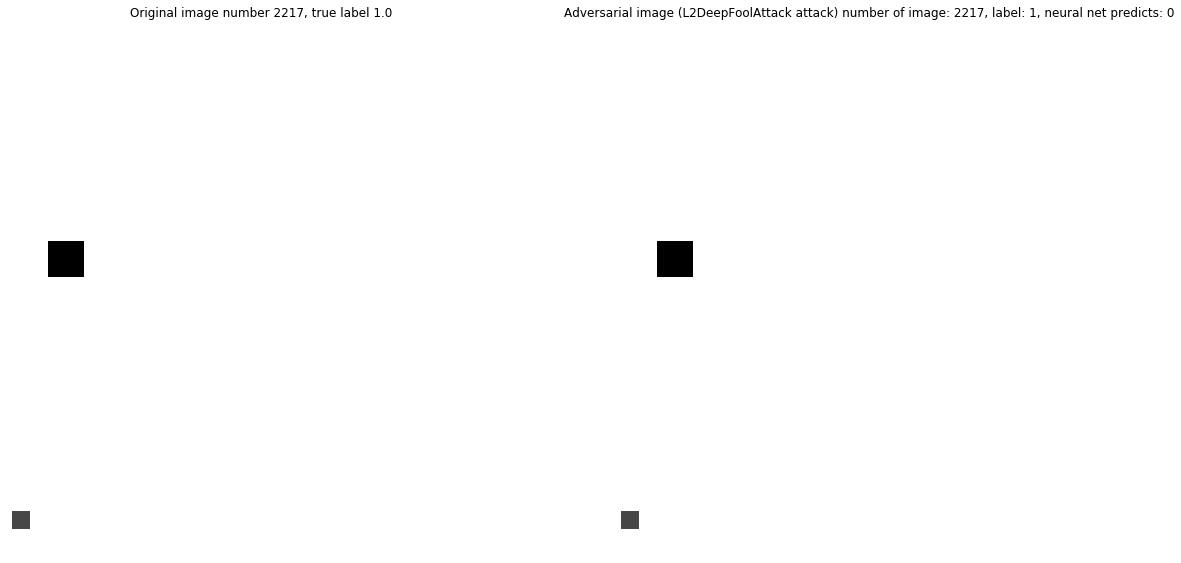

Image number 2217.
Image number 2218.
Image number 2219.
Image number 2220.
Image number 2221.
Image number 2222.
Image number 2223.
Image number 2224.
Image number 2225.
Image number 2226.
Image number 2227.
Image number 2228.
Image number 2229.
Image number 2230.
Image number 2231.
Image number 2232.
Image number 2233.


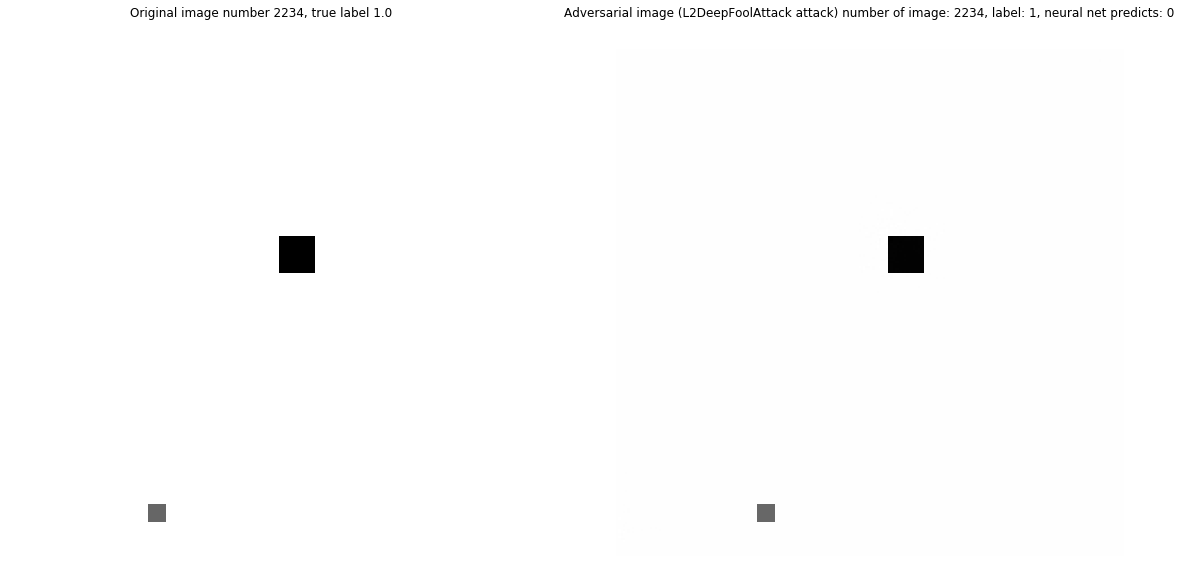

Image number 2234.
Image number 2235.
Image number 2237.
Image number 2238.
Image number 2239.
Image number 2240.
Image number 2241.
Image number 2242.
Image number 2243.
Image number 2244.
Image number 2245.
Image number 2246.
Image number 2247.
Image number 2248.
Image number 2249.
Image number 2250.
Image number 2251.
Image number 2252.
Image number 2253.
Image number 2254.
Image number 2255.
Image number 2256.
Image number 2257.
Image number 2258.
Image number 2259.
Image number 2260.
Image number 2261.
Image number 2262.
Image number 2263.
Image number 2264.
Image number 2265.
Image number 2266.
Image number 2267.
Image number 2268.
Image number 2269.
Image number 2270.


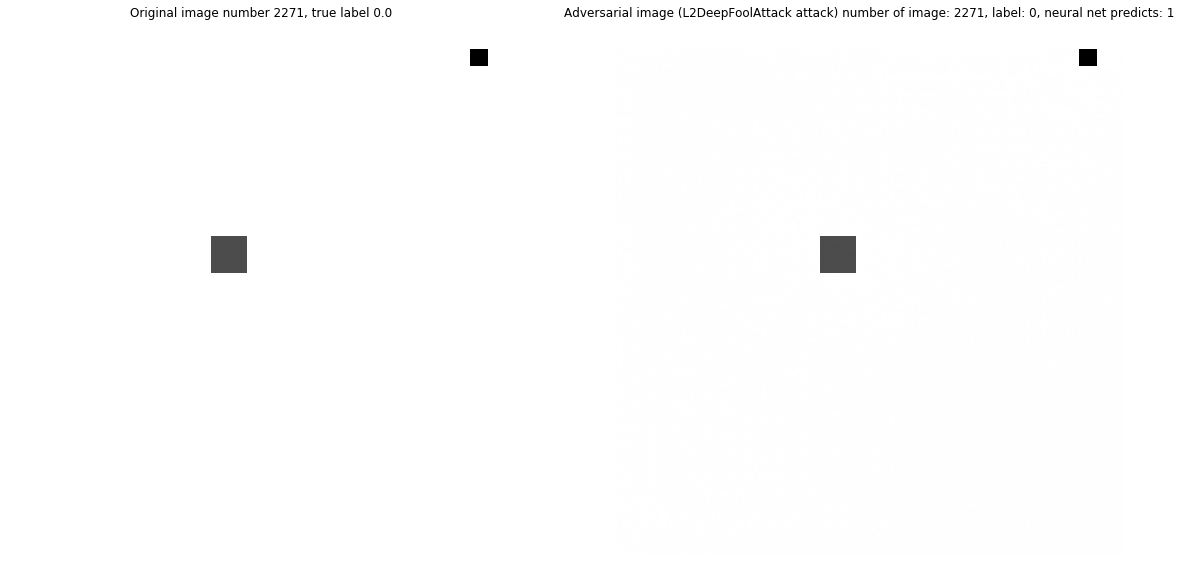

Image number 2271.
Image number 2272.
Image number 2273.
Image number 2274.
Image number 2275.


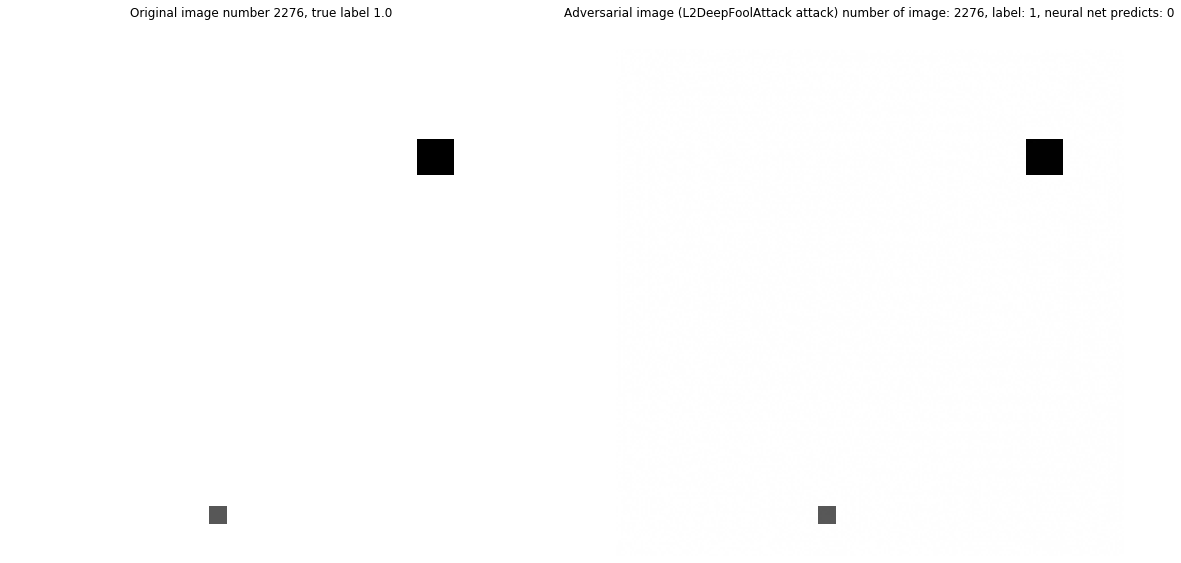

Image number 2276.
Image number 2277.
Image number 2278.
Image number 2279.
Image number 2280.
Image number 2281.
Image number 2282.
Image number 2283.
Image number 2284.
Image number 2285.
Image number 2286.
Image number 2287.
Image number 2288.
Image number 2289.
Image number 2290.
Image number 2291.


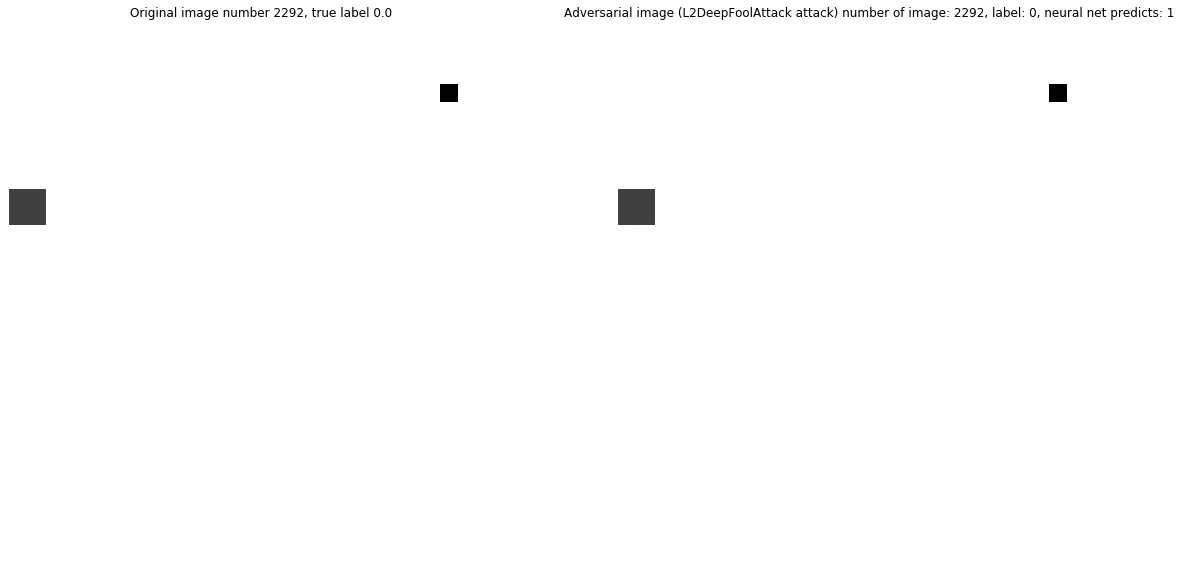

Image number 2292.
Image number 2293.
Image number 2294.
Image number 2295.
Image number 2296.
Image number 2297.
Image number 2298.
Image number 2299.
Image number 2300.
Image number 2301.
Image number 2302.
Image number 2303.
Image number 2305.
Image number 2306.
Image number 2307.
Image number 2308.
Image number 2309.
Image number 2310.
Image number 2311.
Image number 2312.
Image number 2313.
Image number 2314.
Image number 2315.
Image number 2316.
Image number 2317.
Image number 2318.
Image number 2319.
Image number 2320.
Image number 2321.
Image number 2322.
Image number 2323.
Image number 2325.
Image number 2326.
Image number 2327.
Image number 2328.
Image number 2329.
Image number 2330.
Image number 2331.
Image number 2333.
Image number 2334.
Image number 2335.
Image number 2336.
Image number 2337.
Image number 2338.
Image number 2339.
Image number 2340.
Image number 2341.
Image number 2342.
Image number 2343.
Image number 2344.
Image number 2345.
Image number 2346.
Image number

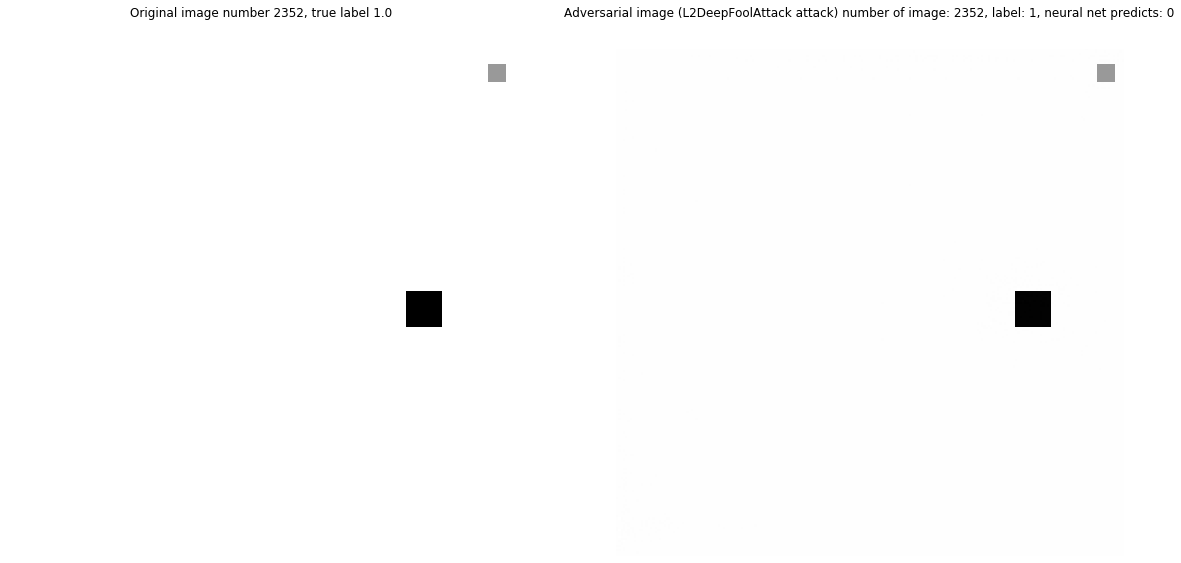

Image number 2352.
Image number 2353.
Image number 2354.
Image number 2355.
Image number 2357.


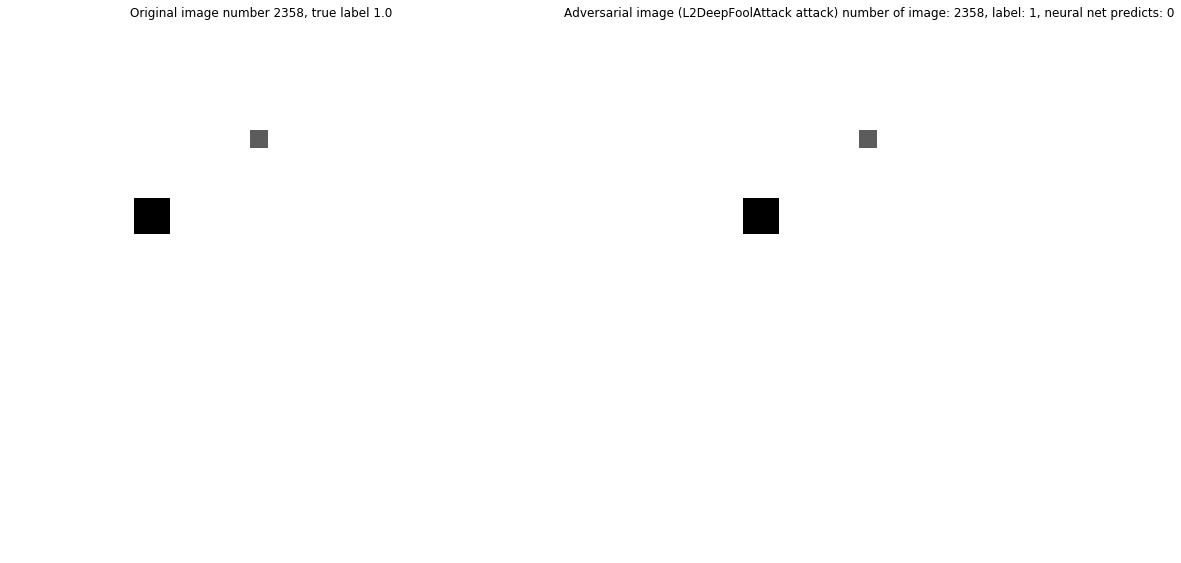

Image number 2358.
Image number 2359.
Image number 2360.
Image number 2361.
Image number 2362.
Image number 2363.


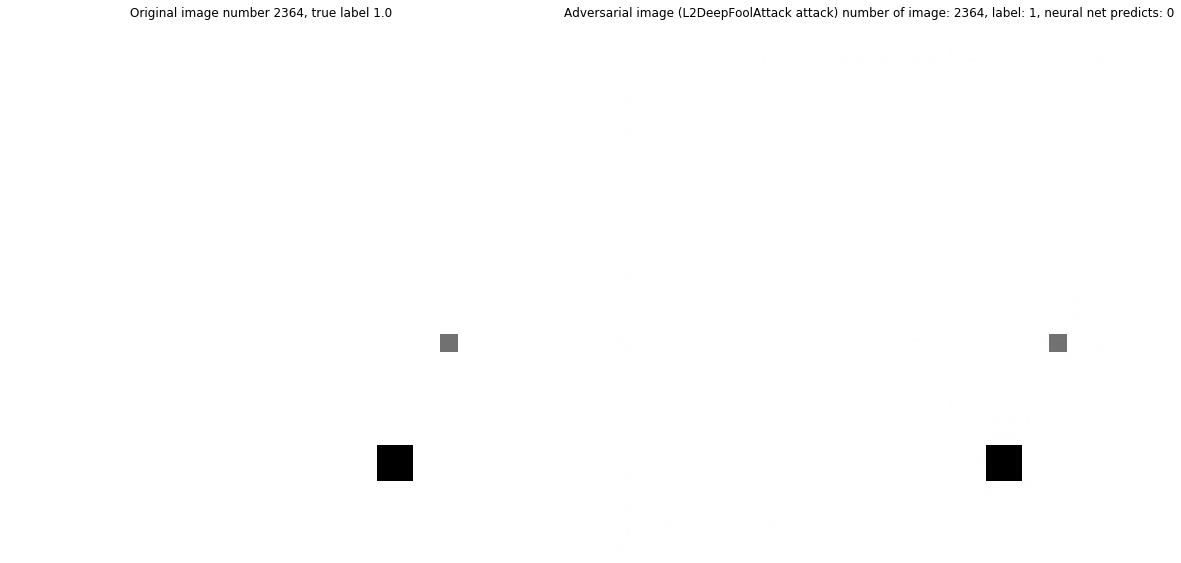

Image number 2364.
Image number 2365.


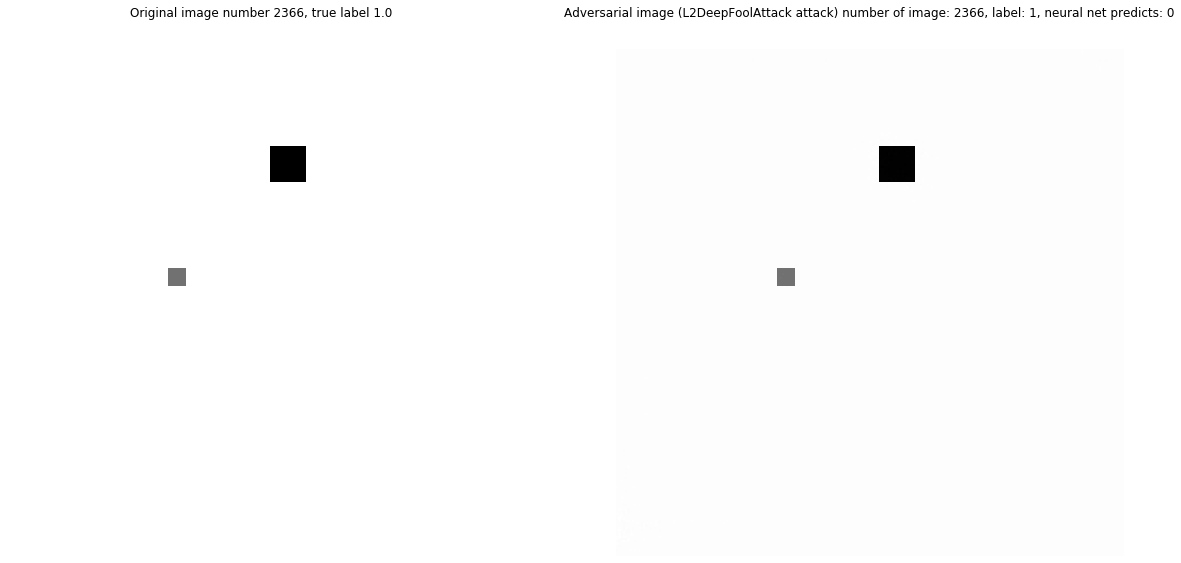

Image number 2366.
Image number 2367.
Image number 2368.
Image number 2369.
Image number 2370.
Image number 2371.
Image number 2372.
Image number 2373.
Image number 2374.
Image number 2375.
Image number 2376.
Image number 2377.
Image number 2378.
Image number 2379.
Image number 2380.
Image number 2381.
Image number 2382.
Image number 2383.
Image number 2384.
Image number 2385.
Image number 2386.
Image number 2387.
Image number 2388.
Image number 2389.
Image number 2390.
Image number 2391.
Image number 2392.


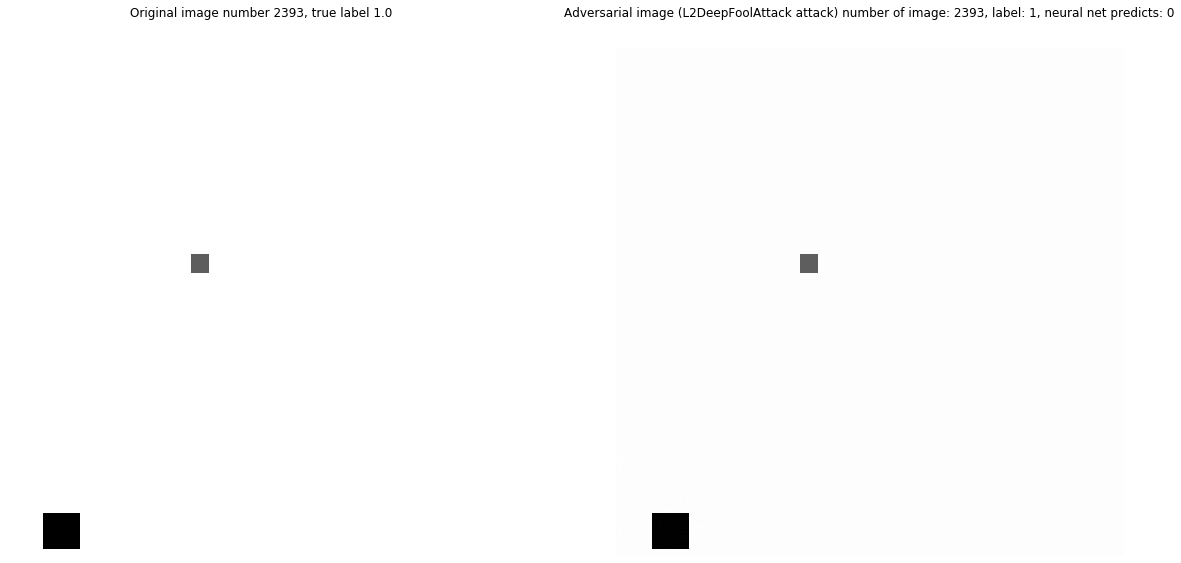

Image number 2393.
Image number 2394.
Image number 2395.
Image number 2396.
Image number 2397.
Image number 2398.
Image number 2399.
Image number 2400.
Image number 2401.
Image number 2402.
Image number 2403.
Image number 2404.
Image number 2405.
Image number 2406.
Image number 2407.
Image number 2408.
Image number 2409.
Image number 2410.
Image number 2411.
Image number 2412.
Image number 2413.
Image number 2414.
Image number 2415.
Image number 2417.
Image number 2418.
Image number 2419.
Image number 2420.
Image number 2421.
Image number 2422.
Image number 2423.
Image number 2425.
Image number 2426.
Image number 2427.
Image number 2429.
Image number 2431.
Image number 2432.
Image number 2433.
Image number 2434.
Image number 2435.
Image number 2436.
Image number 2437.
Image number 2438.
Image number 2439.
Image number 2440.
Image number 2441.
Image number 2443.
Image number 2444.
Image number 2445.
Image number 2446.
Image number 2447.
Image number 2448.
Image number 2449.
Image number

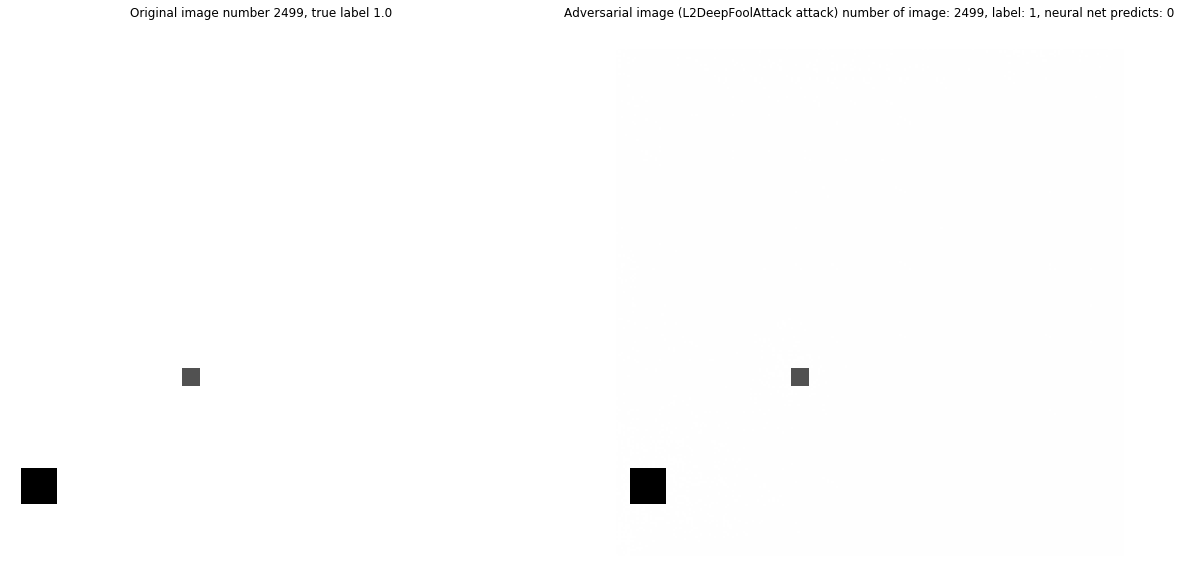

Image number 2499.
Image number 2500.
Image number 2502.


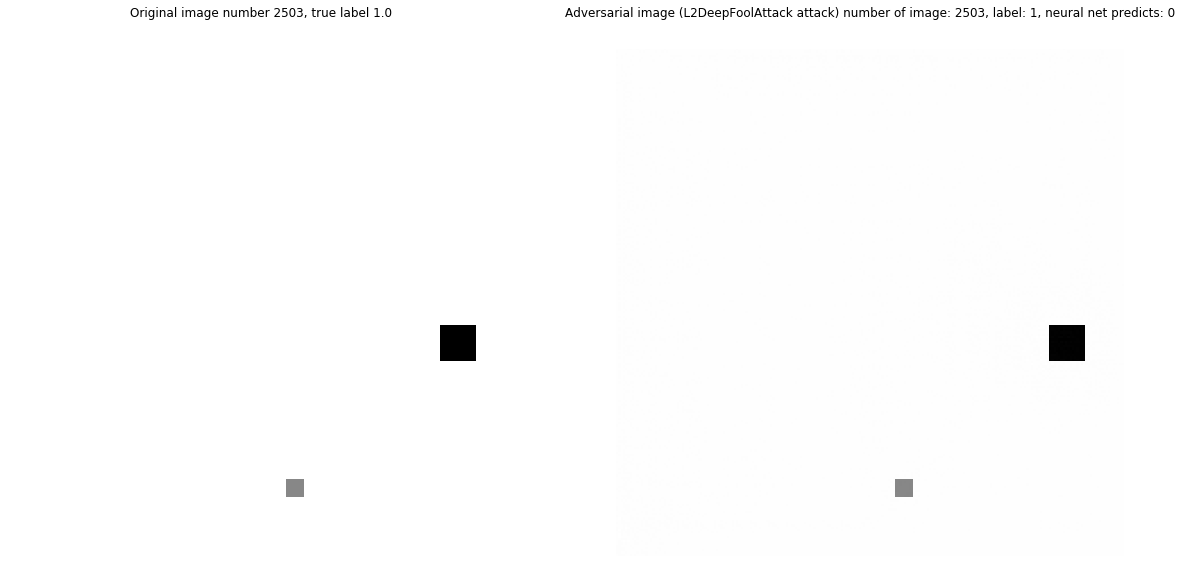

Image number 2504.
Image number 2505.
Image number 2506.
Image number 2507.
Image number 2508.
Image number 2510.
Image number 2511.
Image number 2512.
Image number 2513.
Image number 2514.
Image number 2515.
Image number 2516.
Image number 2517.
Image number 2518.
Image number 2519.
Image number 2520.
Image number 2521.
Image number 2522.


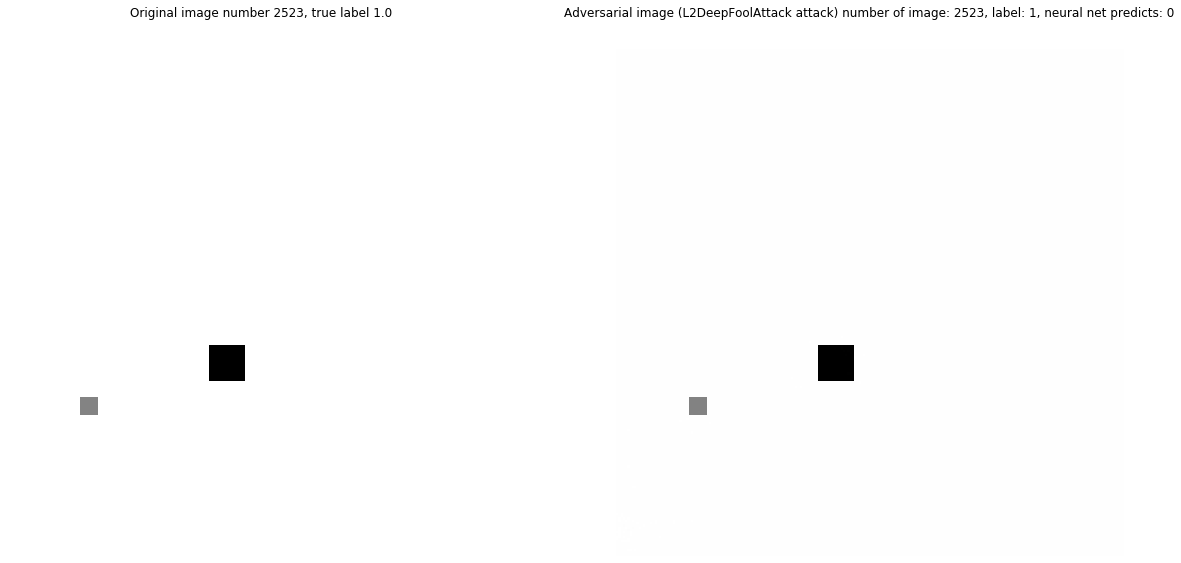

Image number 2523.
Image number 2524.
Image number 2525.
Image number 2526.
Image number 2527.
Image number 2528.
Image number 2529.


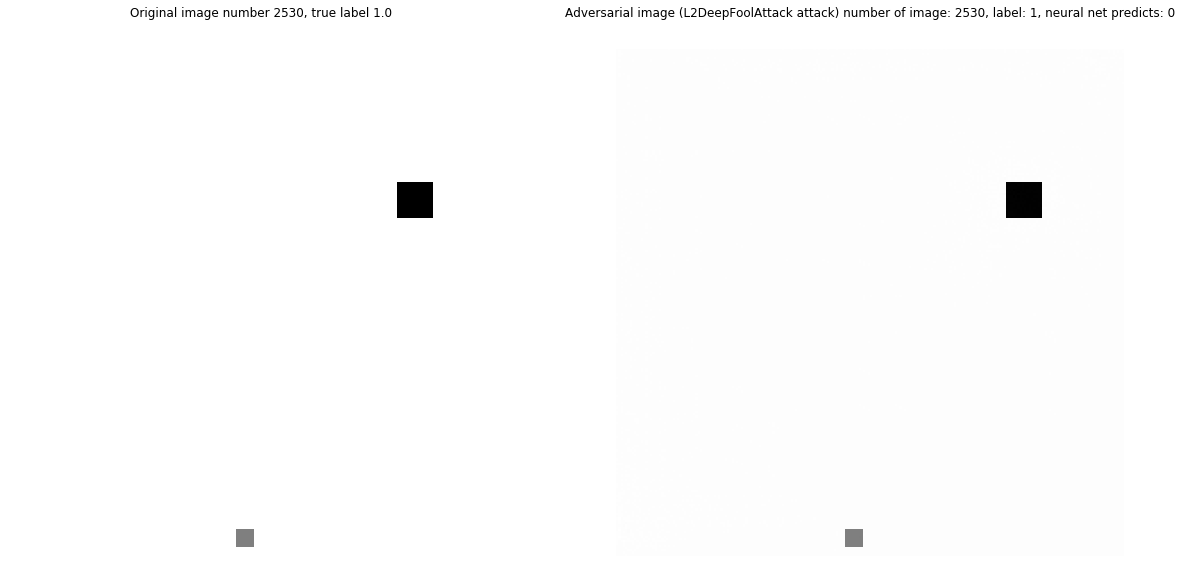

Image number 2530.
Image number 2531.
Image number 2532.
Image number 2533.
Image number 2534.
Image number 2535.
Image number 2536.
Image number 2537.
Image number 2538.
Image number 2539.
Image number 2540.
Image number 2541.
Image number 2542.
Image number 2543.
Image number 2544.
Image number 2545.
Image number 2546.
Image number 2547.
Image number 2548.
Image number 2549.
Image number 2550.
Image number 2551.
Image number 2552.
Image number 2553.
Image number 2554.
Image number 2555.
Image number 2556.
Image number 2557.
Image number 2558.
Image number 2559.
Image number 2560.
Image number 2561.
Image number 2562.
Image number 2563.
Image number 2564.
Image number 2565.
Image number 2566.
Image number 2567.
Image number 2568.
Image number 2569.
Image number 2570.
Image number 2571.
Image number 2572.


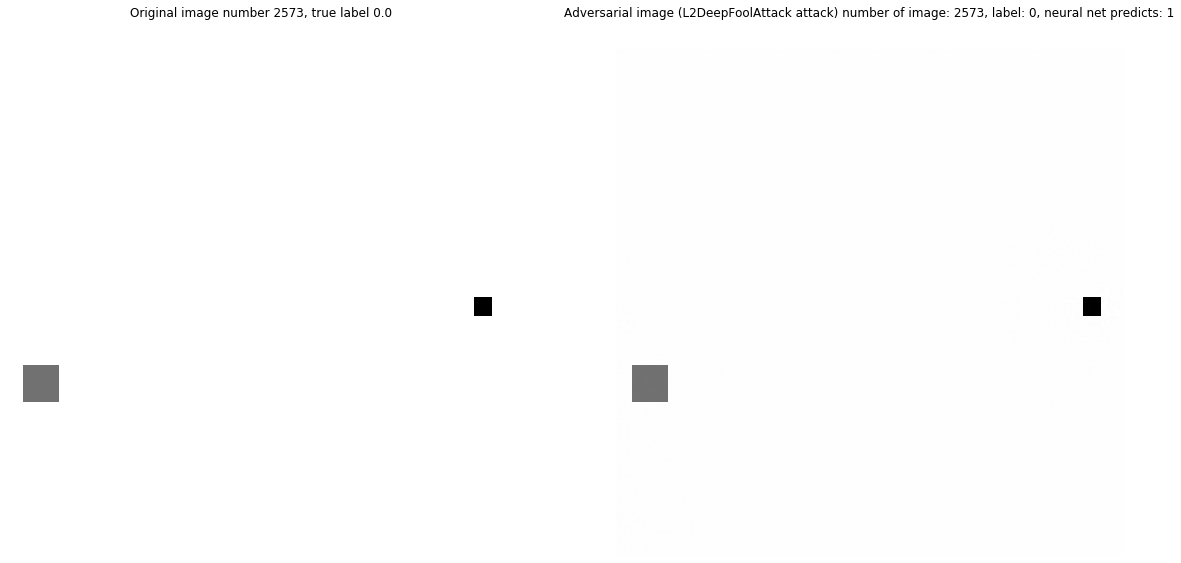

Image number 2573.
Image number 2574.
Image number 2575.
Image number 2576.
Image number 2577.
Image number 2578.
Image number 2579.
Image number 2580.
Image number 2581.
Image number 2582.
Image number 2583.
Image number 2584.
Image number 2585.
Image number 2586.
Image number 2587.
Image number 2588.
Image number 2589.
Image number 2590.
Image number 2591.
Image number 2592.
Image number 2594.
Image number 2595.
Image number 2596.
Image number 2597.
Image number 2598.
Image number 2599.
Image number 2601.
Image number 2602.
Image number 2603.
Image number 2604.
Image number 2605.
Image number 2606.
Image number 2607.


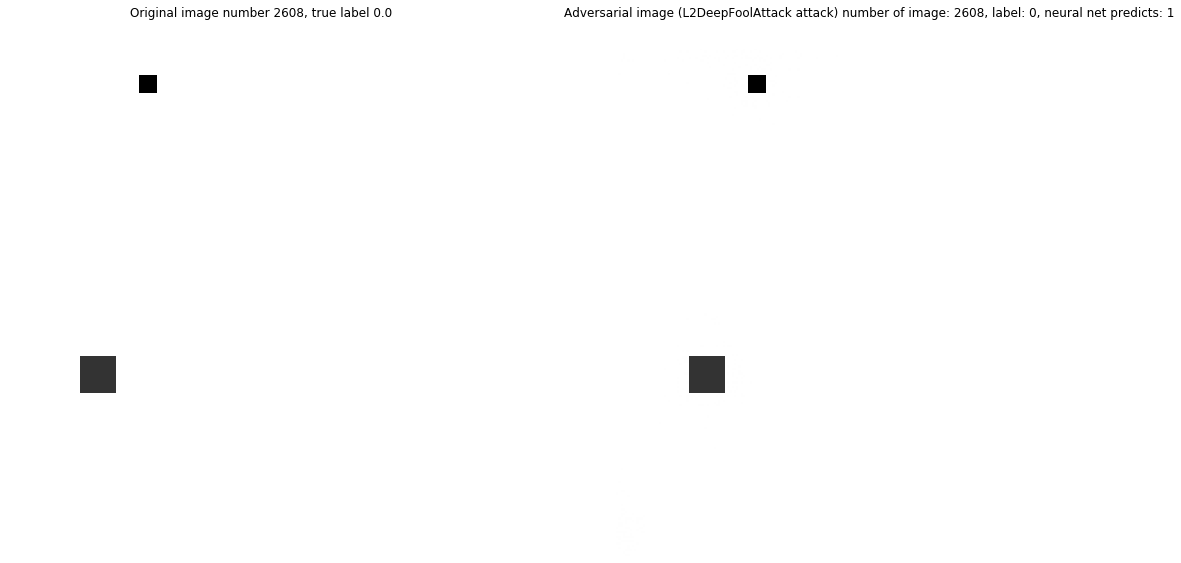

Image number 2608.
Image number 2609.
Image number 2610.
Image number 2611.
Image number 2612.
Image number 2613.
Image number 2614.
Image number 2615.
Image number 2616.
Image number 2617.
Image number 2618.
Image number 2619.


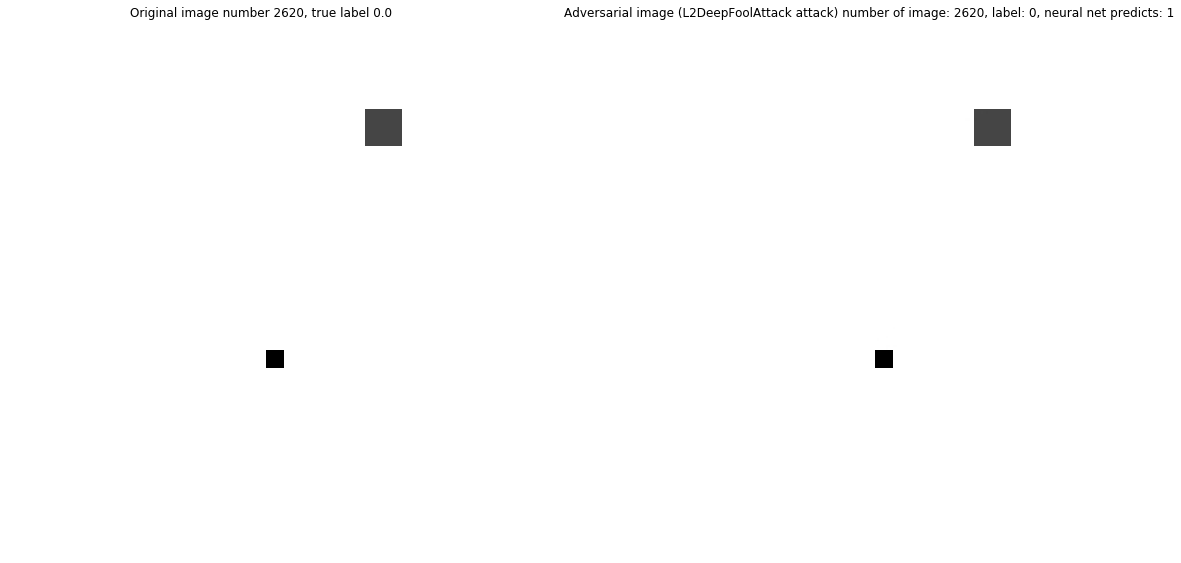

Image number 2620.
Image number 2621.
Image number 2622.
Image number 2623.
Image number 2625.
Image number 2626.
Image number 2627.
Image number 2628.
Image number 2629.
Image number 2630.
Image number 2631.
Image number 2632.
Image number 2633.
Image number 2634.
Image number 2635.
Image number 2636.
Image number 2637.
Image number 2638.
Image number 2639.
Image number 2640.
Image number 2641.
Image number 2642.
Image number 2643.
Image number 2644.
Image number 2645.
Image number 2646.
Image number 2647.
Image number 2648.
Image number 2649.
Image number 2650.
Image number 2651.
Image number 2652.
Image number 2654.
Image number 2655.
Image number 2656.
Image number 2657.
Image number 2658.
Image number 2659.
Image number 2660.
Image number 2661.
Image number 2662.
Image number 2663.
Image number 2664.
Image number 2665.
Image number 2666.
Image number 2667.
Image number 2668.
Image number 2669.
Image number 2670.
Image number 2671.
Image number 2672.
Image number 2673.
Image number

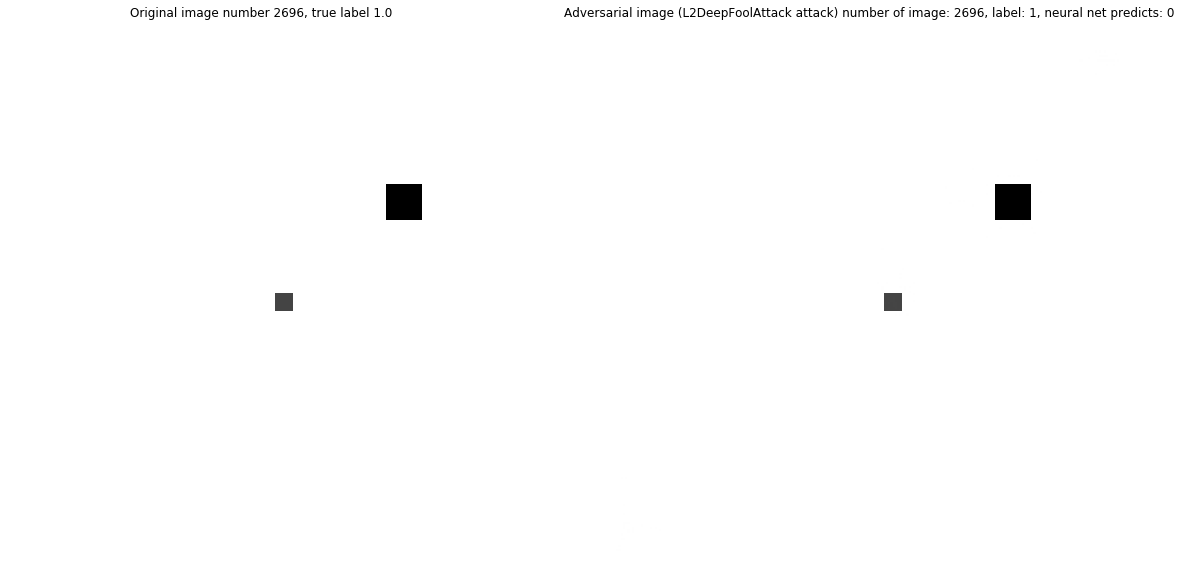

Image number 2696.


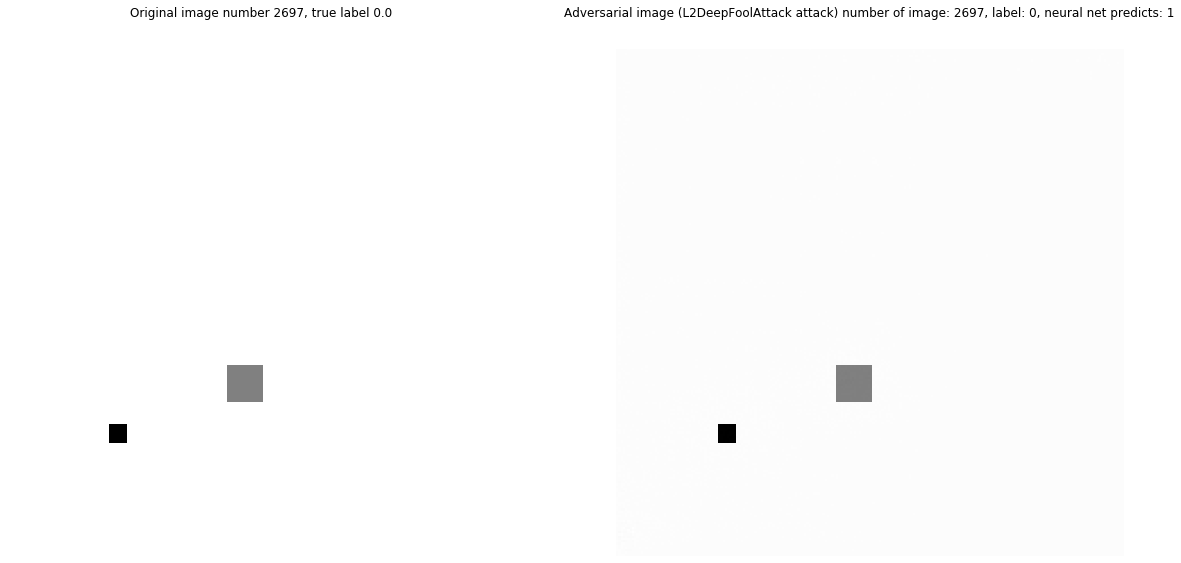

Image number 2697.
Image number 2698.
Image number 2699.
Image number 2700.
Image number 2701.
Image number 2702.
Image number 2703.
Image number 2705.
Image number 2706.
Image number 2707.
Image number 2708.
Image number 2709.
Image number 2710.
Image number 2711.
Image number 2713.
Image number 2714.
Image number 2715.
Image number 2716.
Image number 2717.
Image number 2718.
Image number 2719.
Image number 2720.
Image number 2721.
Image number 2722.
Image number 2723.
Image number 2724.
Image number 2725.
Image number 2726.
Image number 2727.
Image number 2728.
Image number 2729.
Image number 2730.
Image number 2731.
Image number 2732.
Image number 2733.
Image number 2734.
Image number 2735.
Image number 2736.
Image number 2737.
Image number 2738.
Image number 2739.
Image number 2740.
Image number 2741.
Image number 2742.
Image number 2743.
Image number 2744.
Image number 2745.
Image number 2746.
Image number 2747.
Image number 2748.
Image number 2749.
Image number 2750.
Image number

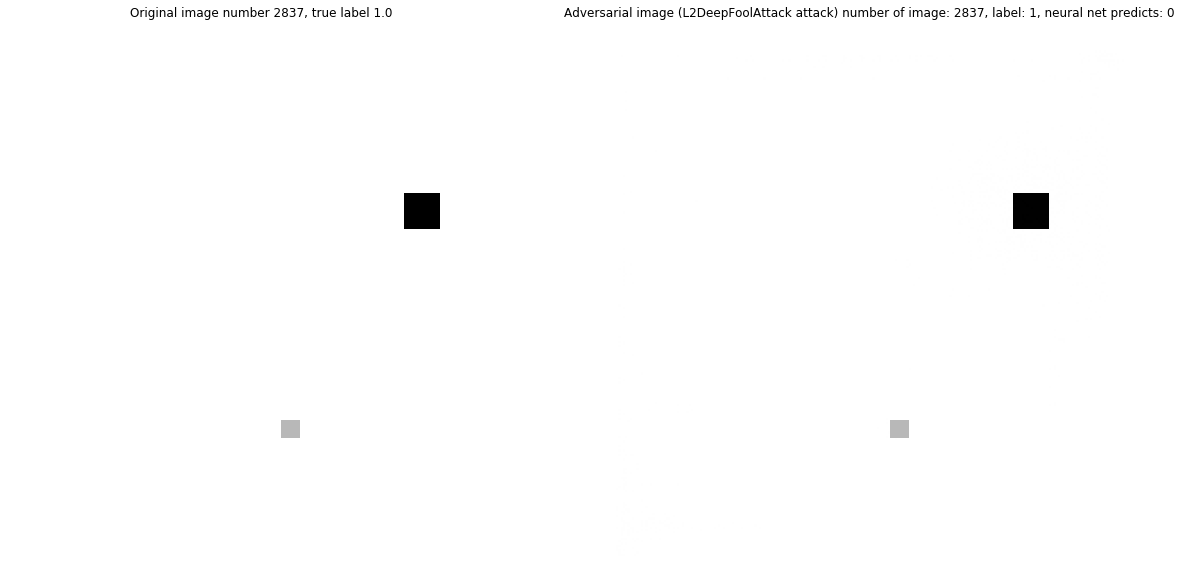

Image number 2837.
Image number 2838.
Image number 2839.


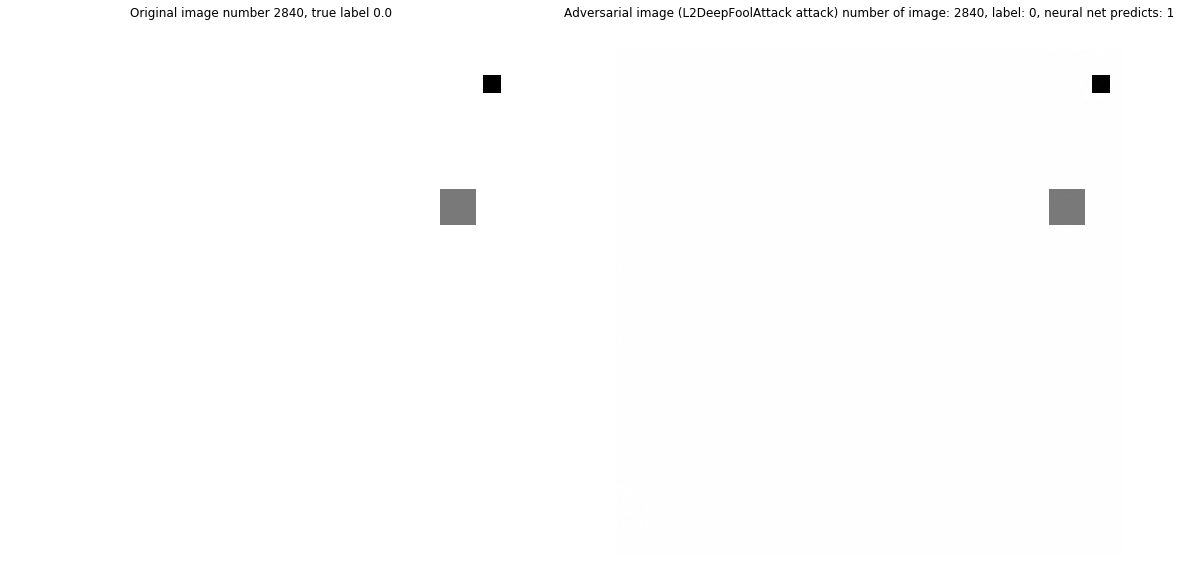

Image number 2840.
Image number 2841.
Image number 2843.
Image number 2844.
Image number 2845.
Image number 2846.
Image number 2847.
Image number 2848.
Image number 2849.


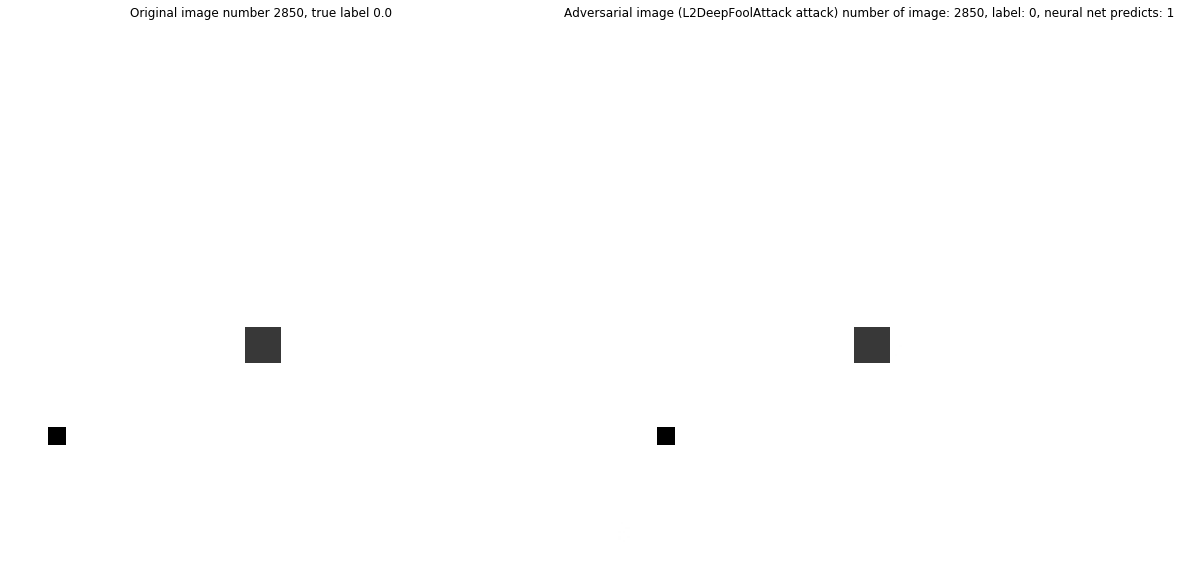

Image number 2851.
Image number 2852.
Image number 2853.
Image number 2854.
Image number 2855.
Image number 2856.
Image number 2857.
Image number 2858.
Image number 2859.
Image number 2860.
Image number 2861.
Image number 2862.
Image number 2863.
Image number 2864.
Image number 2865.
Image number 2866.
Image number 2867.
Image number 2869.
Image number 2870.
Image number 2871.
Image number 2872.
Image number 2873.
Image number 2874.
Image number 2875.
Image number 2876.
Image number 2877.
Image number 2878.
Image number 2879.
Image number 2880.
Image number 2881.


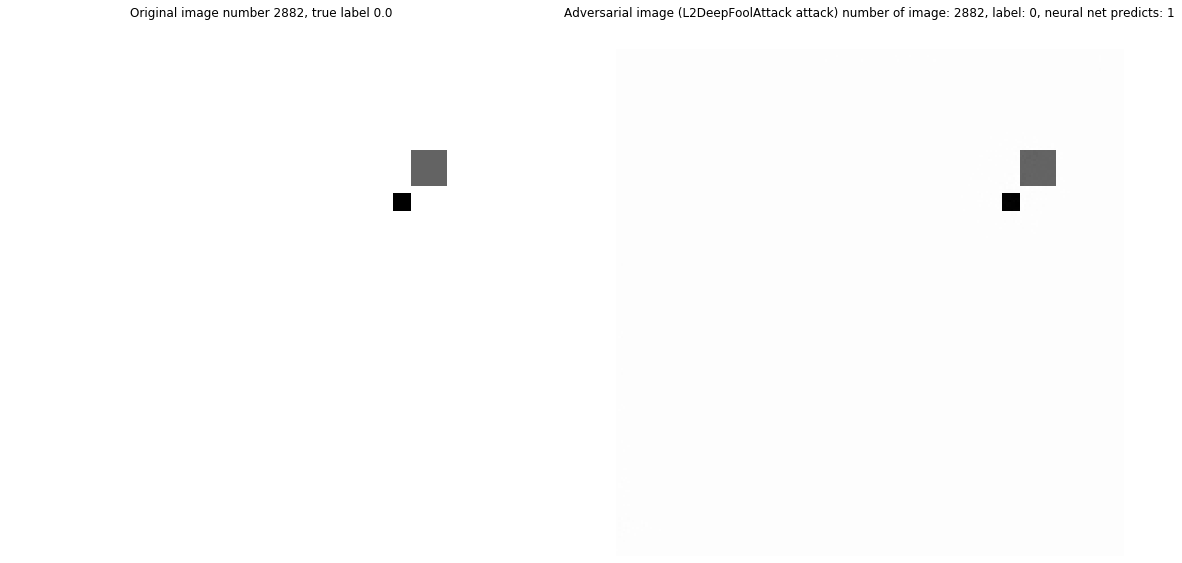

Image number 2882.
Image number 2883.
Image number 2884.
Image number 2885.
Image number 2886.
Image number 2887.
Image number 2888.
Image number 2889.
Image number 2890.
Image number 2891.
Image number 2892.
Image number 2893.
Image number 2894.
Image number 2895.
Image number 2896.
Image number 2897.
Image number 2898.
Image number 2899.
Image number 2900.
Image number 2901.
Image number 2902.
Image number 2903.
Image number 2905.
Image number 2906.
Image number 2907.
Image number 2908.
Image number 2909.
Image number 2910.
Image number 2911.
Image number 2912.
Image number 2914.
Image number 2915.
Image number 2916.
Image number 2917.
Image number 2918.
Image number 2919.
Image number 2920.
Image number 2921.
Image number 2922.
Image number 2923.
Image number 2924.
Image number 2925.
Image number 2926.
Image number 2927.
Image number 2928.
Image number 2929.
Image number 2930.
Image number 2931.
Image number 2932.
Image number 2933.
Image number 2934.
Image number 2935.
Image number

In [7]:
# Do adversarial attacks on training data (can also do on test)

originals = []
adversarials = []
adv_lab = []
ans = []

plt.figure()

data_size = 3000

if attack == 'spsa':
    for i in range(data_size): 
        colors = set(data[i].flatten())
        colors = [colors.pop(),colors.pop(),colors.pop()]
        color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
        lower = min(color_diff)

        epsilon = lower/4
        delta = epsilon/8
        alpha = delta
        T = 20
        n = 5

        candidates = spsa_T1(model, data[i], delta, alpha, n, epsilon, T)
        for cand in candidates:
            cand = np.expand_dims(cand, axis=0)
            if round(model.predict(cand)[0,0]) !=  labels[i][0]:
                adversarials.append(cand)
                adv_lab.append(labels[i])

else:
    for i in range(data_size): 
        if np.argmax(model.predict(tf.convert_to_tensor(data[i].reshape((1, 224, 224, 1))))) == int(labels[i]):
            print("Image number {}.".format(i))
            # Only images that get correctly labeled in the first place
            colors = set(data[i].flatten())
            # print('The original shades are {}'.format(colors))
            colors = [colors.pop(),colors.pop(),colors.pop()]
            color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
            lower = min(color_diff)

            epsilon = lower/4

            #_, clipped, _= attack_selector(attack, model, preprocessing, data[i], labels[i], epsilon)
            _, cand, _= attack_network(attack, model, model_name, preprocessing, data[i], labels[i], epsilon)

            # print('The ones generated by the adversarial attack are {}'.format(set(cand.flatten())))


            if np.argmax(model.predict(cand)) !=  int(labels[i]):
                # Where adversarial images succeed in making the initial correct prediciton wrong


                img_to_show = (np.reshape(data[i],(224,224)) +122)/255
                cand_to_show = (np.reshape(cand,(224,224)) +122)/255
                
                originals.append(img_to_show)
                adversarials.append(cand_to_show)
                adv_lab.append(labels[i])
                ans.append(np.argmax(model.predict(cand)))
                
                
                plt.figure(figsize=(20,10))

                plt.subplot(121)
                plt.matshow(img_to_show, cmap = 'gray', fignum=False)
                plt.axis('off')
                plt.title('Original image number {}, true label {}'.format(i+1, labels[i]))

                plt.subplot(122)
                plt.matshow(cand_to_show, cmap = 'gray', fignum=False)
                plt.axis('off')
                plt.title('Adversarial image ({} attack) number of image: {}, label: {}, neural net predicts: {}'.format(attack, i+1, int(labels[i]), np.argmax(model.predict(cand))))

                plt.show()



    
np.save(original_data, originals)
np.save(adv_data, adversarials)
np.save(adv_labels, adv_lab)

In [8]:
# For FC3 381 and 629 in training become adversarial with LinfPGD
# For CNN4 38, 101, 313, 354, 562, 623, 629, 731, 839, 1013, 1071, 1091, 
# 1130, 1266, 1359, 1606, 1640, 1642, 1716, 1811, 1969, 2003, 2017, 2240, 2287, 2290, 2452, 2458, 2652, 2749, 2779
# 2947, 2955, 



In [9]:
for i in range(len(originals)):
    print(sum(abs(originals[i]-adversarials[i]).numpy().flatten()))

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
exit()